#### Введение

Анализ временных рядов - очень обширная и одновременно очень узкая тема для обсуждения на сегодняшний день. Под временным рядом можно подразумевать любую последовательность чисел, которую можно разбить на определенные временные промежутки. Такие последовательности поддаются анализу с помощью методов математической статистики, стохастическим анализом и стандартными алгоритмами для машинного обучения, в том числе и нейронным сетям. Но пожалуй дадим сперва четкие определения терминам, которые будем использовать в дальнейшем.

#### Временной ряд

Пусть есть функция $f(x)$, зависящая от времени и временные периоды $t=\{t_1, t_2, \dots, t_n\}$. Последовательность замеров значений $Y=\{y_1,y_2,\dots,y_t\}$ называется временным рядом, где $y_i\in\mathbb{R}$. Иным языком, временным рядом называется последовательность значений, описывающих протекающий во времени некий процесс, измеренный в одинаковые периоды времени.

Для анализа и прогнозирования временных рядов используют различные методы из различных подходов - эконометрический, статистический, машинное обучение и нейронные сети. 

Любой подход прогнозирования временного ряда называется моделью временного ряда. Выглядит она следующим образом:

$\hat{y}_{t+d}(w) = f_{t,d}(y_1,\dots y_t;w)$, где $d = 1,\dots,D$, $D$ - горизонт прогнозирования, $w$ - вектор параметров модели

Классическим способом прогнозирования временных рядов является метод наименьших квадратов:

$Q_{t}(w) = \sum_{i = t_0}^t(\hat{y_i}(w) - y_i)^{2} \rightarrow \min_w$

Но с таким подходом возникают следующие проблемы:

* Рядов много
* Поведение рядов описывается разными моделями
* Модель должна перестроиться к моменту $t+1$
* Функция потерь может быть неквадратичной

#### Датасет

Прежде чем мы ближе рассмотрим различные методы прогнозирования, сперва посмотрим на те данные, которые я выбрал для данной работы. В качестве датасета мы будем использовать собранную статистику по заболевшим в разных странах вирусом COVID-19. Для загрузки и визуализации данных нам понадобятся следующие библиотеки: ```pandas```, ```numpy```, ```seaborn```, ```matplotlib```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 120

Populating the interactive namespace from numpy and matplotlib


В нашем распоряжении есть данные по количеству заболевших с 22 января по 18 мая

In [2]:
covid_df = pd.read_csv('Datasets/covid_19_data.csv')
covid_confirmed_df = pd.read_csv('Datasets/time_series_covid_19_confirmed.csv')
covid_deaths_df = pd.read_csv('Datasets/time_series_covid_19_deaths.csv')

In [3]:
covid_df.head()

SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0

In [4]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26336 entries, 0 to 26335
Data columns (total 8 columns):
SNo                26336 non-null int64
ObservationDate    26336 non-null object
Province/State     12686 non-null object
Country/Region     26336 non-null object
Last Update        26336 non-null object
Confirmed          26336 non-null float64
Deaths             26336 non-null float64
Recovered          26336 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.6+ MB


In [5]:
covid_confirmed_df.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  \
0        0        0        0  ...    4033     4402     4687     4963     5226   
1        0        0        0  ...     856      868      872      876      880   
2        0        0        0  ...    5558     5723     5891     6067     6253   
3        0        0        0  ...     754      755      755      758      760   
4        0        0        0  ...      43       45       45       45       45   

   5/14/20  5/15/20  5/16/20  5/17/20  5/18/20  
0     5639     6053     6402     6664     7072  
1      898      916      933      946      948  
2     6442     6629     6821     7019     7201  
3      761      761      761      761      761  
4       48       48       48       48       50  

[5 rows x 122 columns]

In [6]:
covid_confirmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 122 entries, Province/State to 5/18/20
dtypes: float64(2), int64(118), object(2)
memory usage: 253.6+ KB


In [7]:
covid_deaths_df.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  \
0        0        0        0  ...     115      120      122      127      132   
1        0        0        0  ...      31       31       31       31       31   
2        0        0        0  ...     494      502      507      515      522   
3        0        0        0  ...      48       48       48       48       49   
4        0        0        0  ...       2        2        2        2        2   

   5/14/20  5/15/20  5/16/20  5/17/20  5/18/20  
0      136      153      168      169      173  
1       31       31       31       31       31  
2      529      536      542      548      555  
3       49       49       51       51       51  
4        2        2        2        2        3  

[5 rows x 122 columns]

In [8]:
covid_deaths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 122 entries, Province/State to 5/18/20
dtypes: float64(2), int64(118), object(2)
memory usage: 253.6+ KB


Судя по данным из pandas мы можем видеть, что по последнему обновлению мы имеем 26336 строк по обнолвениям в разных странах, имеем 266 стран, в которых есть подтвержденные случаи заражения и 122 страны с подтвержденными смертями. Поскольку, у нас колонка отвечает только лишь за дату, а сам ряд разбит по датам в ряд. Поэтому попробуем посмотреть как выглядит ряд для нескольких стран, например, России, Италии, Китая и США. Также сравним с такими странами, как Республика Беларусь и Швеция (страны, которые не предпринимали никаких шагов для предотвращения эпидемии)

In [9]:
covid_russia_confirmed_df = covid_confirmed_df[covid_confirmed_df['Country/Region'] == 'Russia'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_russia_death_df = covid_deaths_df[covid_confirmed_df['Country/Region'] == 'Russia'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_china_confirmed_df = covid_confirmed_df[covid_confirmed_df['Country/Region'] == 'China'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_china_death_df = covid_deaths_df[covid_confirmed_df['Country/Region'] == 'China'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_italy_confirmed_df = covid_confirmed_df[covid_confirmed_df['Country/Region'] == 'Italy'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_italy_death_df = covid_deaths_df[covid_confirmed_df['Country/Region'] == 'Italy'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_us_confirmed_df = covid_confirmed_df[covid_confirmed_df['Country/Region'] == 'US'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_us_death_df = covid_deaths_df[covid_confirmed_df['Country/Region'] == 'US'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_sweden_confirmed_df = covid_confirmed_df[covid_confirmed_df['Country/Region'] == 'Sweden'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_sweden_death_df = covid_deaths_df[covid_confirmed_df['Country/Region'] == 'Sweden'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_belarus_confirmed_df = covid_confirmed_df[covid_confirmed_df['Country/Region'] == 'Belarus'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
covid_belarus_death_df = covid_deaths_df[covid_confirmed_df['Country/Region'] == 'Belarus'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)

Далее напишем функцию, для составления удобного ряда для визуализации. Представлять мы их будем в виде нового датафрейма из двух сопоставленных массивов и даты, где по X будут находиться даты, а по Y - количество зараженных и умерших

In [10]:
from time import strptime

def convert_to_vis(conf, death):
    df = pd.DataFrame(columns=['Date', 'Confirmed', 'Deaths'])
    df['Date'] = pd.to_datetime(conf.columns, format="%m/%d/%y")
    df['Confirmed'] = conf.to_numpy()[0]
    df['Deaths'] = death.to_numpy()[0]
    return df

In [11]:
russia = convert_to_vis(covid_russia_confirmed_df, covid_russia_death_df)
russia.head()

Date  Confirmed  Deaths
0 2020-01-22          0       0
1 2020-01-23          0       0
2 2020-01-24          0       0
3 2020-01-25          0       0
4 2020-01-26          0       0

Теперь напишем функцию для правильной визуализации датасета

In [12]:
def vis(df, title):
    fig = plt.figure(dpi=200)
    ax = df.plot(x="Date", y="Confirmed", legend=False, color='b')
    ax.figure.legend()
    plt.title(title)
    plt.show()

На следующем графике мы видим распределение подтвержденных заболеваний и смертей в России.

<Figure size 2400x1600 with 0 Axes>

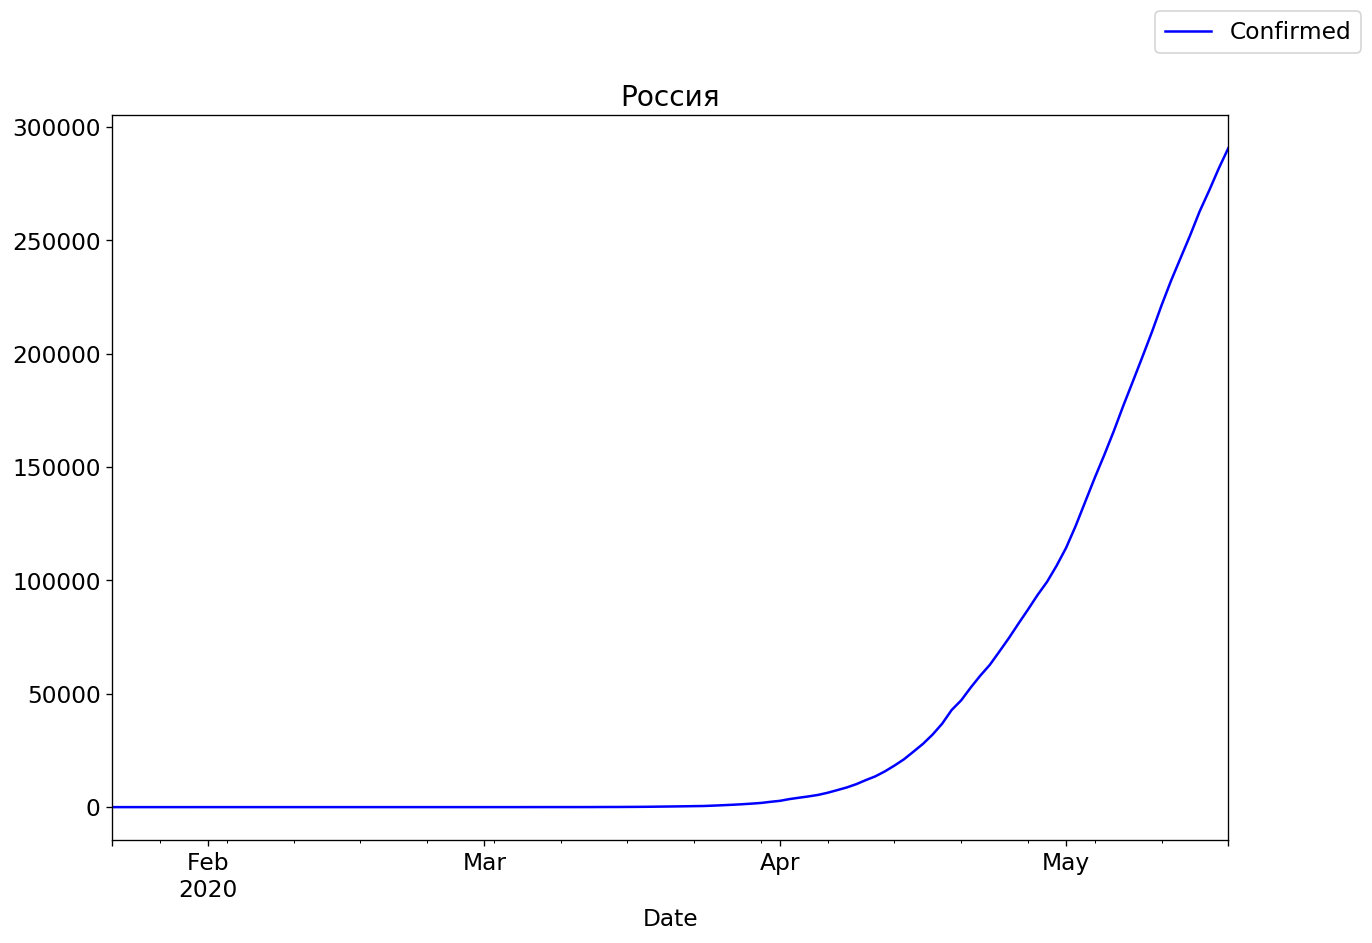

In [13]:
vis(russia, "Россия")

А теперь сравним с другими странами

<Figure size 2400x1600 with 0 Axes>

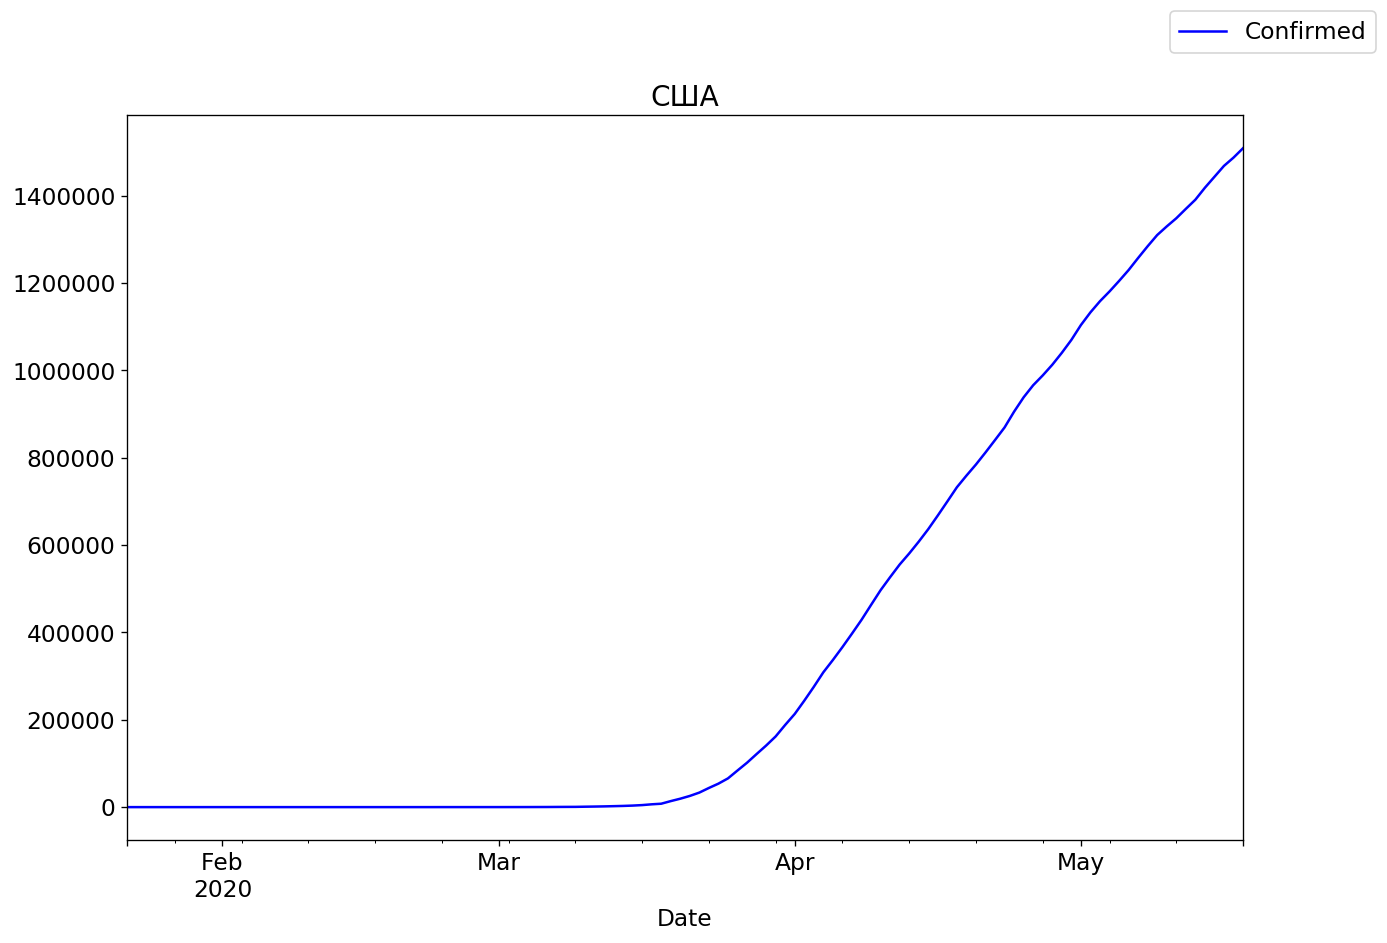

In [14]:
us = convert_to_vis(covid_us_confirmed_df, covid_us_death_df)
vis(us, 'США')

<Figure size 2400x1600 with 0 Axes>

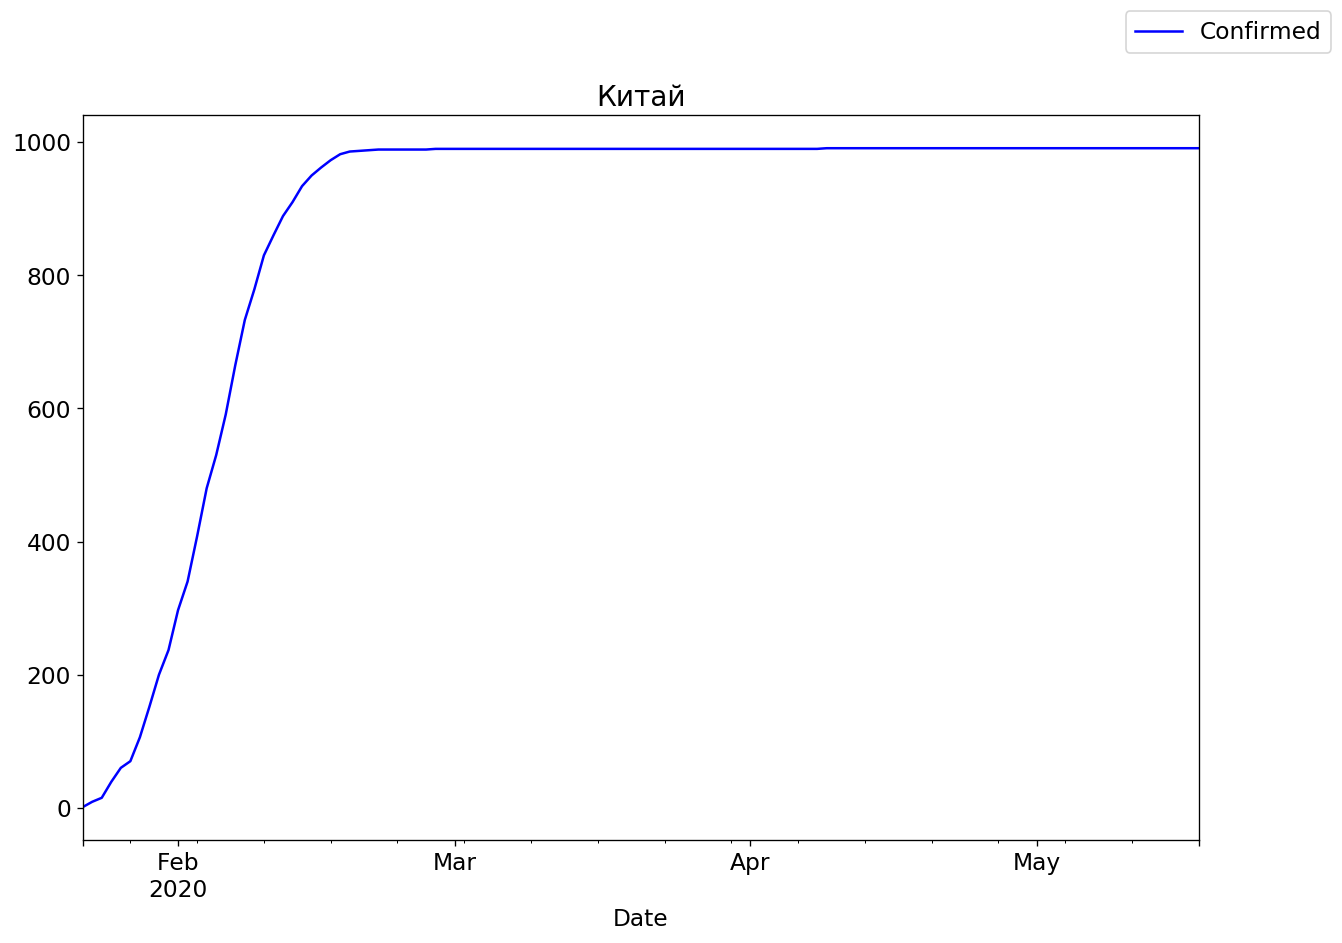

In [15]:
china = convert_to_vis(covid_china_confirmed_df, covid_china_death_df)
vis(china, 'Китай')

<Figure size 2400x1600 with 0 Axes>

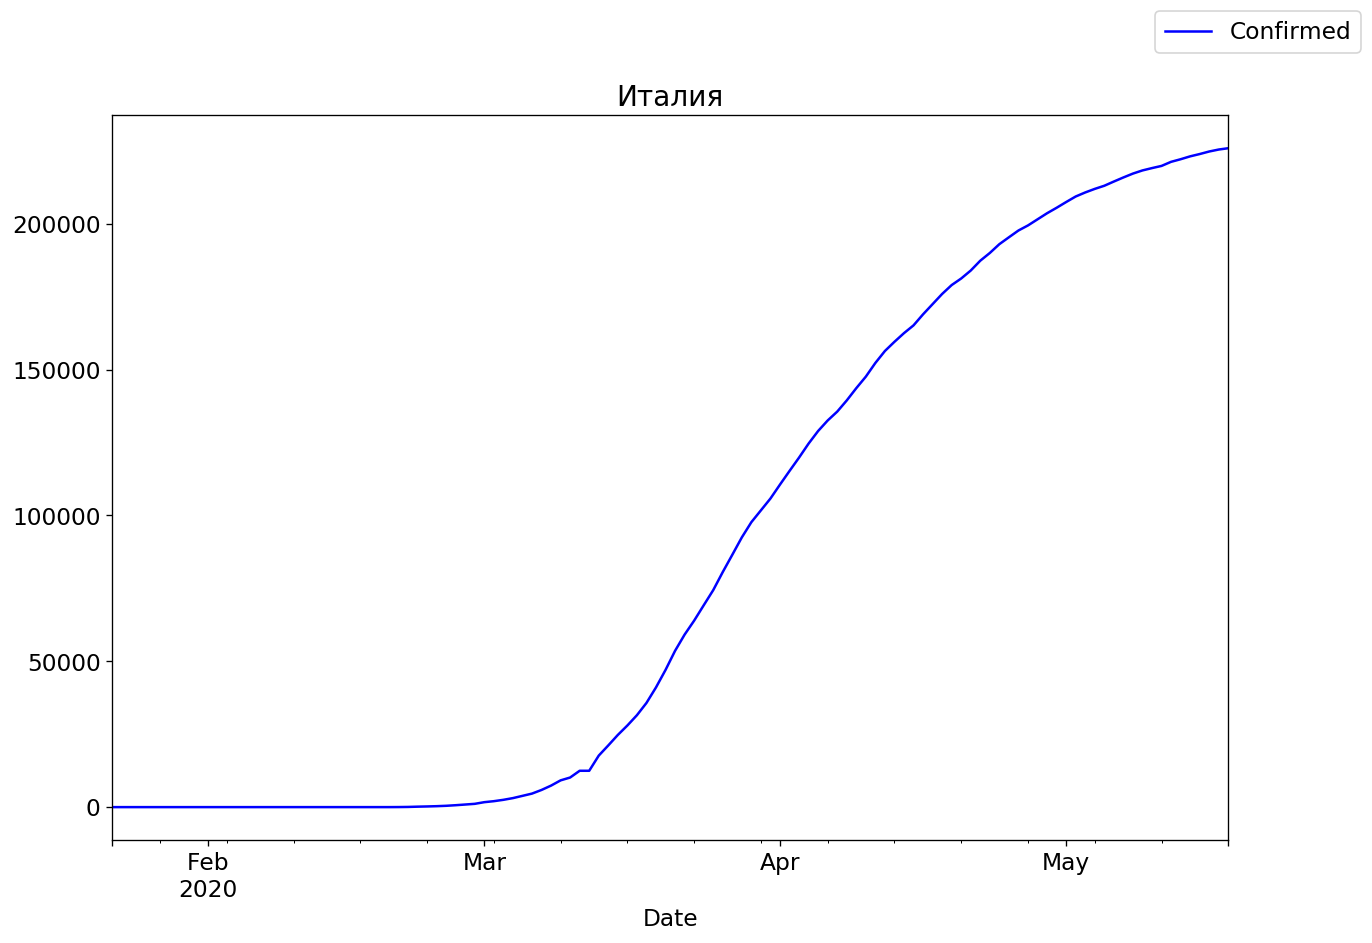

In [16]:
italy = convert_to_vis(covid_italy_confirmed_df, covid_italy_death_df)
vis(italy, "Италия")

<Figure size 2400x1600 with 0 Axes>

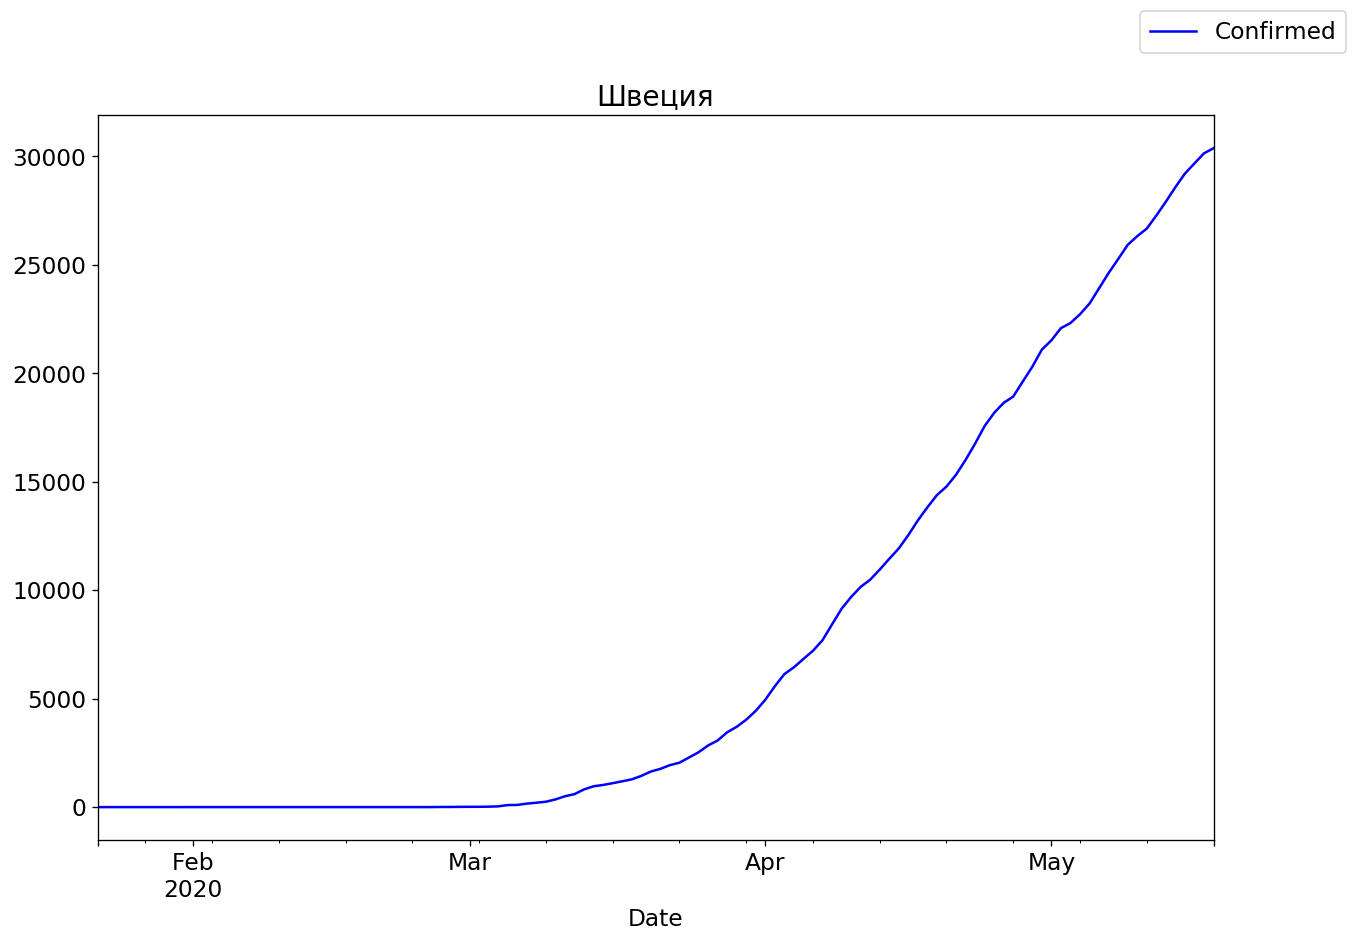

In [17]:
sweden = convert_to_vis(covid_sweden_confirmed_df, covid_sweden_death_df)
vis(sweden, "Швеция")

<Figure size 2400x1600 with 0 Axes>

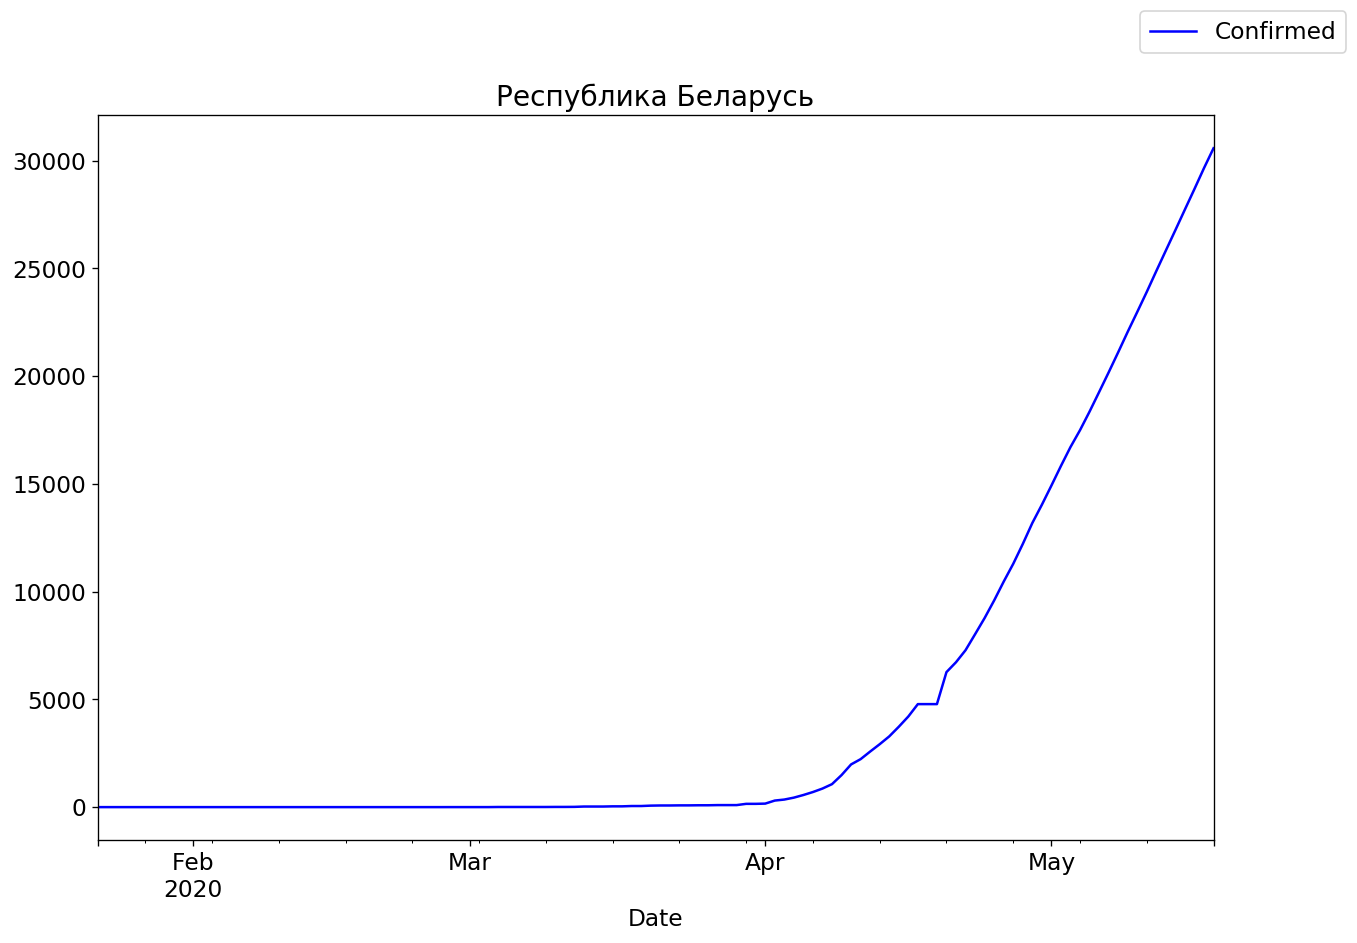

In [18]:
belarus = convert_to_vis(covid_belarus_confirmed_df, covid_belarus_death_df)
vis(belarus, "Республика Беларусь")

А теперь рассмотрим наши данные не с точки зрения общей статистики, а как прирост на каждом промежутке. Напишем метод, который из всех данных покажет нам, как у нас менялась тенденция. Для этого мы пройдем по всему ряду и произведем разность по всем замерам. То есть новое значение в каждом промежутке будет выглядеть как $y_{new} = y_{t} - y_{t-1}$

In [19]:
def new_value(y, y_prev):
    return y - y_prev

def new_value_df(df):
    new_df = pd.DataFrame(columns=df.columns)
    new_df['Date'] = df['Date']
    conf_in = []
    conf_val = 0
    for i, row in df.iterrows():
        conf_in.append(new_value(row.Confirmed, conf_val))
        conf_val = row.Confirmed
        
    new_df['Confirmed'] = conf_in
    return new_df

<Figure size 2400x1600 with 0 Axes>

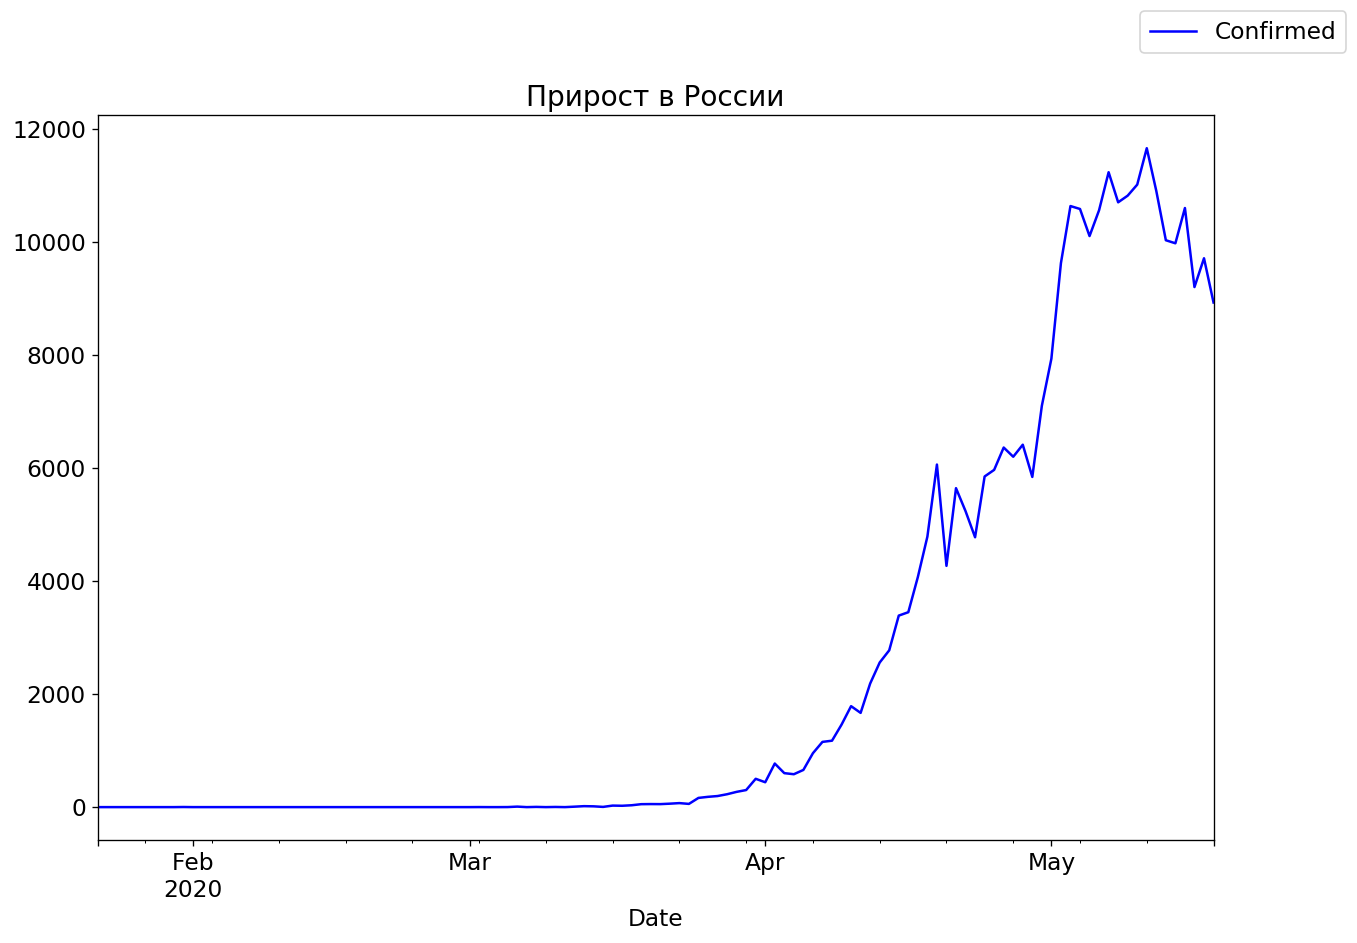

In [20]:
russia_increase = new_value_df(russia)
vis(russia_increase, "Прирост в России")

<Figure size 2400x1600 with 0 Axes>

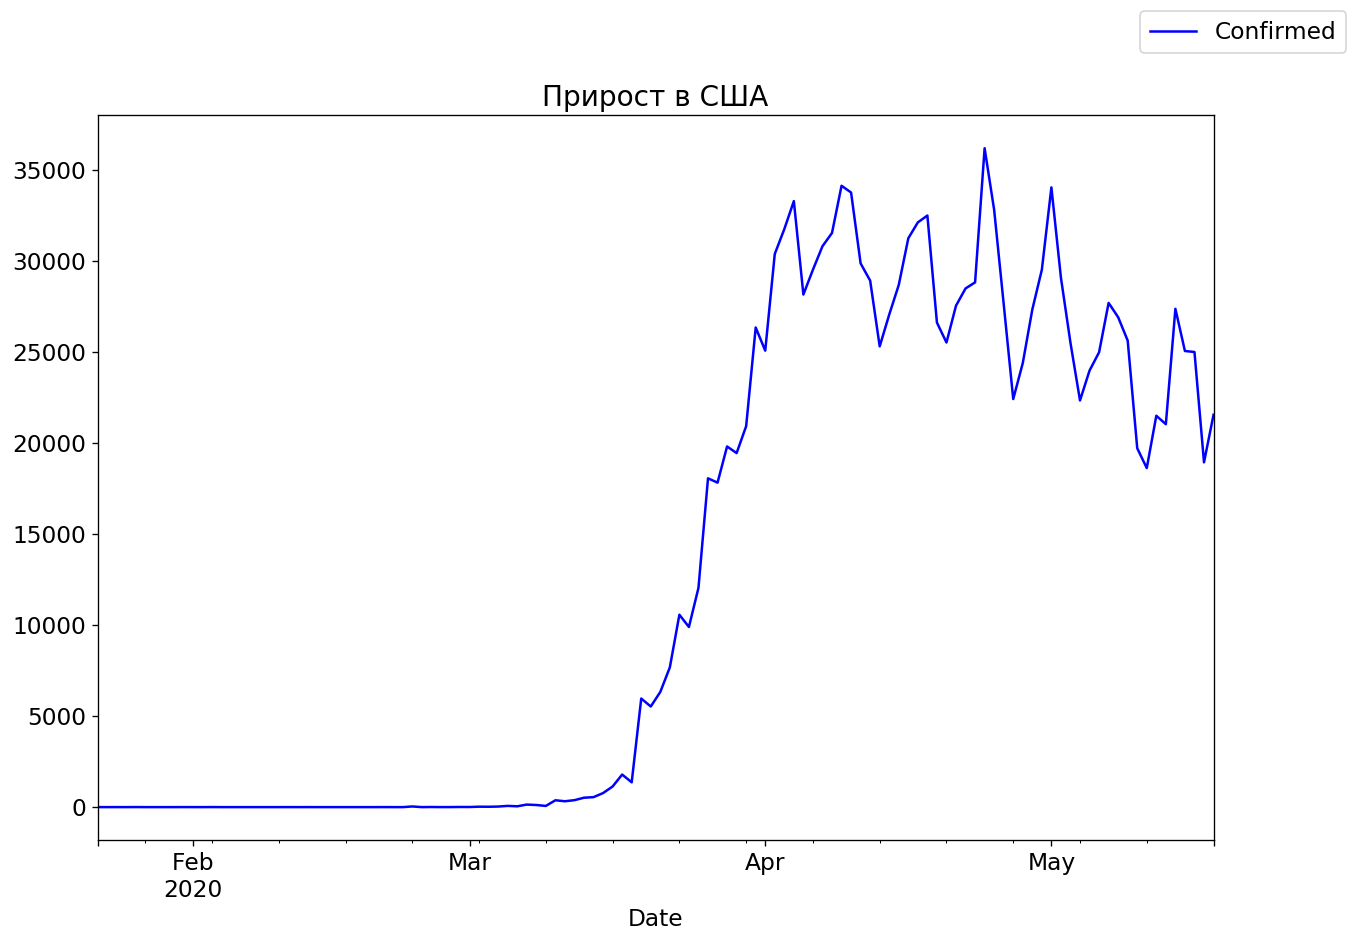

In [21]:
us_increase = new_value_df(us)
vis(us_increase, "Прирост в США")

<Figure size 2400x1600 with 0 Axes>

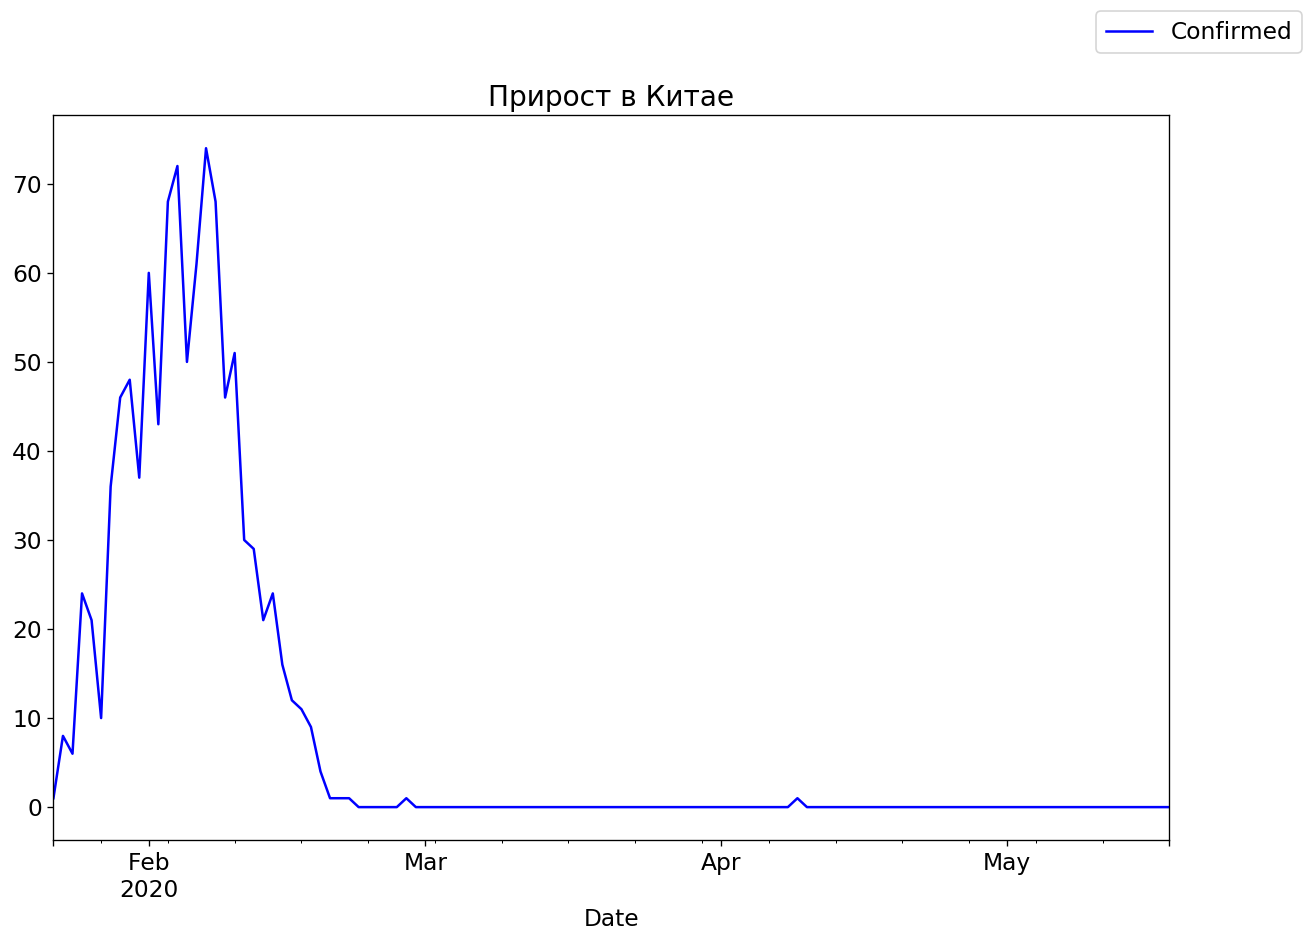

In [22]:
china_increase = new_value_df(china)
vis(china_increase, "Прирост в Китае")

<Figure size 2400x1600 with 0 Axes>

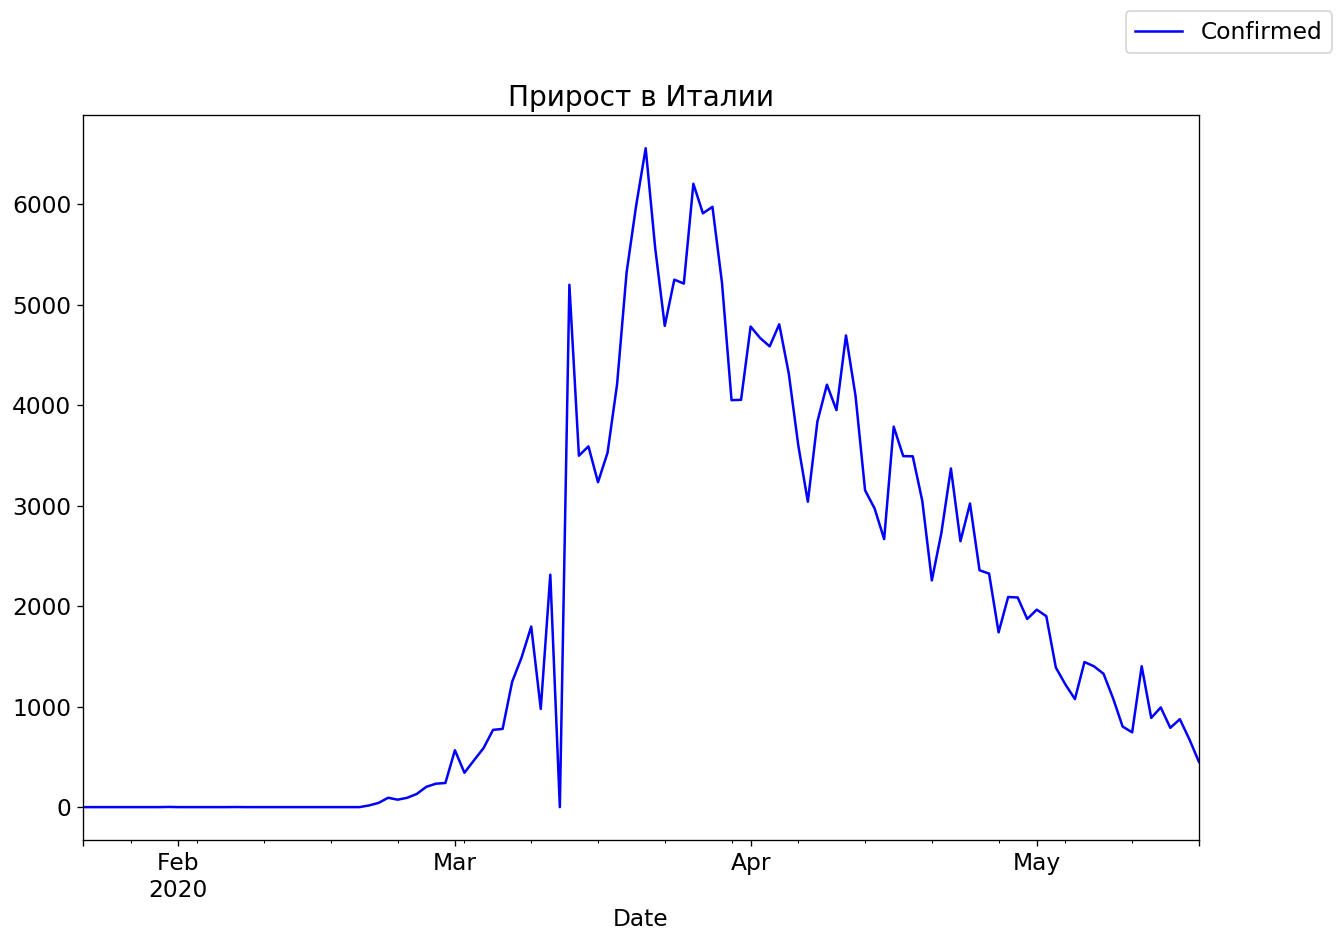

In [23]:
italy_increase = new_value_df(italy)
vis(italy_increase, "Прирост в Италии")

<Figure size 2400x1600 with 0 Axes>

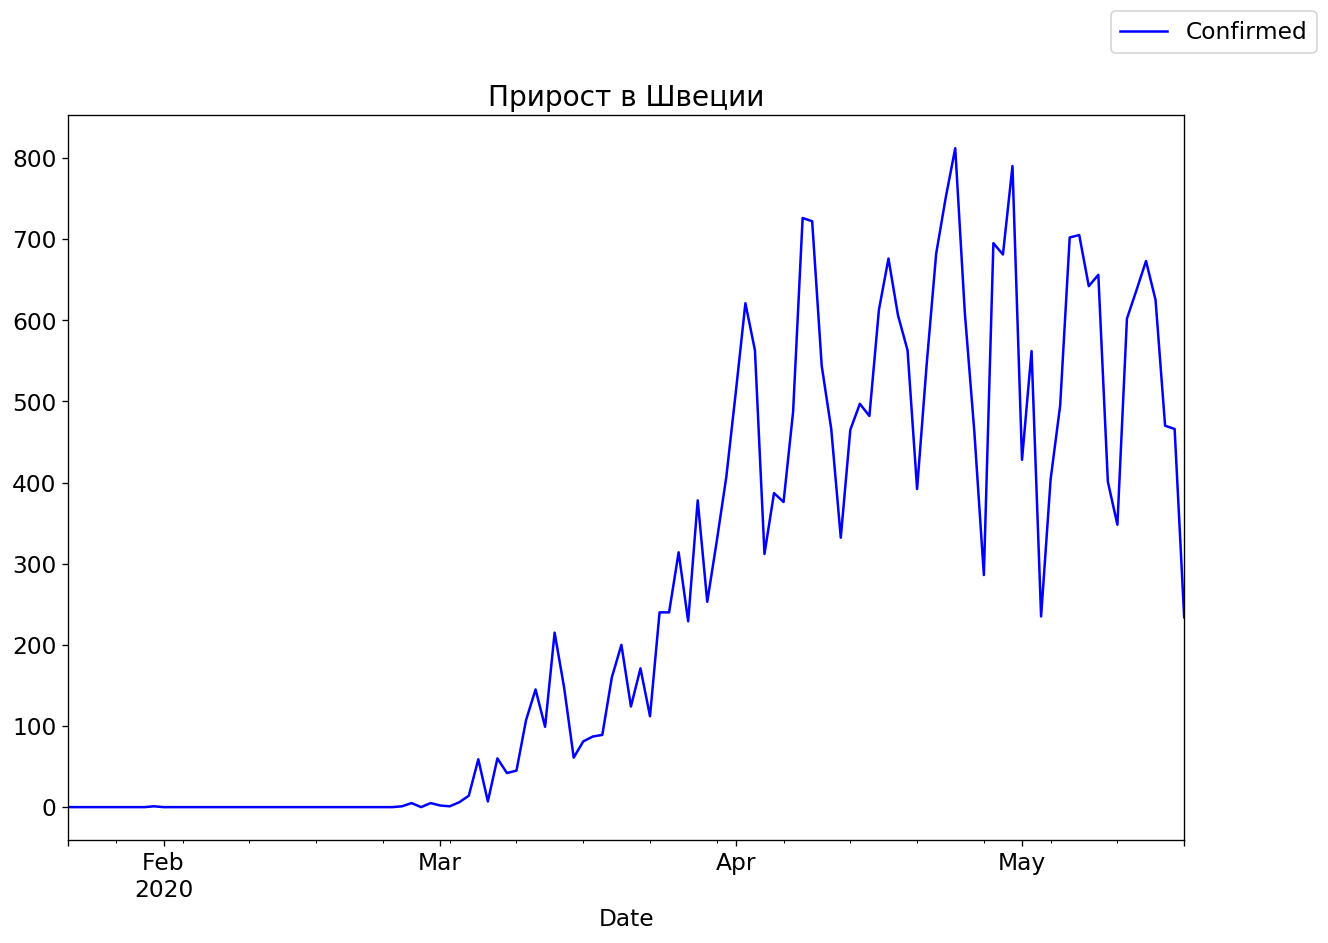

In [24]:
sweden_increase = new_value_df(sweden)
vis(sweden_increase, "Прирост в Швеции")

<Figure size 2400x1600 with 0 Axes>

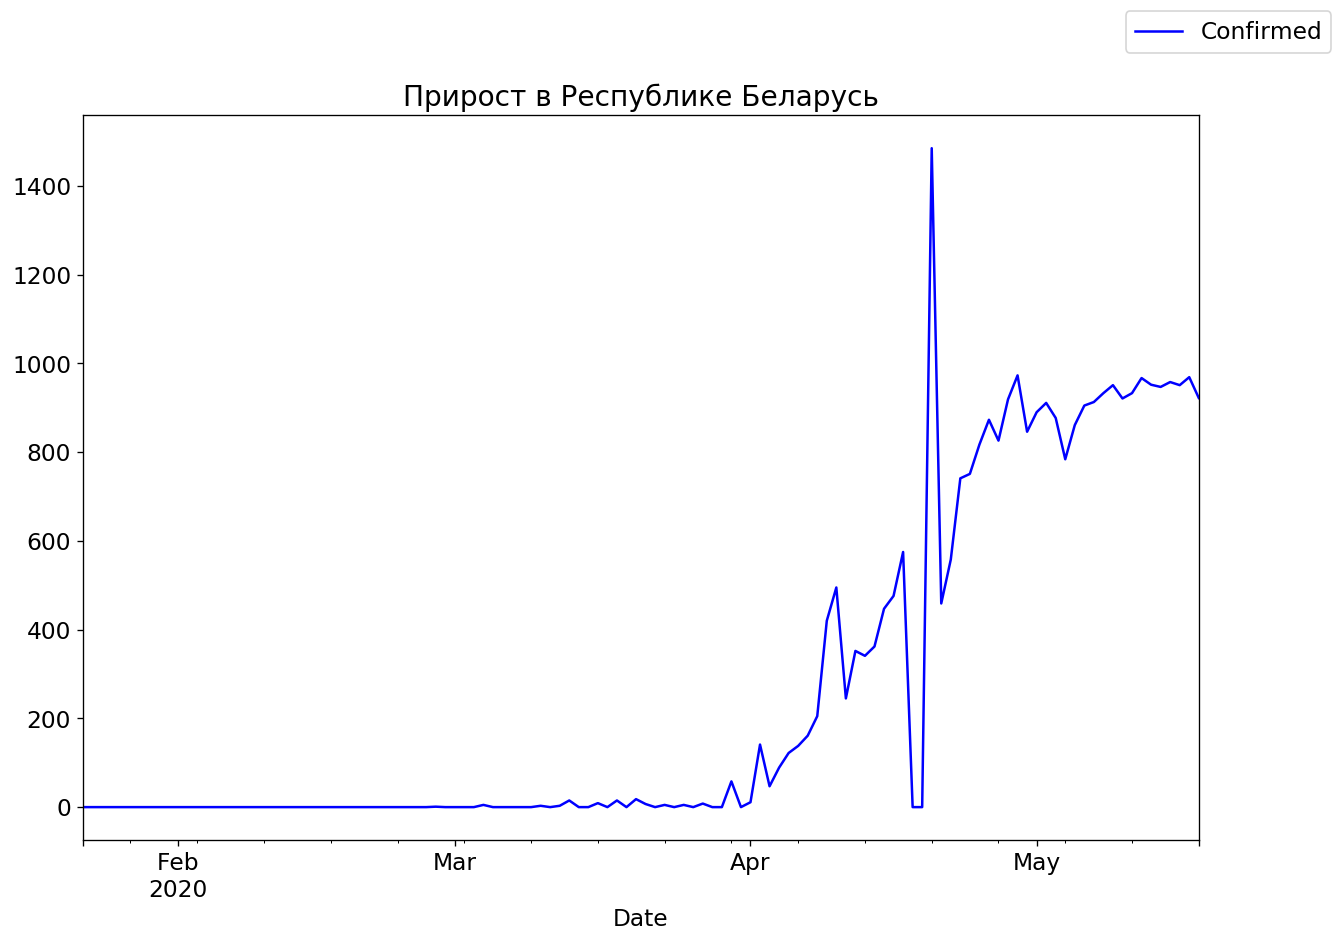

In [25]:
belarus_increase = new_value_df(belarus)
vis(belarus_increase, 'Прирост в Республике Беларусь')

Данные показывают нам, как изменялась тенденция заболеваний и на каком моменте начинали происходить смерти в зависимости от начала эпидемии в той или иной стране (первый заболевший)

Теперь рассмотрим следующие методы для анализа временных рядов и посмотрим, как модели подстраиваются от страны к стране и как модель, обученная на данных из одной страны будет реагировать на данные от другой страны и какую тенденцию демонстрировать.

По скольку данные имеют свою специфичность (нет как таковой сезонности, но есть определенные волнообразные промежутки), то будем делать поправку на эту волнообразность.

В одном графике мы будем сравнивать изначальные данные и те, что у нас получились, поэтому напишем новую функцию, которая будет перебирать наши новые данные и рисовать их на графике.


In [26]:
def vis_eq(df, title, mean_error=None, absolute_error=None):
    fig = plt.figure()
    ax = df.plot(x="Date", y="Confirmed", legend=False, color='b')
    if 'Confirmed_predicted' in df.columns:
        ax_pred = ax.twinx()
        df.plot(x="Date", y='Confirmed_predicted', ax=ax_pred, legend=False, color="g")
    if 'Error' in df.columns:
        ax_error = ax.twinx()
        df.plot(x="Date", y="Error", ax=ax_error, legend=False, color="r")
    ax.figure.legend()
    errors = ""
    if mean_error is not None:
        errors += 'MSE: {}\n'.format(mean_error)
    if absolute_error is not None:
        errors += 'MAE: {}\n'.format(absolute_error)
    ax.set_xlabel(errors)
    ax.set_title(title)
    plt.show()

#### Линейная регрессия

Линейная регрессия - это метод восстановления зависимости между двумя переменными. Ее можно выразить в виде простой линейной модели:

$y_i = f(w, x_i) + \epsilon_i$,
где $\epsilon$ - аддитивная случайная величина. Предполагается, что случайная величина распределена нормально с нулевым матожиданием и фиксированной дисперсией, не зависящая от переменных $x, y$. Веса $w$ вычисляются с помощью метода наименьших квадратов.

<Figure size 1440x960 with 0 Axes>

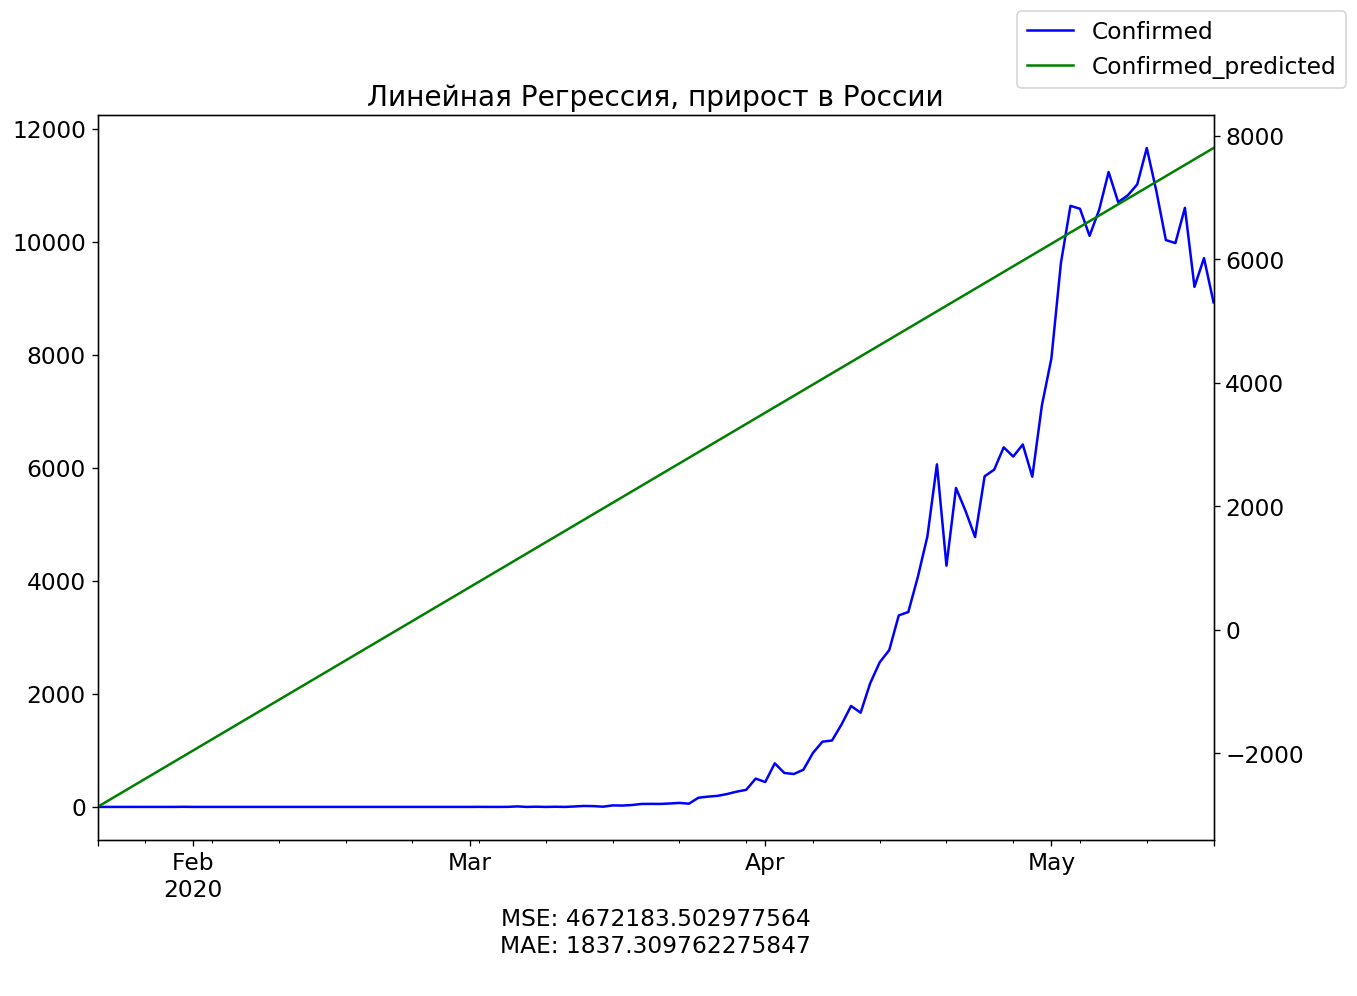

In [27]:
reg = LinearRegression()

length = len(russia_increase)
reg.fit(np.arange(length).reshape(length, 1), russia_increase['Confirmed'].to_numpy().reshape(length, 1))

new_russia_df = russia_increase.copy()
new_russia_df['Confirmed_predicted'] = reg.predict(np.arange(length).reshape(length, 1))

mean_error = mean_squared_error(russia_increase['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(russia_increase['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Линейная Регрессия, прирост в России", mean_error, absolute_error)

Обычная линейная регрессия не сможет нам повторить тот ряд, который у нас был изначально, и тем более не даст нам адекватного прогнозирования, но может показать что-то похожее на тренд на основе предыдущих данных, что у нас были.

Ниже можно наблюдать реализацию метода выявления переменных $b_0$ и $b_1$ для линейной регрессии

In [28]:
def estimate_coefs(x, y):
    n = np.size(x)
    
    mean_x, mean_y = np.mean(x), np.mean(y)
    
    SSE_xy = np.sum(y*x - n*mean_y*mean_x)
    SSE_xx = np.sum(x*x - n*mean_x*mean_x)
    
    b_1 = SSE_xy / SSE_xx
    b_0 = mean_y - b_1*mean_x
    
    return b_0, b_1

estimate_coefs(np.arange(len(russia_increase)), russia_increase['Confirmed'])

(8.344562678089005, 41.9662960457751)

#### Скользящая средняя

Наивное предположение, заявляющее, что следующее значение будет зависеть от ряда предыдущих замеров.

$\hat{y}_t = \frac{1}{k}\sum_{n=0}^{k-1}y_{t-n}$

Ошибку будем считать по следующей формуле:

$e(t) = y(t) - \hat{y}(t|t-1)$

In [29]:
def E(y, y_pred):
    error = []
    prev_error = 0
    for i in range(len(y)):
        for n in range(i):
            prev_error += np.abs(y[n] - y_pred[n])
        error.append(prev_error)
        prev_error = 0
    return error
    

def moving_average_step(series, n):
    return np.average(series[-n:])

def moving_average(series, n):
    res = []
    for i in range(len(series)):
        res.append(moving_average_step(series[i:i+n], n))
    return res

def moving_average_df(df, n):
    new_df = df.copy()
    new_df['Confirmed_predicted'] = moving_average(df['Confirmed'], n)
    new_df['Error'] = E(new_df['Confirmed'], new_df['Confirmed_predicted'])
    return new_df

<Figure size 1440x960 with 0 Axes>

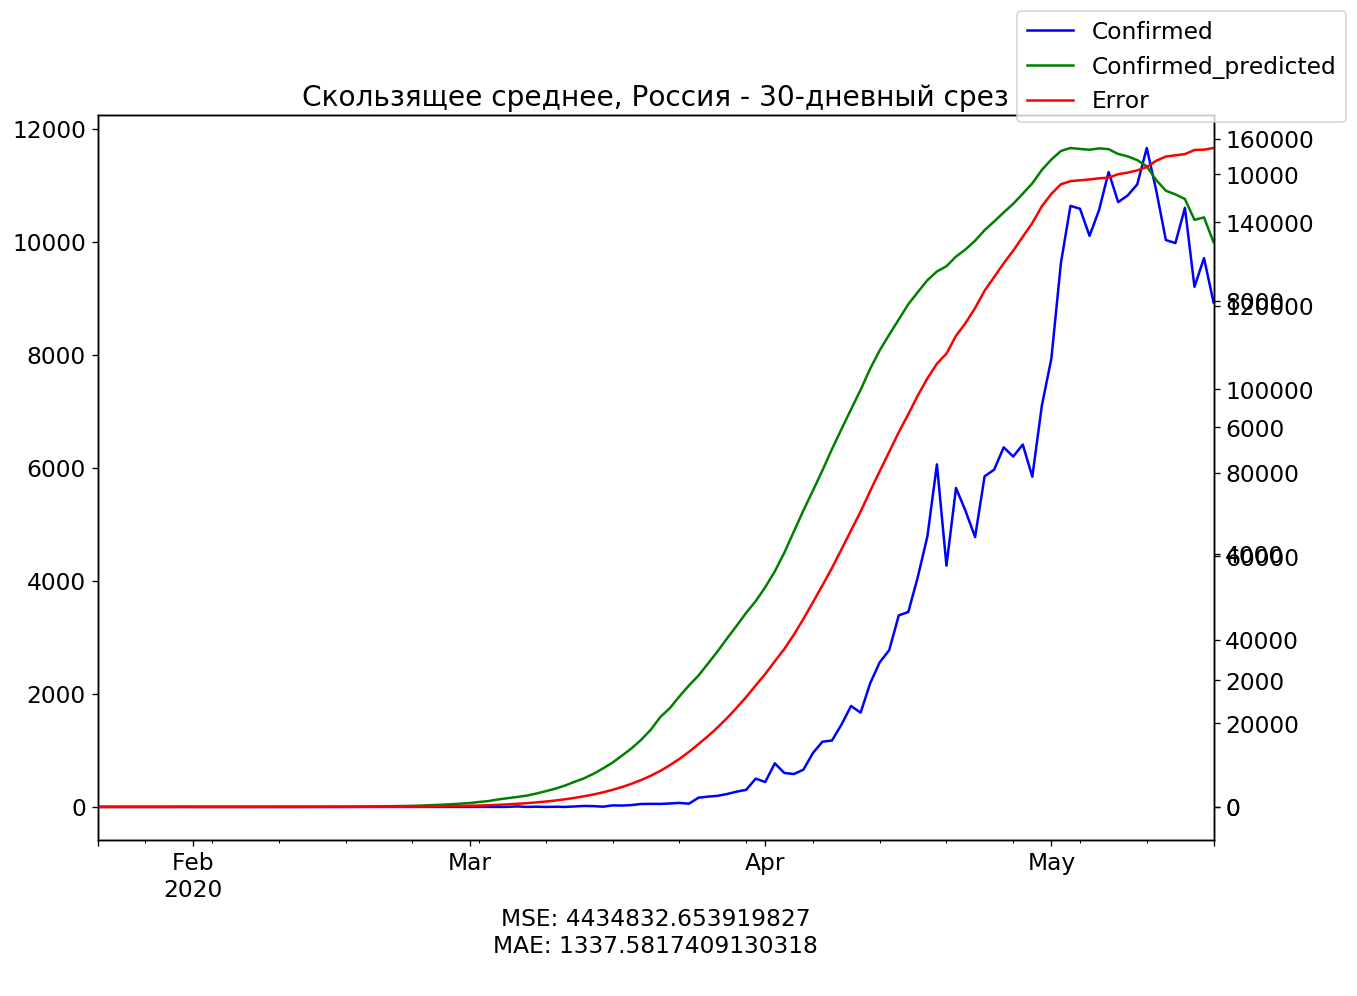

In [30]:
new_russia_df = moving_average_df(russia_increase, 30)
mean_error = mean_squared_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Скользящее среднее, Россия - 30-дневный срез", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

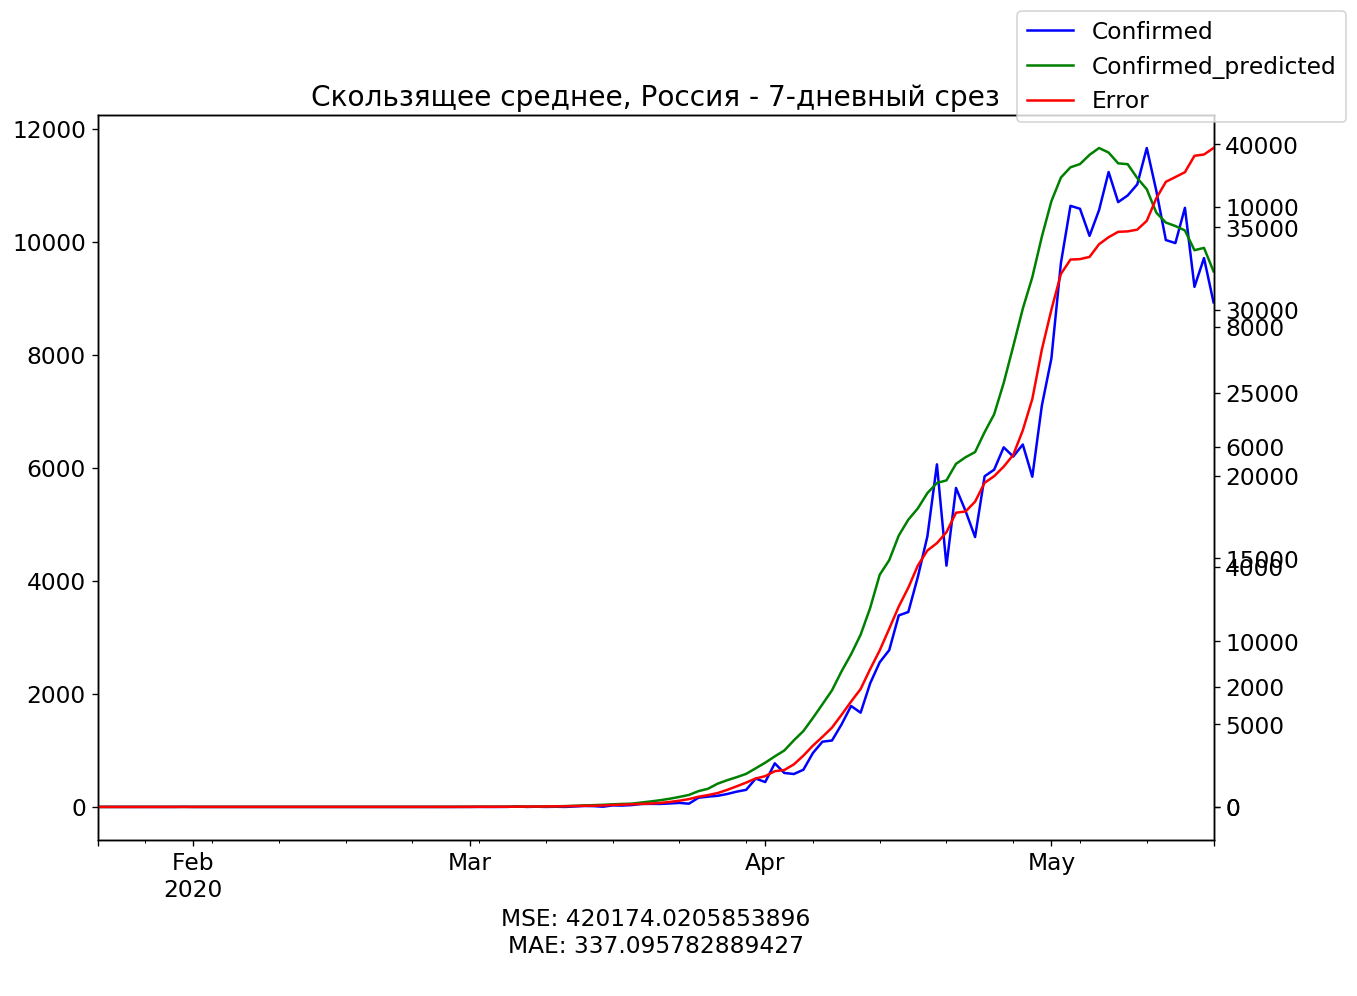

In [31]:
new_russia_df = moving_average_df(russia_increase, 7)
mean_error = mean_squared_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Скользящее среднее, Россия - 7-дневный срез", mean_error, absolute_error)

Судя по исходным данным (синий график по подтвержденным случаям) и данным, полученным по скользящему среднему по срезу за 30 дней, метод скользящего среднего не самый лучший вариант, для анализа по такому малому количеству данных, но определенный тренд по росту и снижению заболевших он уже показывает в очень грубой форме. Если же сделать срез по неделям, то выйдет более правдоподобный прогноз, но все же еще немного грубый. Попробуем посмотреть, как это будет выглядеть на данных не по России, а по Китаю 

<Figure size 1440x960 with 0 Axes>

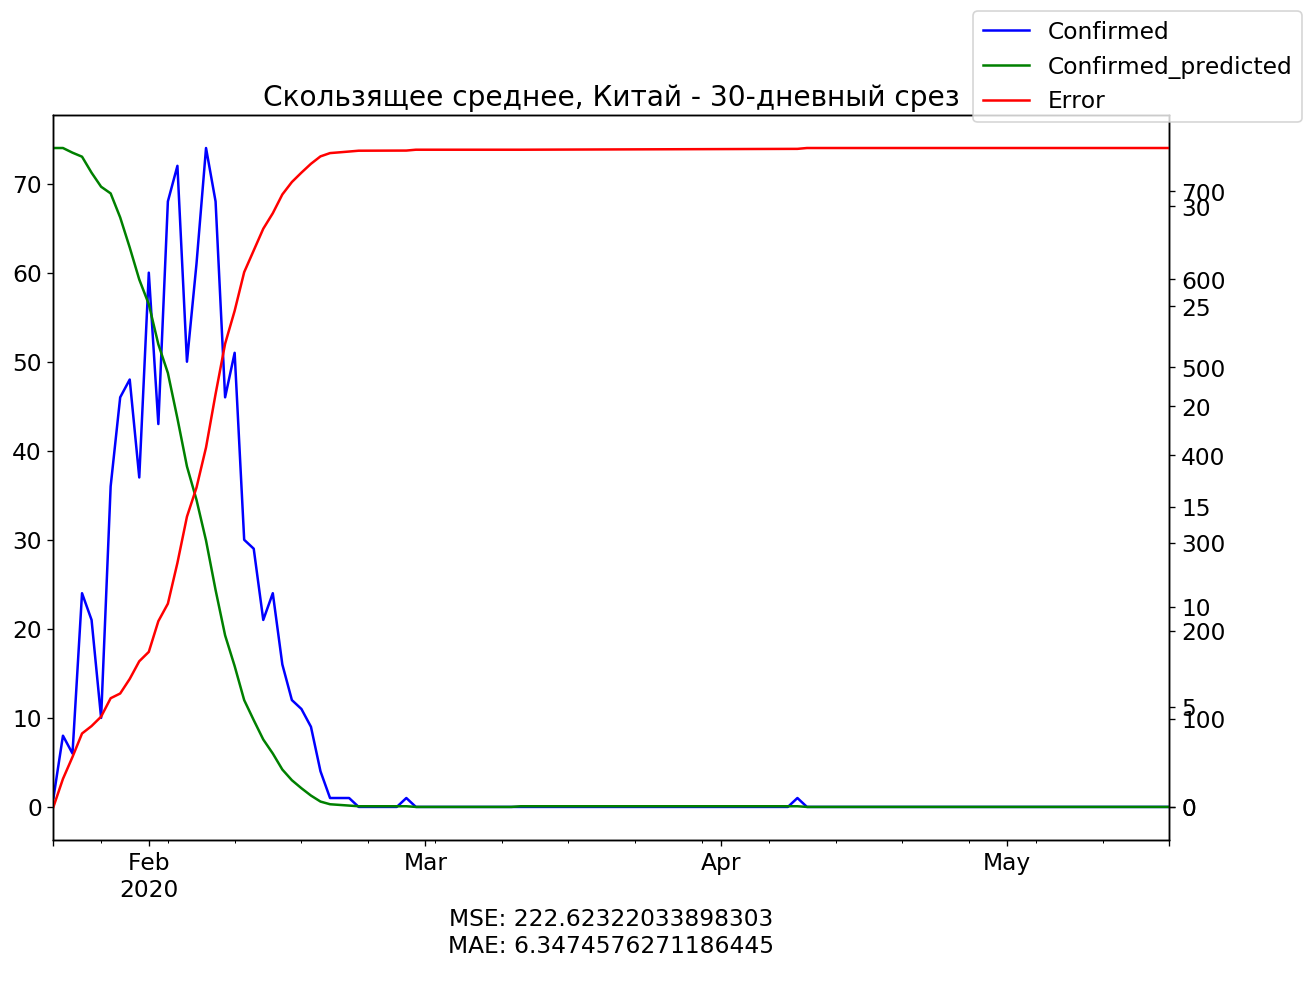

In [32]:
new_china_df = moving_average_df(china_increase, 30)
mean_error = mean_squared_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, "Скользящее среднее, Китай - 30-дневный срез", mean_error, absolute_error)

По 30 дневному срезу алгоритм показал неправильный результат, идущий на спад, хотя реальные данные показывают рост с двумя пиками.

<Figure size 1440x960 with 0 Axes>

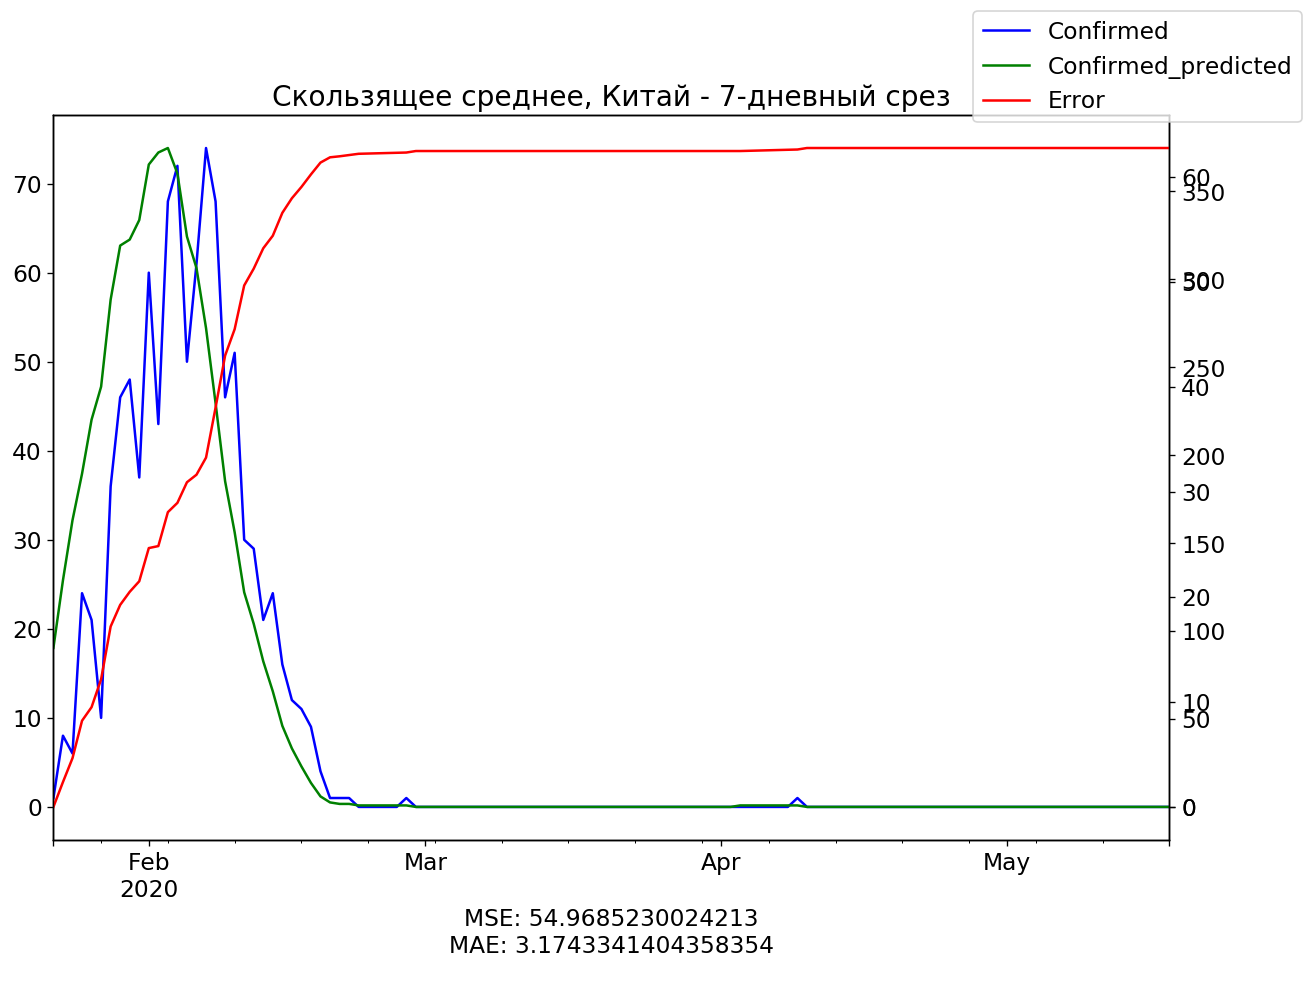

In [33]:
new_china_df = moving_average_df(china_increase, 7)
mean_error = mean_squared_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, "Скользящее среднее, Китай - 7-дневный срез", mean_error, absolute_error)

Здесь же мы видем менее правильный график, но можно заметить, что по более пологому графику заболевших скользящее среднее аккуратно отреагировало на всплеск смертей на 7-ми дневном срезе.

Все же приходим к выводу, что использование скользящего среднего для очень короткого периода не самая лучшая идея, поскольку этот алгоритм крайне наивен и предполагает что прошлые данные дают реальную основу для следующего замера не используя какие-либо факторы, которые бы влияли на прогнозируемый результат и коррелирующие с реальными данными.

#### Линейная модель авторегрессии

Основная формула для линейной модели авторегрессии выглядит следующим образом:

$\hat{y}_{t+1}(w) = \sum_{j=1}^{n}w_jy_{t-j+1}, w \in \mathbb{R}^n$

где n - это количество предыдущих наблюдений ряда.

Функционал квадрата ошибки:

$Q_t(w, X^\mathbb{l}) = \sum_{i=n}^{t}(\hat{y}_i(w) - y_i)^2 = \vert\vert{Fw - y}\vert\vert^2 \rightarrow \min_w$

По сути это является улучшеннием метода скользящего среднего, имеющего веса на каждой итерации. Также этот метод называется взвешенная средняя. Внутри каждой итерации для наблюдений придаются различные веса, в сумме дающие 1, но при этом последним значением обычно присваивается наибольший вес. 

In [34]:
def weighted_average_step(series, weights):
    result = 0.0
    weights.reverse()
    weight_length = len(weights)
    for n in range(weight_length):
        result += series[-n-1] * weights[n]
    return result

def weighted_average(series, weights):
    weight_length = len(weights)
    length = len(series)
    average_length = length - weight_length
    res = []
    for i in range(average_length):
        res.append(weighted_average_step(np.array(series[i:i + weight_length]), weights))
    for i in range(average_length, length):
        res.append(weighted_average_step(np.array(series[i-weight_length:i]), weights))
    return res

def SE(y, y_pred):
    error = []
    prev_error = 0
    for i in range(len(y)):
        for n in range(i):
            prev_error += np.square(y_pred[n] - y[n])
        error.append(prev_error)
        prev_error = 0
    return error

def weighted_average_df(df, weights):
    new_df = df.copy()
    new_df['Confirmed_predicted'] = weighted_average(df['Confirmed'], weights)
    new_df['Error'] = SE(new_df['Confirmed'], new_df['Confirmed_predicted'])
    return new_df

<Figure size 1440x960 with 0 Axes>

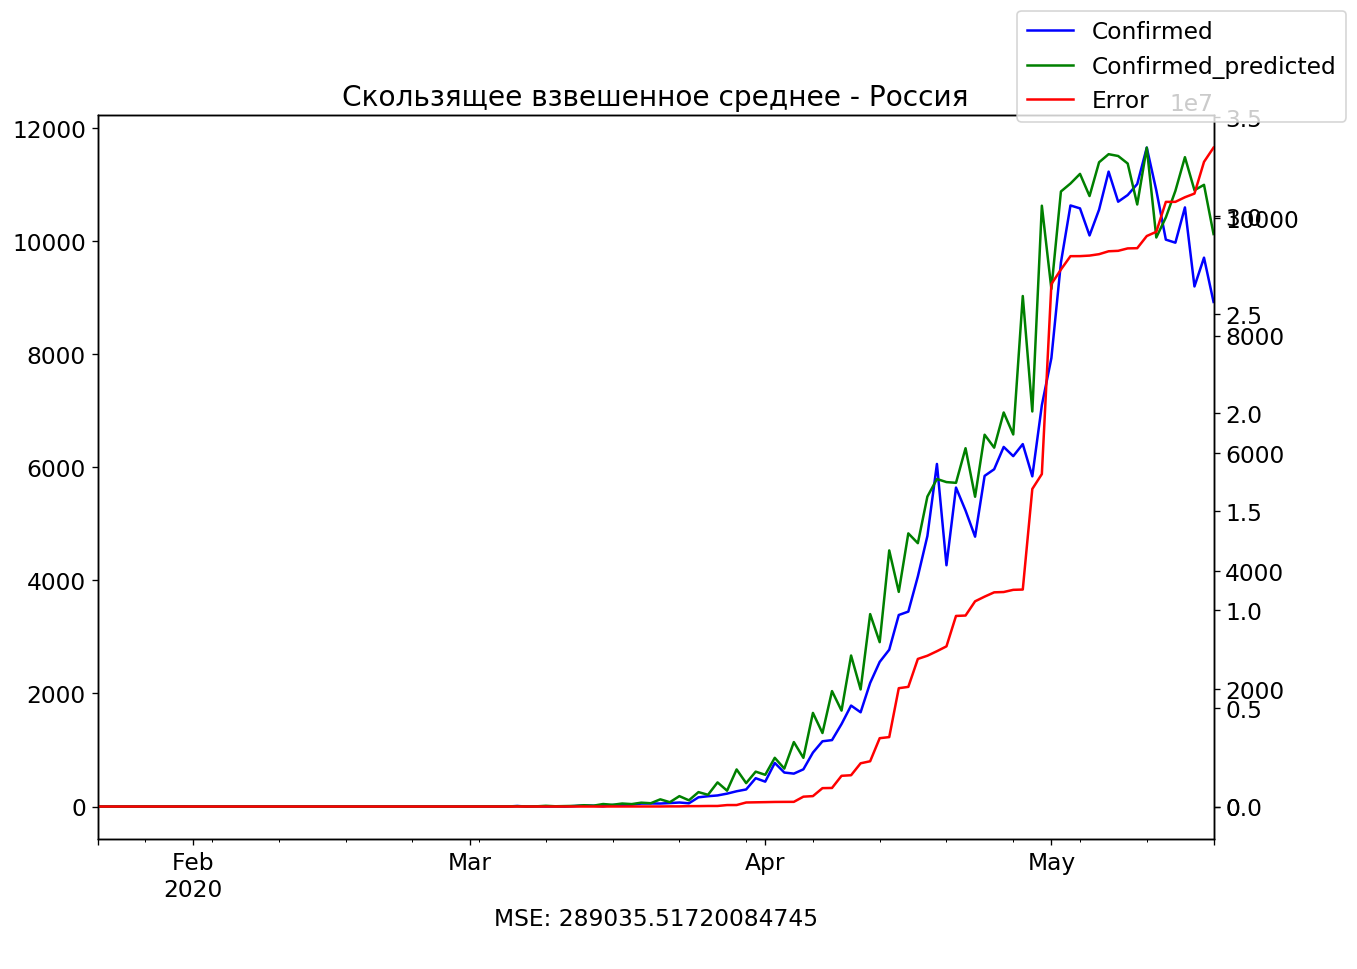

In [35]:
new_russia_df = weighted_average_df(russia_increase, [0.6, 0.2, 0.1, 0.07, 0.03])
error = mean_squared_error(russia_increase['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Скользящее взвешенное среднее - Россия", 
      mean_error=error)

В результате среднего взвешенного мы можем наблюдать неплохое подобие графика и примерно похожую тенденцию, которая потенциально может спрогнозировать следующие значения нашего изначального ряда. Сравним теперь с другими весами и на примере Китая и США

<Figure size 1440x960 with 0 Axes>

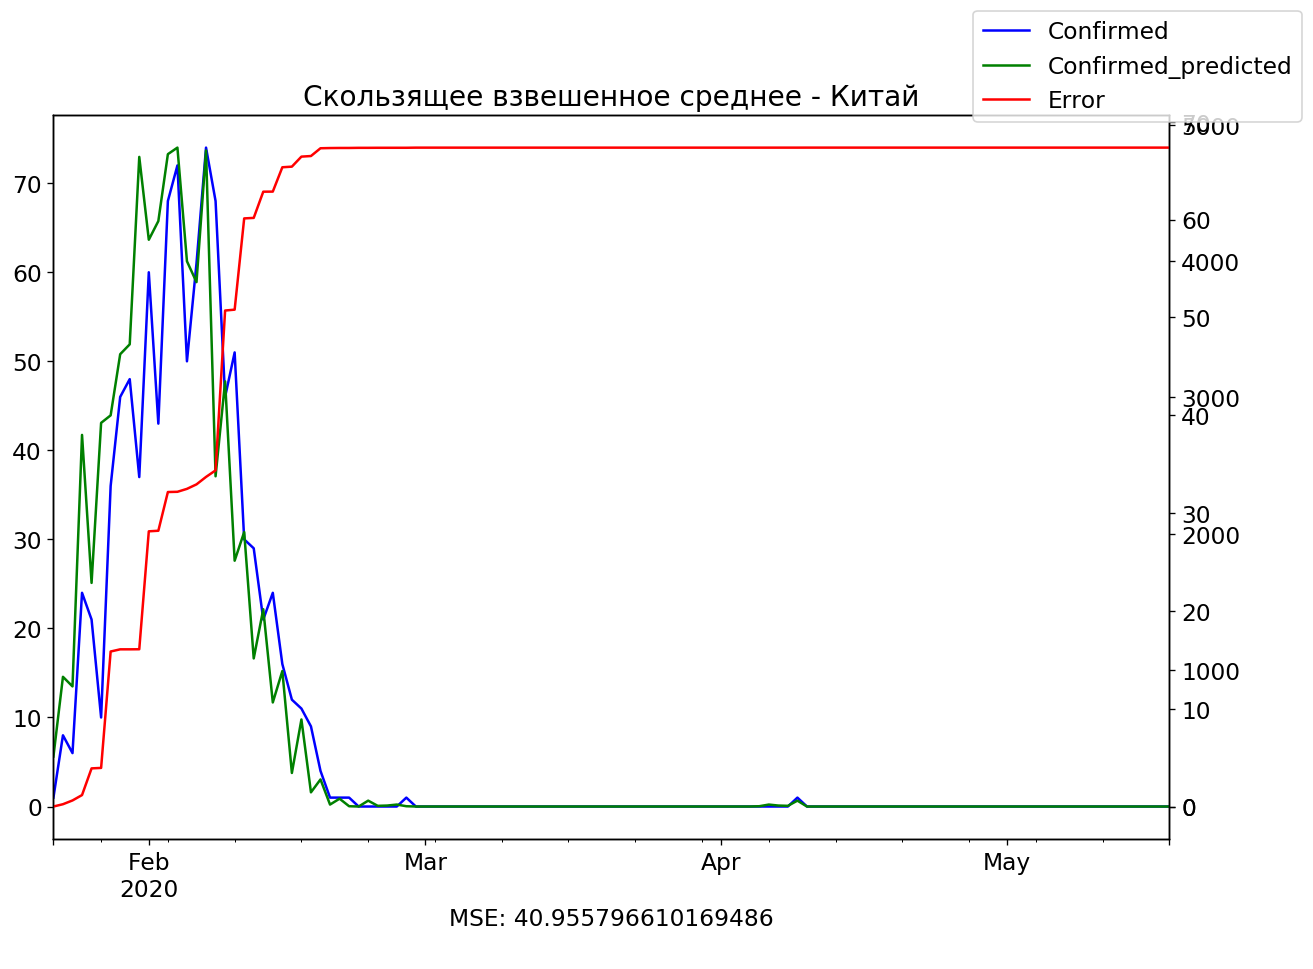

In [36]:
new_china_df = weighted_average_df(china_increase, [0.6, 0.2, 0.1, 0.07, 0.03])
error = mean_squared_error(china_increase['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, "Скользящее взвешенное среднее - Китай", mean_error=error)

<Figure size 1440x960 with 0 Axes>

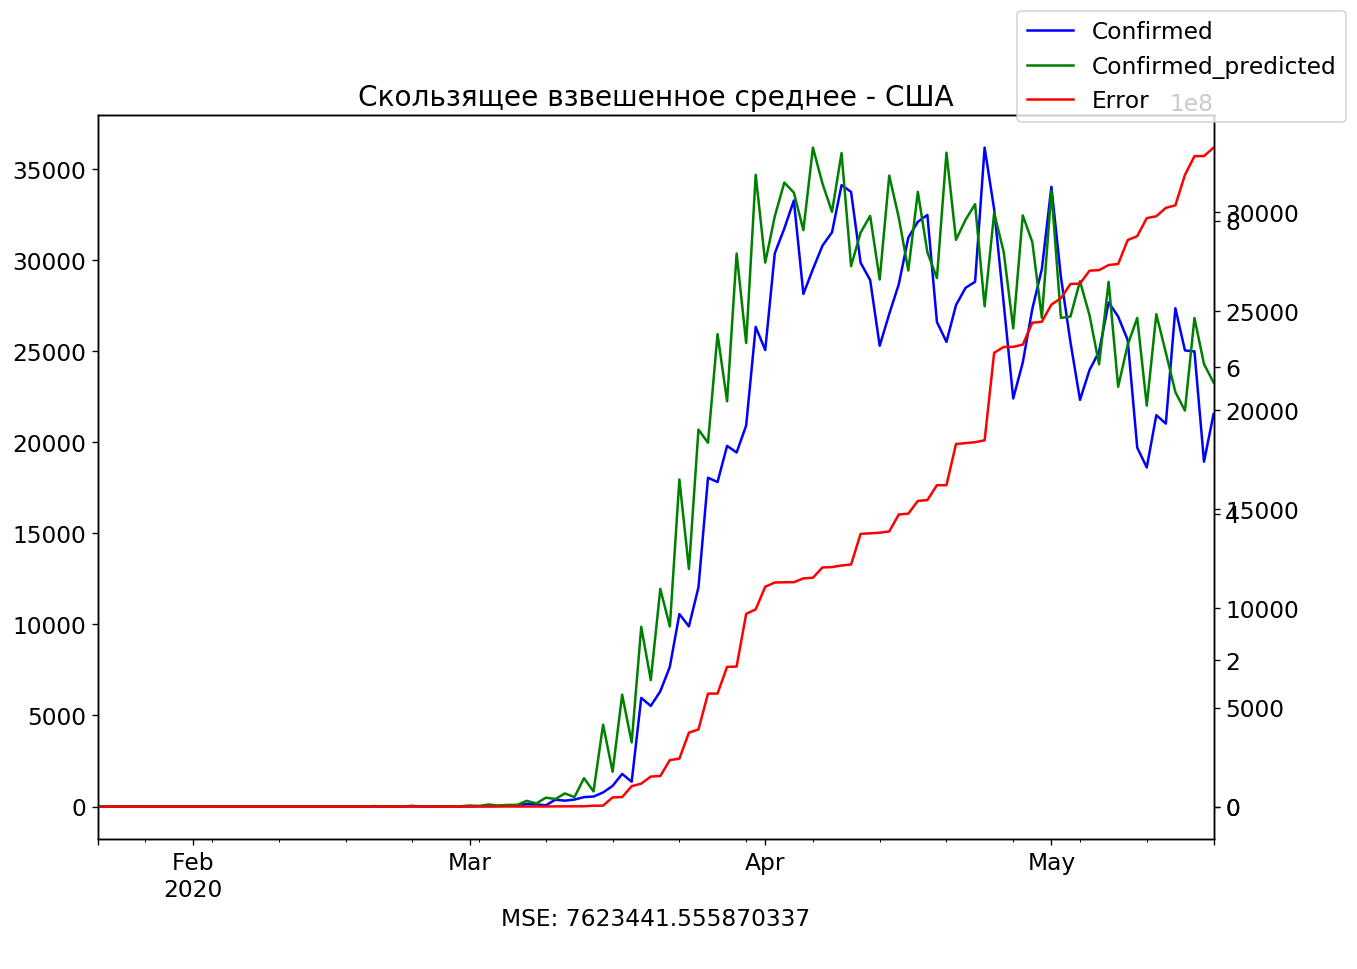

In [37]:
new_us_df = weighted_average_df(us_increase, [0.6, 0.2, 0.1, 0.07, 0.03])
error = mean_squared_error(us_increase['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Скользящее взвешенное среднее - США", mean_error=error)

На данных графиках видно, что точность прогноза выросла для заболевших. Благодаря правильно подобранным весам можно сделать достаточно точный прогноз. 

#### Экпоненциальное сглаживание

Экспоненциальное сглаживание - метод математического преобразования, используемый при прогнозировании рядов. 

$s_t = \begin{cases} c_1, & \mbox{if } t=1 \\ s_{t-1}+\alpha\dot(c_t-s_{t-1}), & \mbox{if } t>1 \end{cases}$,

где $s_t$ - сглаженный ряд, $c_t$ - исходный ряд, $\alpha$ - коэффициент сглаживания, который выбирается априори от 0 до 1

Пусть $X = \{x_1, \dots, x_T\}$ - временной ряд. Экспоненциальное сглаживание ряда осуществляется по рекуррентной формуле:

$\hat{y}_{t+1} = \hat{y}_t + \alpha(y_t - \hat{y}_t)$ 

или в таком виде:

$S_t = \alpha x_t + (1-\alpha)S_{t-1}, \alpha \in (0,1)$

Чем меньше $\alpha$, тем в большей степени фильтруются, подавляются, колебания исходного ряда и шума. Если последовательно использовать рекуррентное это соотношение, то экспоненциальную среднюю S_t можно выразит через значения временного ряда X:

$S_t = \alpha x_t + (1 - \alpha)(\alpha x_{t-1} + (1-\alpha)S_{t-2}) = \dots = \alpha \sum_{i=0}^{t-1}(1 - \alpha)^ix_{t-i} + (1-\alpha)^t S_0$

Если к моменту начала сглаживания существуют более ранние данные, то в качестве начального значения $S_0$ можно использовать арифметическую среднюю всех имеющихся данных или какой-то их части. 

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модальным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное значение.

In [38]:
def exp_smooth(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def exp_smooth_df(df, alpha):
    new_df = df.copy()
    new_df['Confirmed_predicted'] = exp_smooth(df['Confirmed'], alpha)
    new_df['Error'] = SE(new_df['Confirmed'], new_df['Confirmed_predicted'])
    return new_df

В качестве наблюдения возьмем несколько $\alpha$, равные 0.5, 0.3, 0.05 и 0.03

<Figure size 1440x960 with 0 Axes>

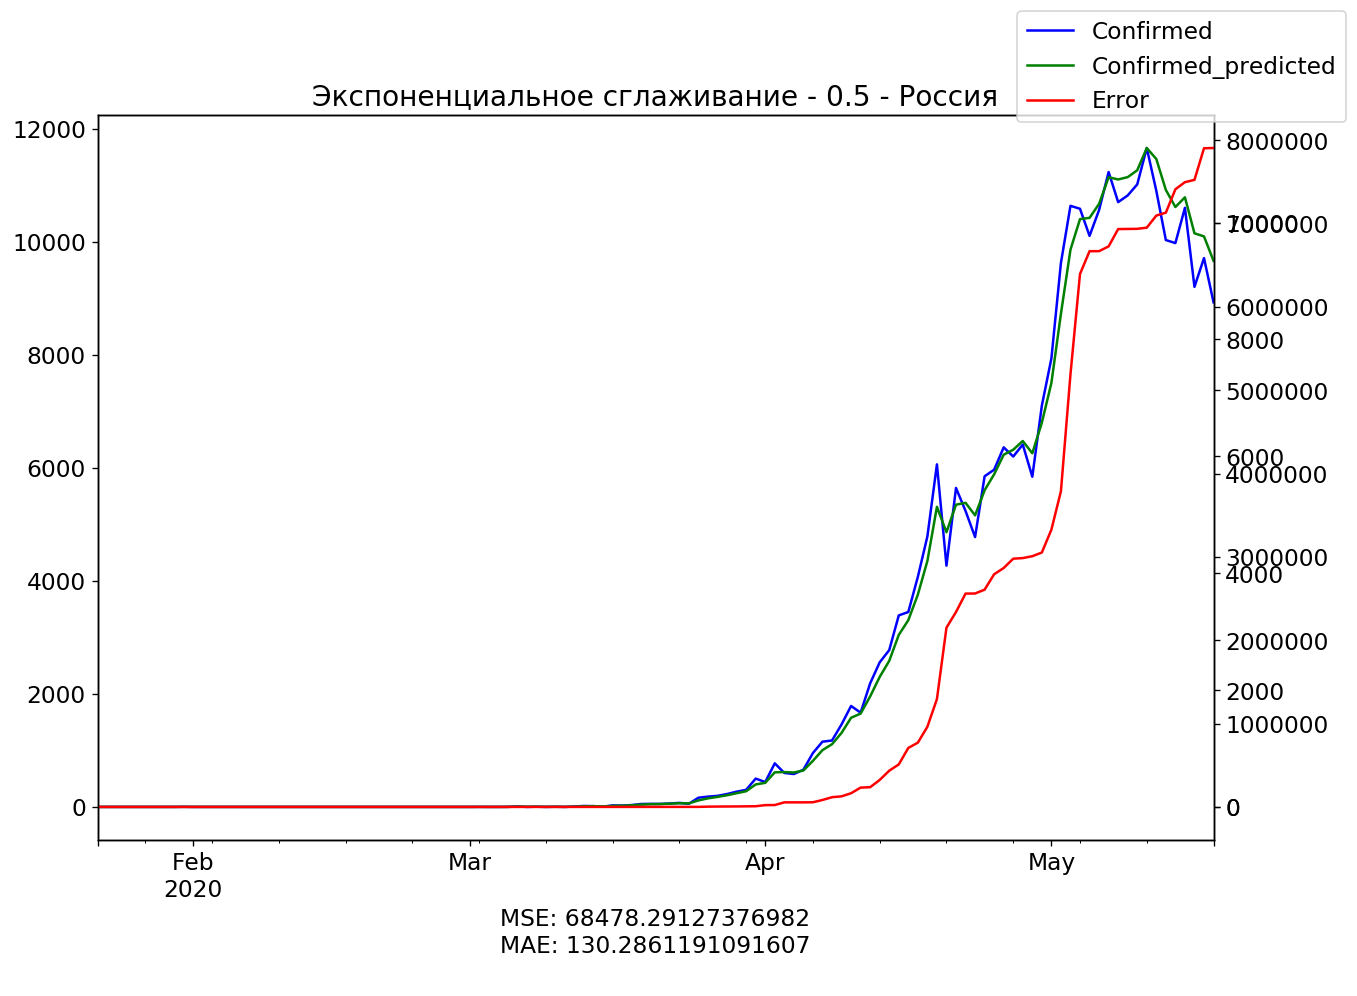

In [39]:
new_russia_df = exp_smooth_df(russia_increase, 0.5)
mean_error = mean_squared_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Экспоненциальное сглаживание - 0.5 - Россия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

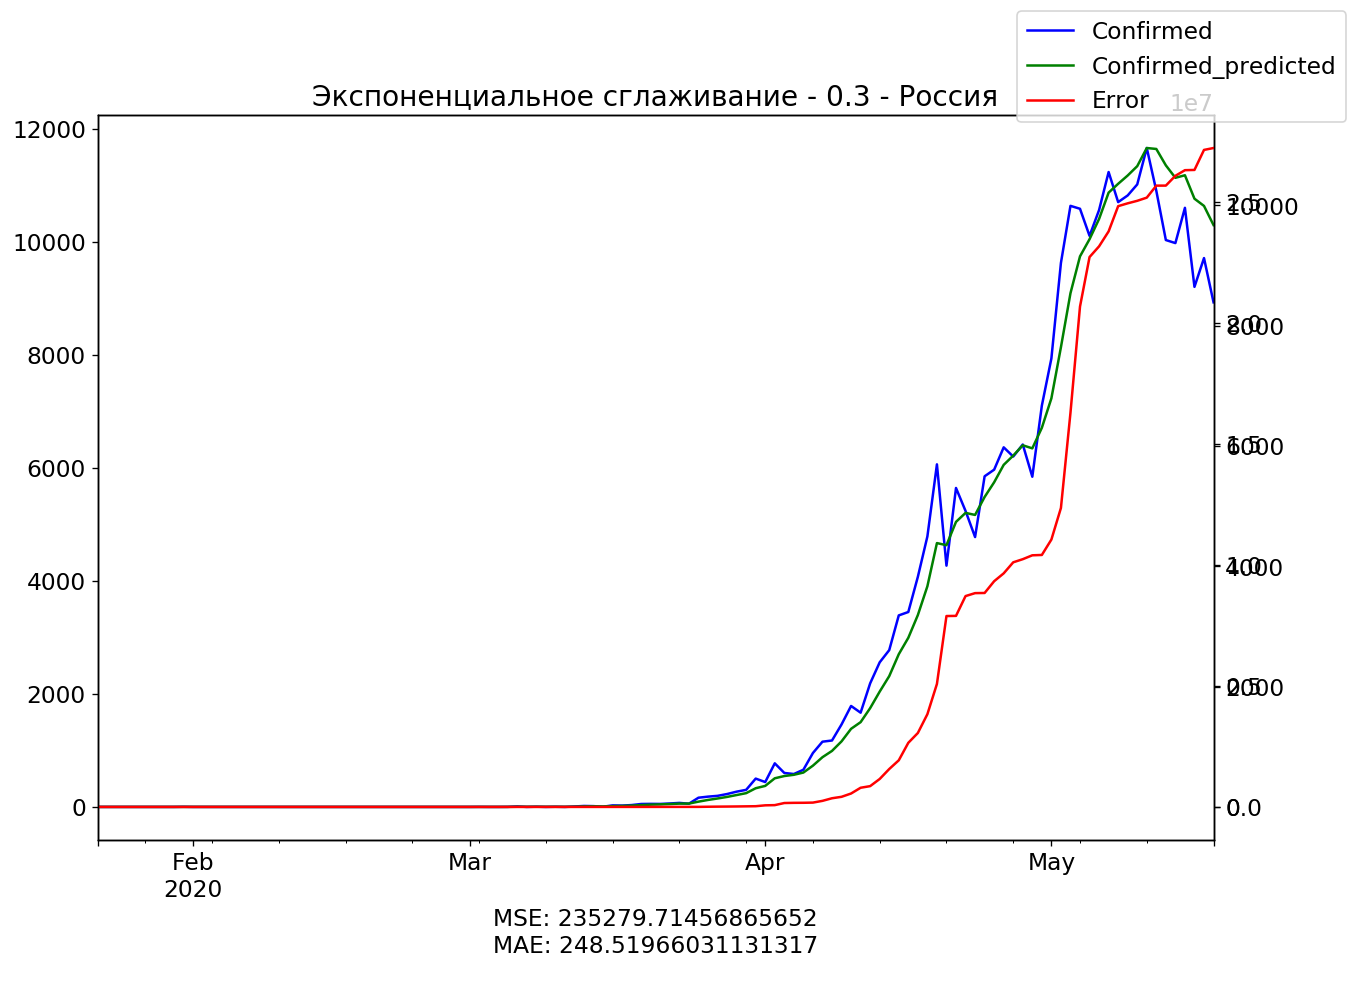

In [40]:
new_russia_df = exp_smooth_df(russia_increase, 0.3)
mean_error = mean_squared_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Экспоненциальное сглаживание - 0.3 - Россия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

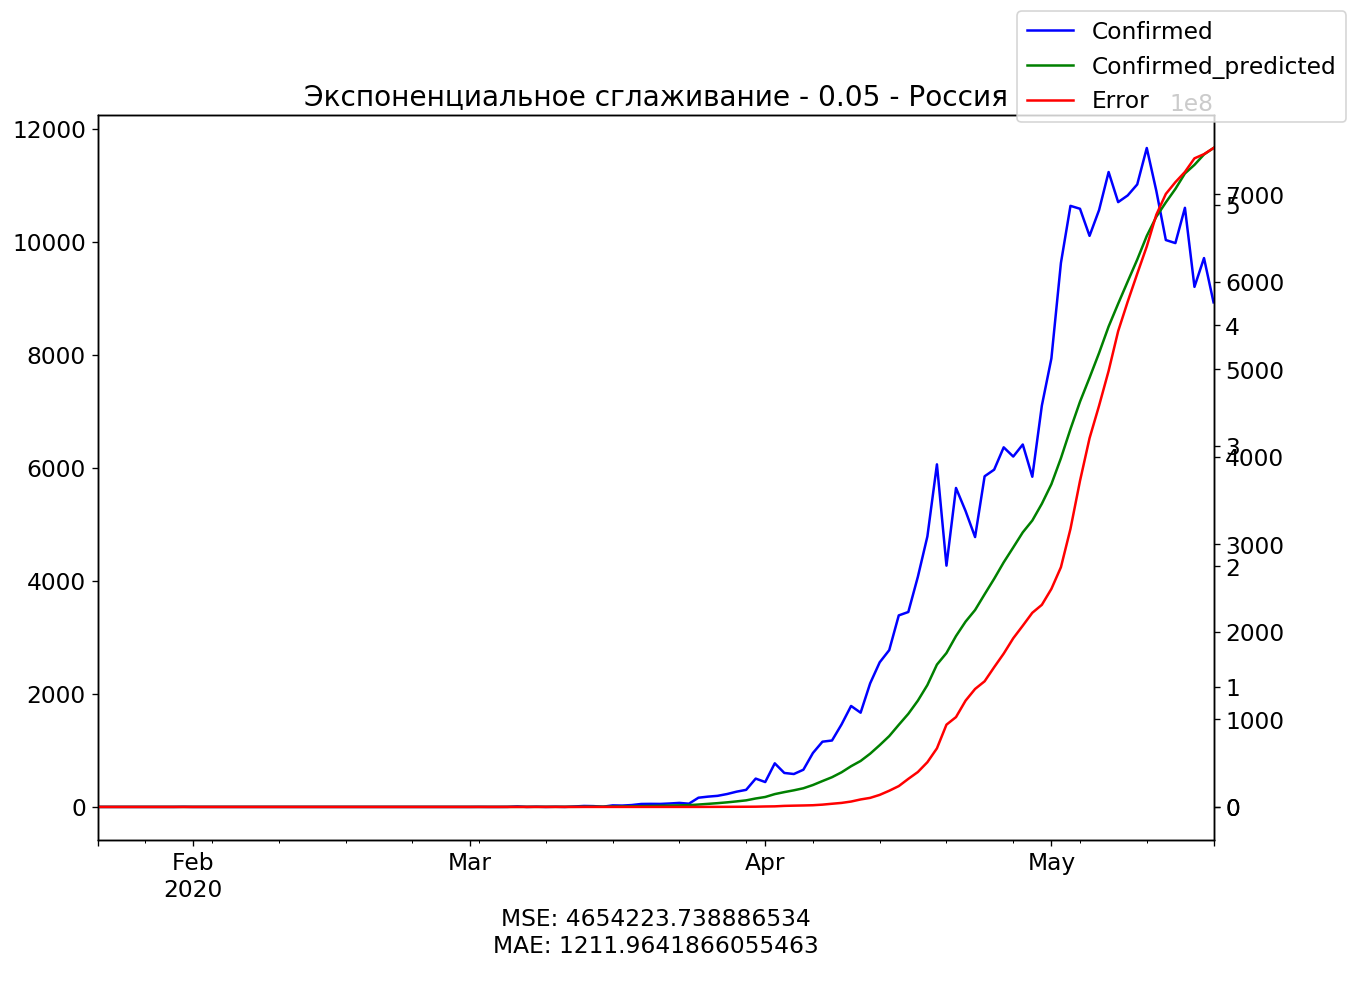

In [41]:
new_russia_df = exp_smooth_df(russia_increase, 0.05)
mean_error = mean_squared_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Экспоненциальное сглаживание - 0.05 - Россия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

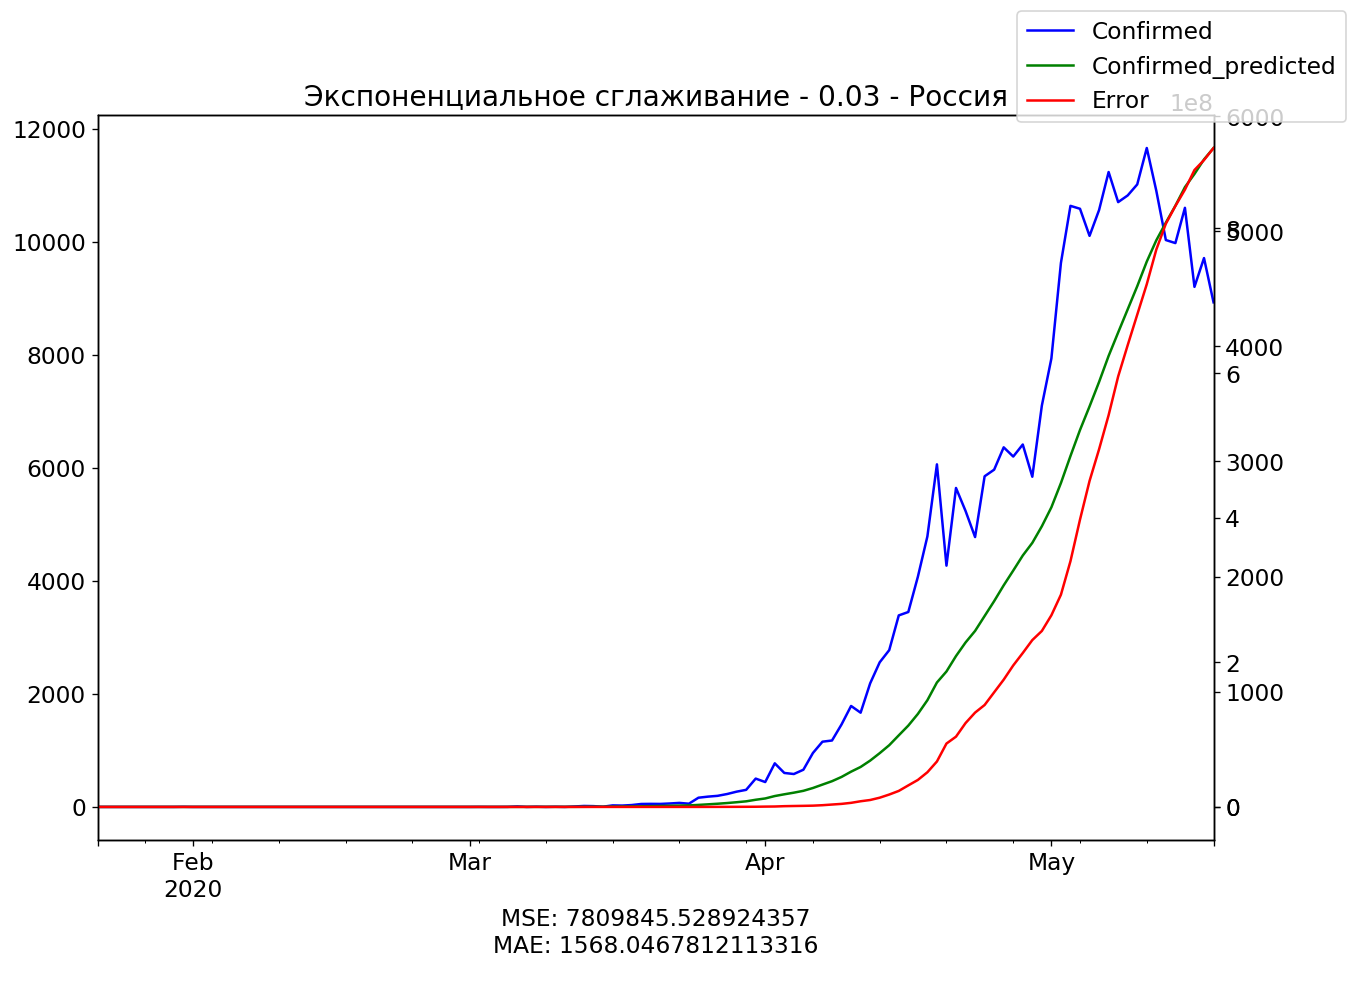

In [42]:
new_russia_df = exp_smooth_df(russia_increase, 0.03)
mean_error = mean_squared_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, "Экспоненциальное сглаживание - 0.03 - Россия", mean_error, absolute_error)

##### Экспоненциальное сглаживание - Китай

<Figure size 1440x960 with 0 Axes>

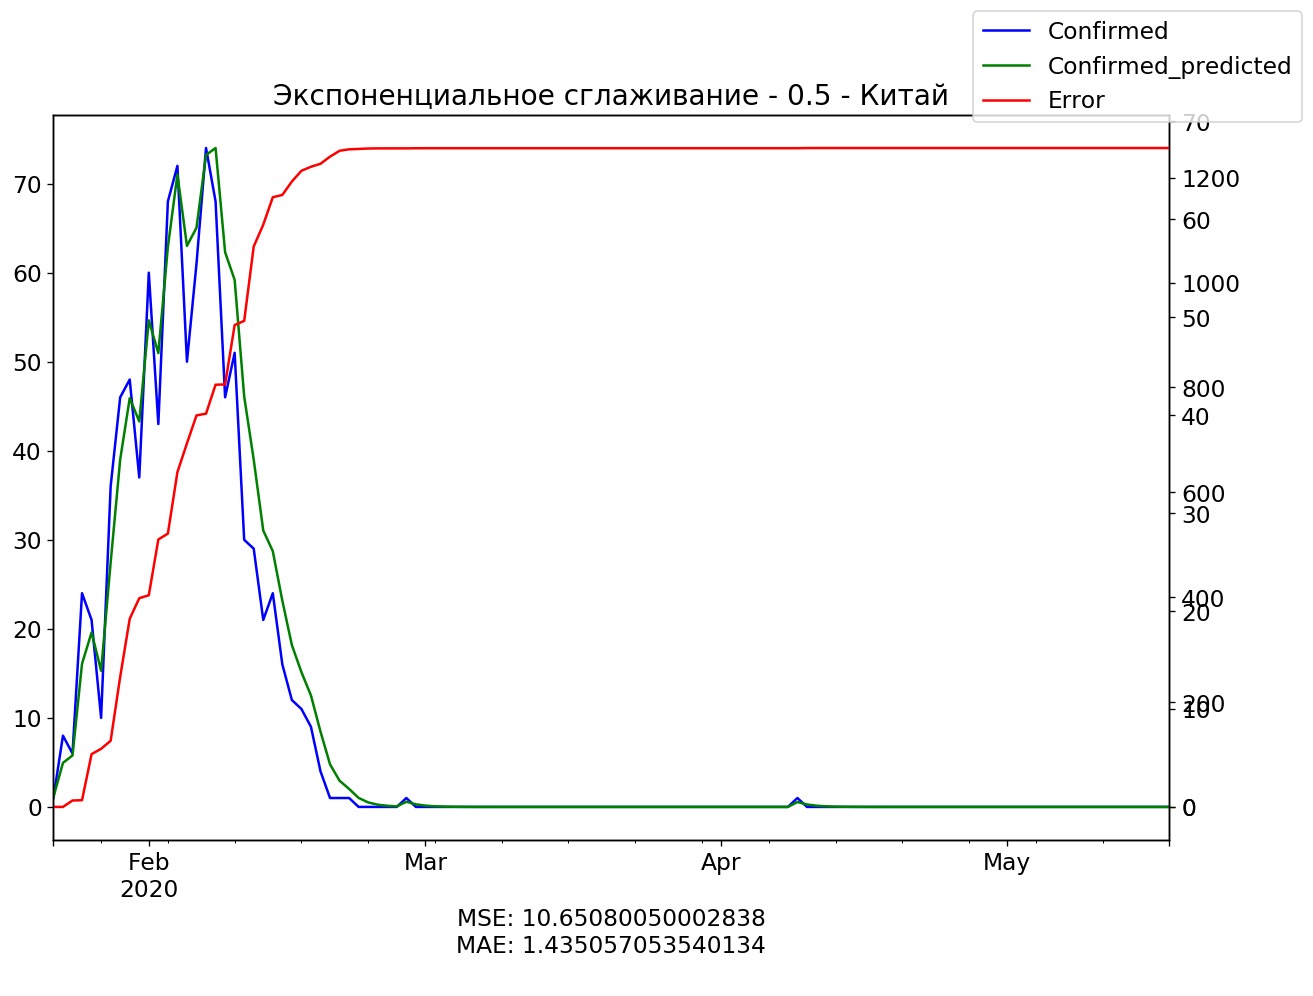

In [43]:
new_china_df = exp_smooth_df(china_increase, 0.5)
mean_error = mean_squared_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, "Экспоненциальное сглаживание - 0.5 - Китай", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

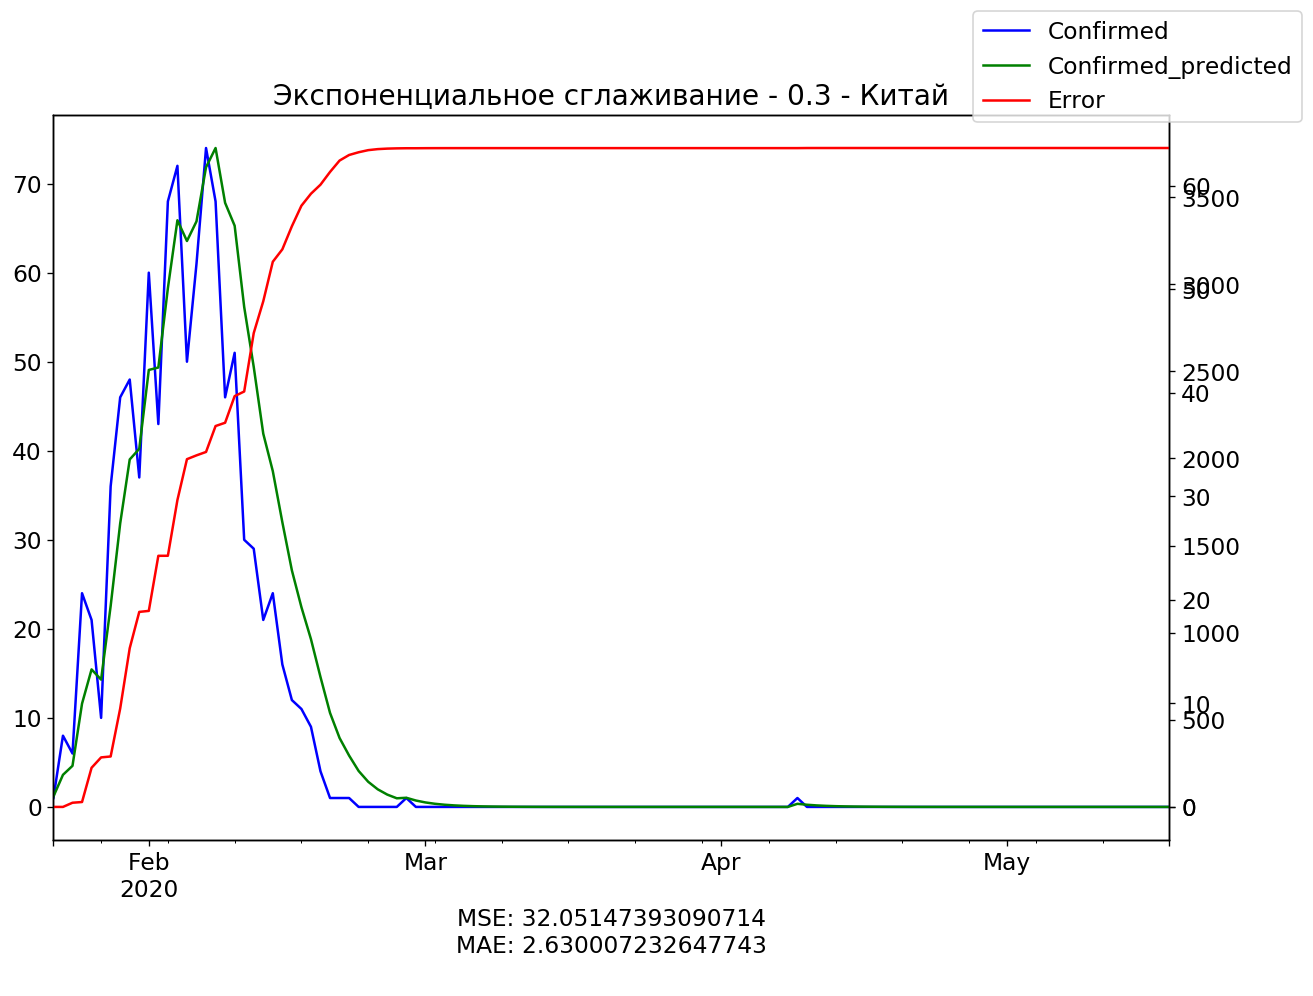

In [44]:
new_china_df = exp_smooth_df(china_increase, 0.3)
mean_error = mean_squared_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, "Экспоненциальное сглаживание - 0.3 - Китай", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

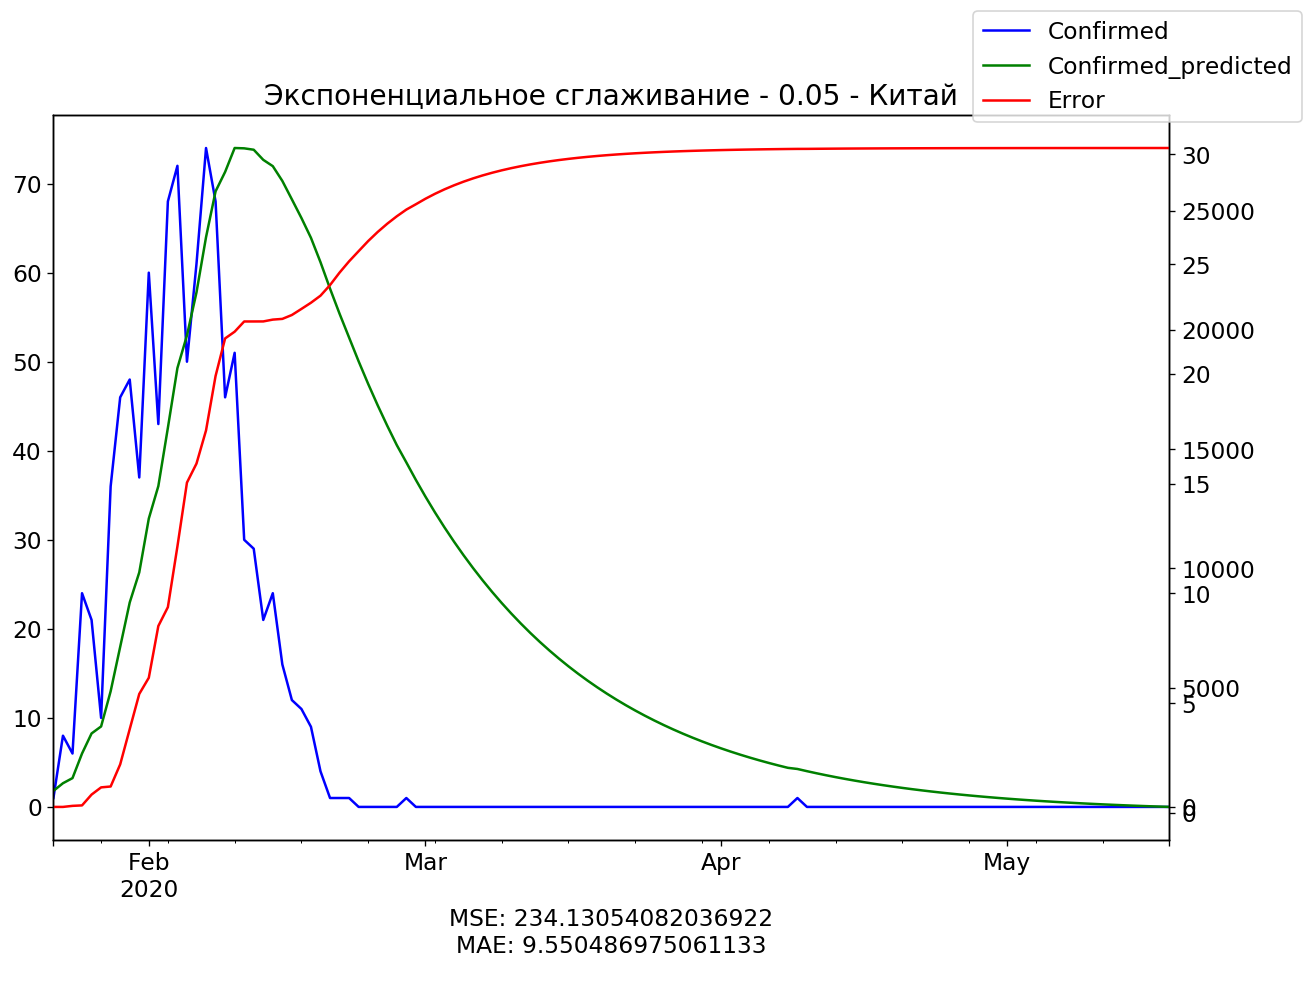

In [45]:
new_china_df = exp_smooth_df(china_increase, 0.05)
mean_error = mean_squared_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, "Экспоненциальное сглаживание - 0.05 - Китай", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

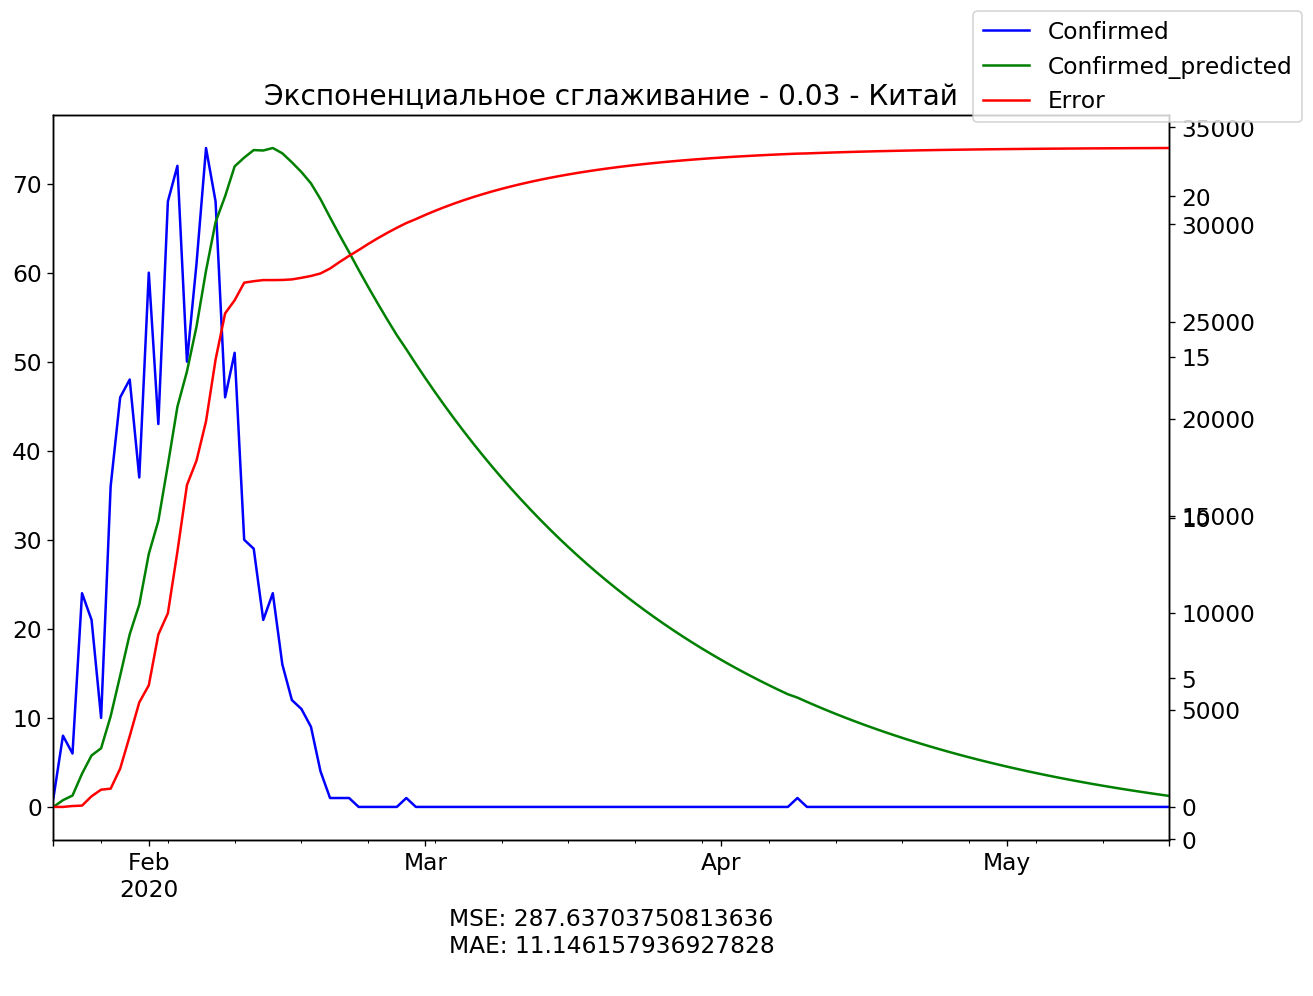

In [46]:
new_china_df = exp_smooth_df(china_increase, 0.03)
mean_error = mean_squared_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, "Экспоненциальное сглаживание - 0.03 - Китай", mean_error, absolute_error)

По графикам мы видим, что при понижении коэффициента $\alpha$ мы все больше забываем прошлые значения и график становится более пологим и гладким. Из этого можно сделать вывод, что при понижении параметра сглаживания мы получаем более гладкие, но менее точные данные, которые не смогут показать более точный прогноз, но смогут выявить более точно следующую волну выброса заболеваний. При этом, используя эмпирическое правило, параметр $\alpha \in (0, 0.3)$ показывает, что ряд стационарен и сглаживание работает. При $\alpha \in (0.3, 1)$ ряд нестационарен и нужна модель тренда.


#### Модель Хольта

Теперь попробуем использовать более точную модель двойного экспоненциального сглаживания. Здесь нам поможет разбиение ряда на две составляющие - уровень и тренд

Уровень мы предскажем методом, описанным выше, и такой же метод мы применим к тренду, наивно полагая, что будущее направление изменения ряда зависит от взвешеных предыдущих значений. 

$\iota_x = \alpha y_x + (1 - \alpha)(\iota_{x-1} + b_{x-1})$

$b_x = \beta(\iota_x - \iota_{x-1}) + (1 - \beta)b_{x-1}$

$\hat{y}_{x+1} = \iota_x + b_x$

Также этот метд называется Модель Хольта

In [47]:
def holt_exp_smooth(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def holt_df(df, alpha, beta):
    new_df = df.copy()
    conf = holt_exp_smooth(df['Confirmed'], alpha, beta)
    death = holt_exp_smooth(df['Deaths'], alpha, beta)
    new_df = new_df.append({'Date': pd.to_datetime('5/19/20', format="%m/%d/%y"),'Confirmed': df['Confirmed'].to_numpy()[-1], 'Deaths': df['Deaths'].to_numpy()[-1]},ignore_index=True)
    new_df['Confirmed_predicted'] = conf
    new_df['Error'] = SE(new_df['Confirmed'] , new_df['Confirmed_predicted'] )
    return new_df

Для следующих наблюдений мы возьмем коэффициенты для $\alpha$ и $\beta$ -  0.5, 0.3, 0.05, 0.03. Данные возьмем по Италии и США. В качестве следующего значения мы возьмем предыдущее значение за 18 мая.

###### США

<Figure size 1440x960 with 0 Axes>

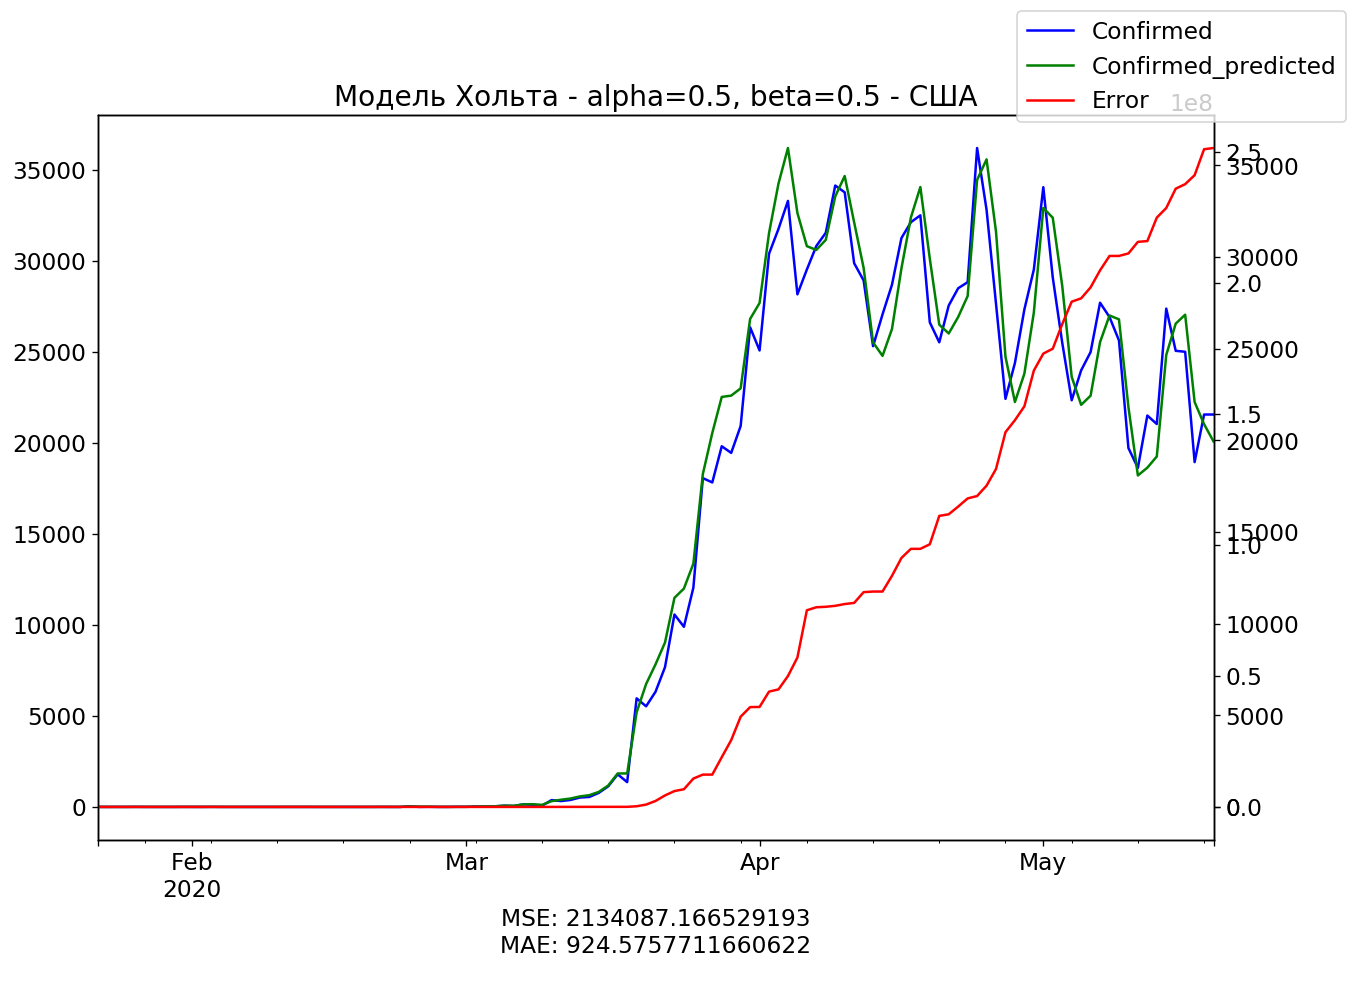

In [48]:
new_us_df = holt_df(us_increase, 0.5, 0.5)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.5, beta=0.5 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

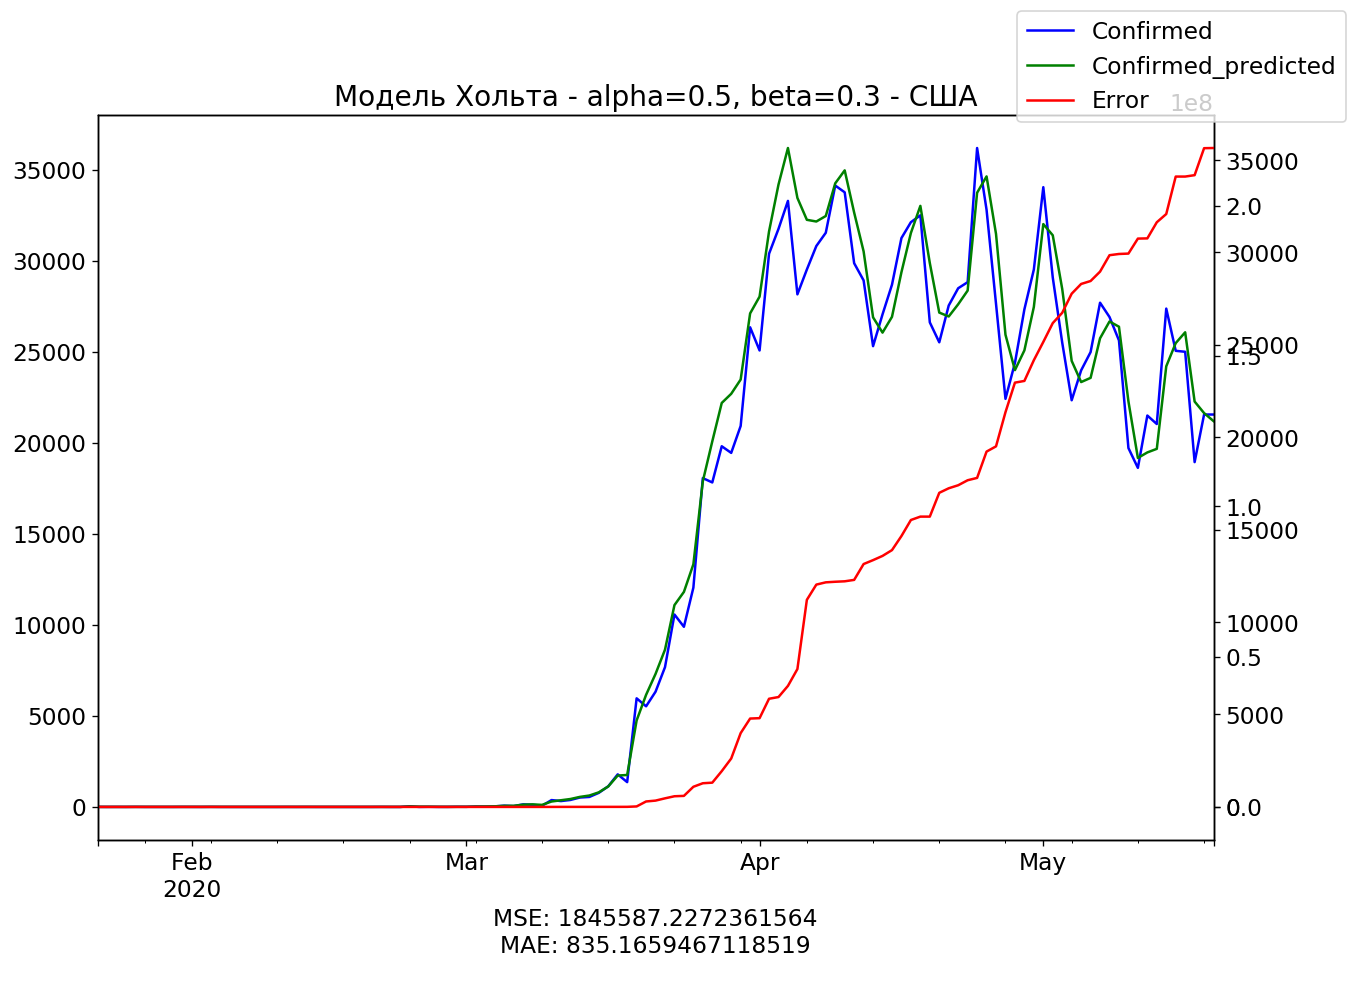

In [49]:
new_us_df = holt_df(us_increase, 0.5, 0.3)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.5, beta=0.3 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

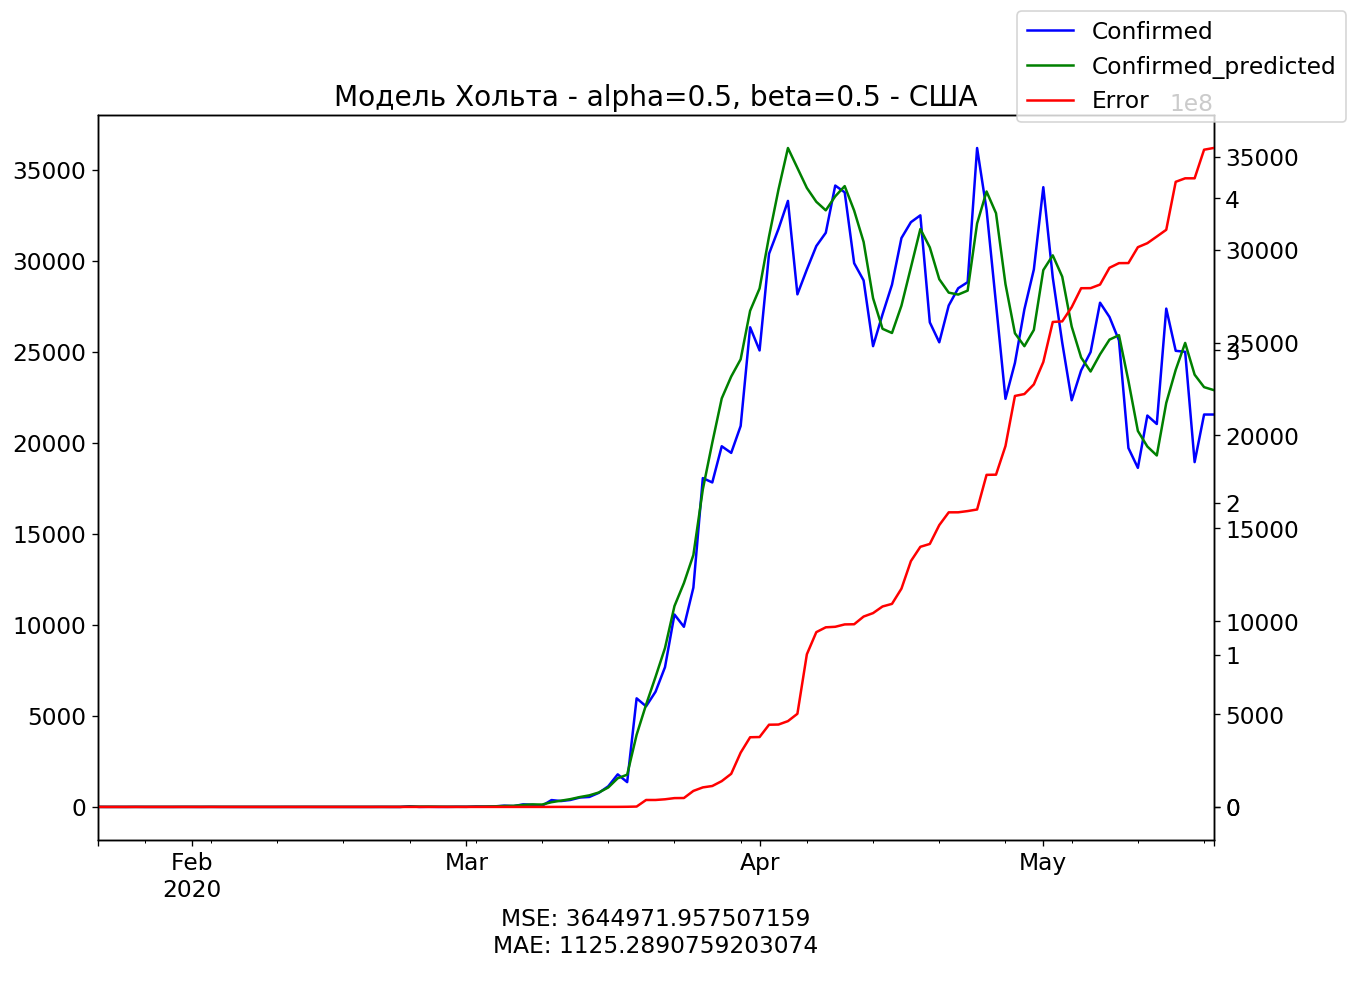

In [50]:
new_us_df = holt_df(us_increase, 0.3, 0.5)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.5, beta=0.5 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

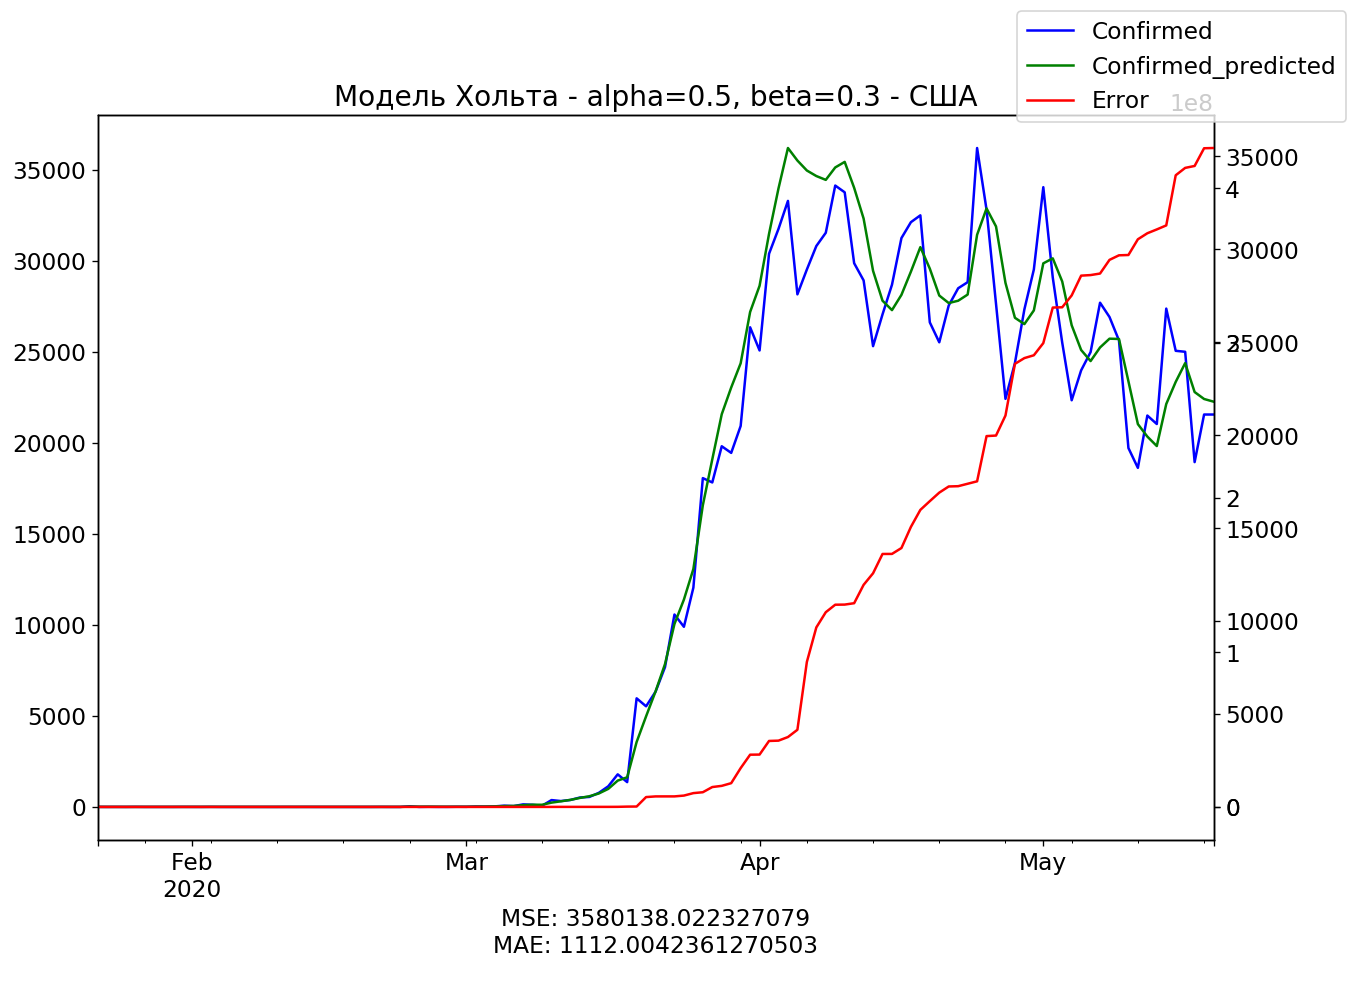

In [51]:
new_us_df = holt_df(us_increase, 0.3, 0.3)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.5, beta=0.3 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

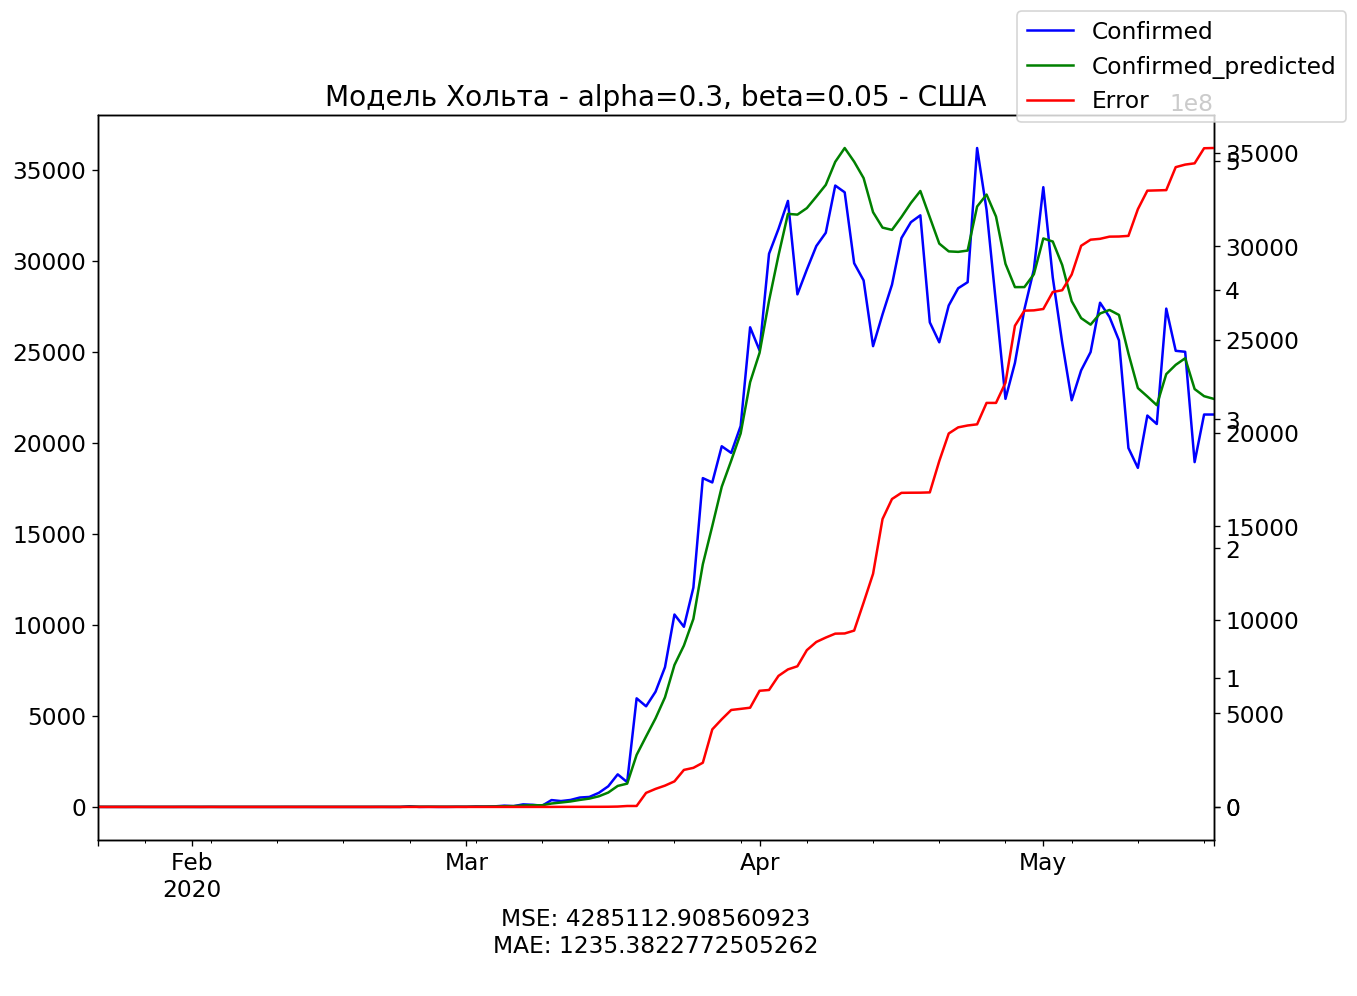

In [52]:
new_us_df = holt_df(us_increase, 0.3, 0.05)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.3, beta=0.05 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

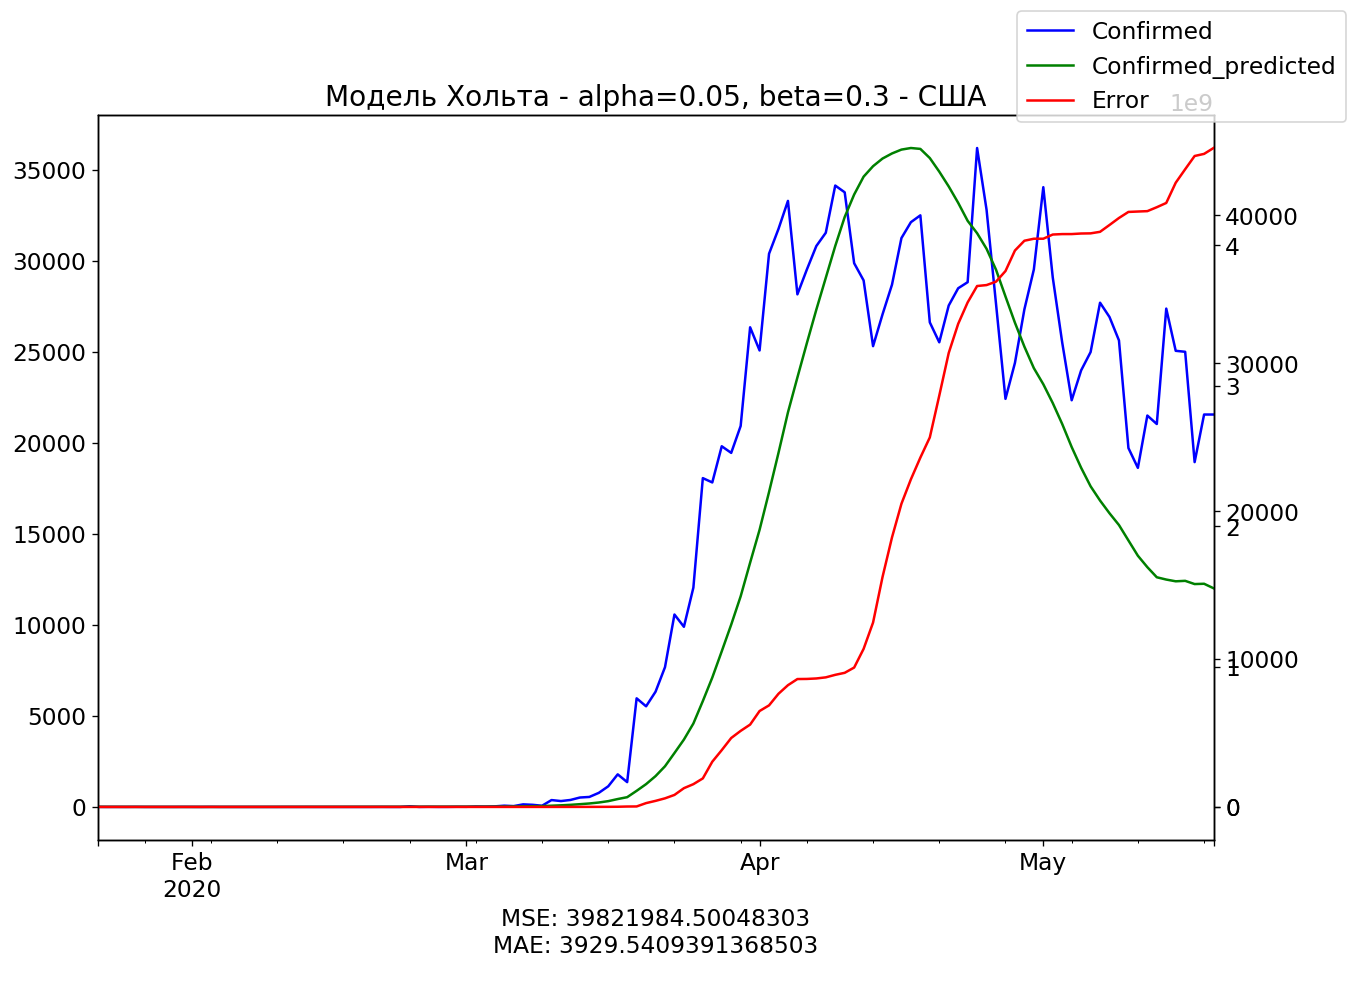

In [53]:
new_us_df = holt_df(us_increase, 0.05, 0.3)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.05, beta=0.3 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

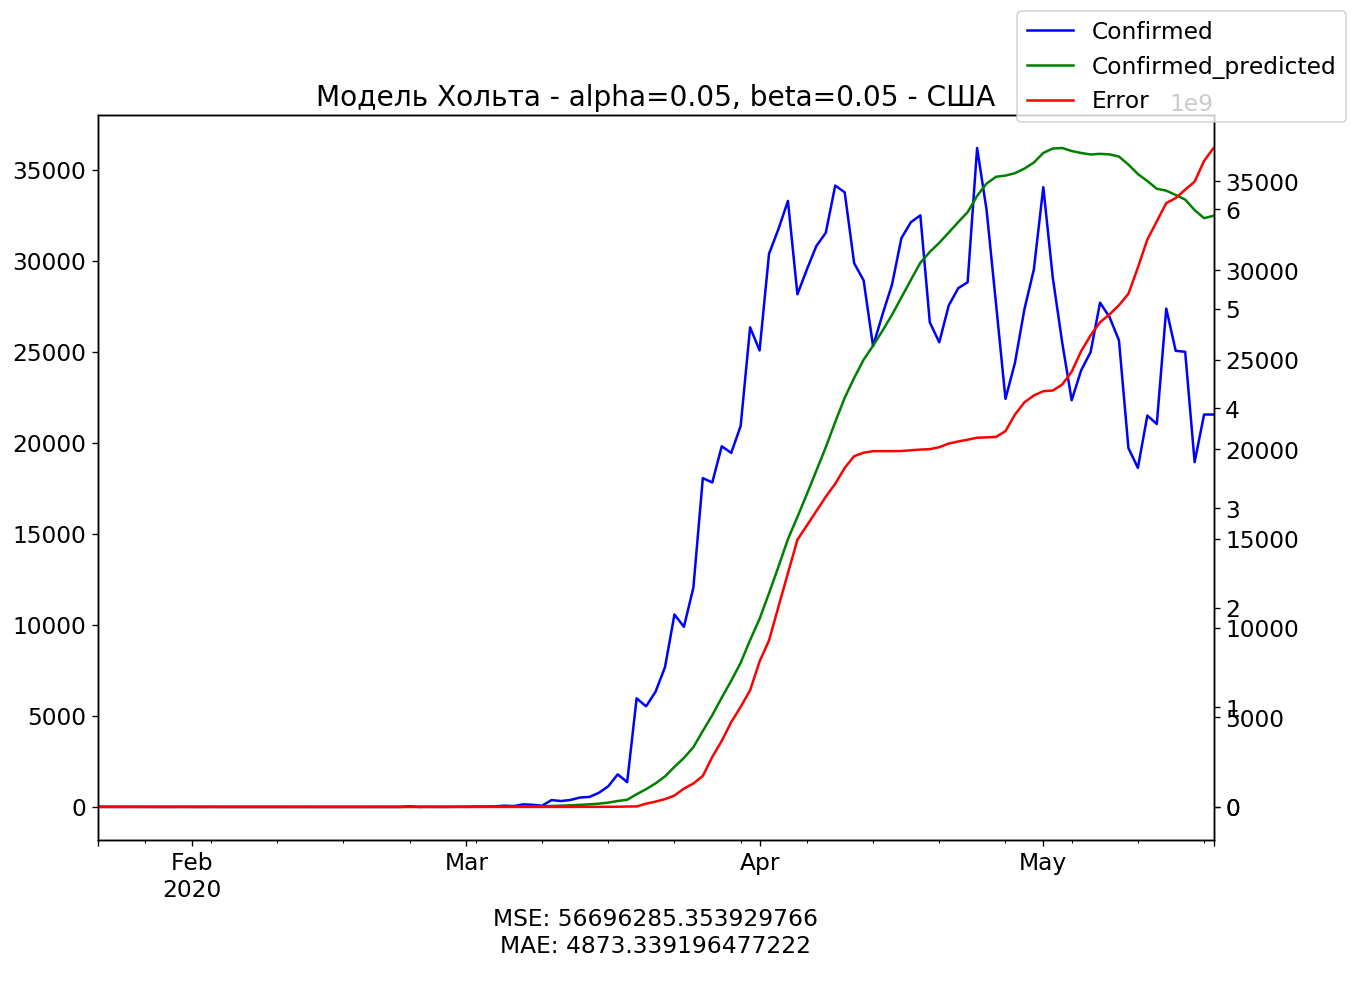

In [54]:
new_us_df = holt_df(us_increase, 0.05, 0.05)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.05, beta=0.05 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

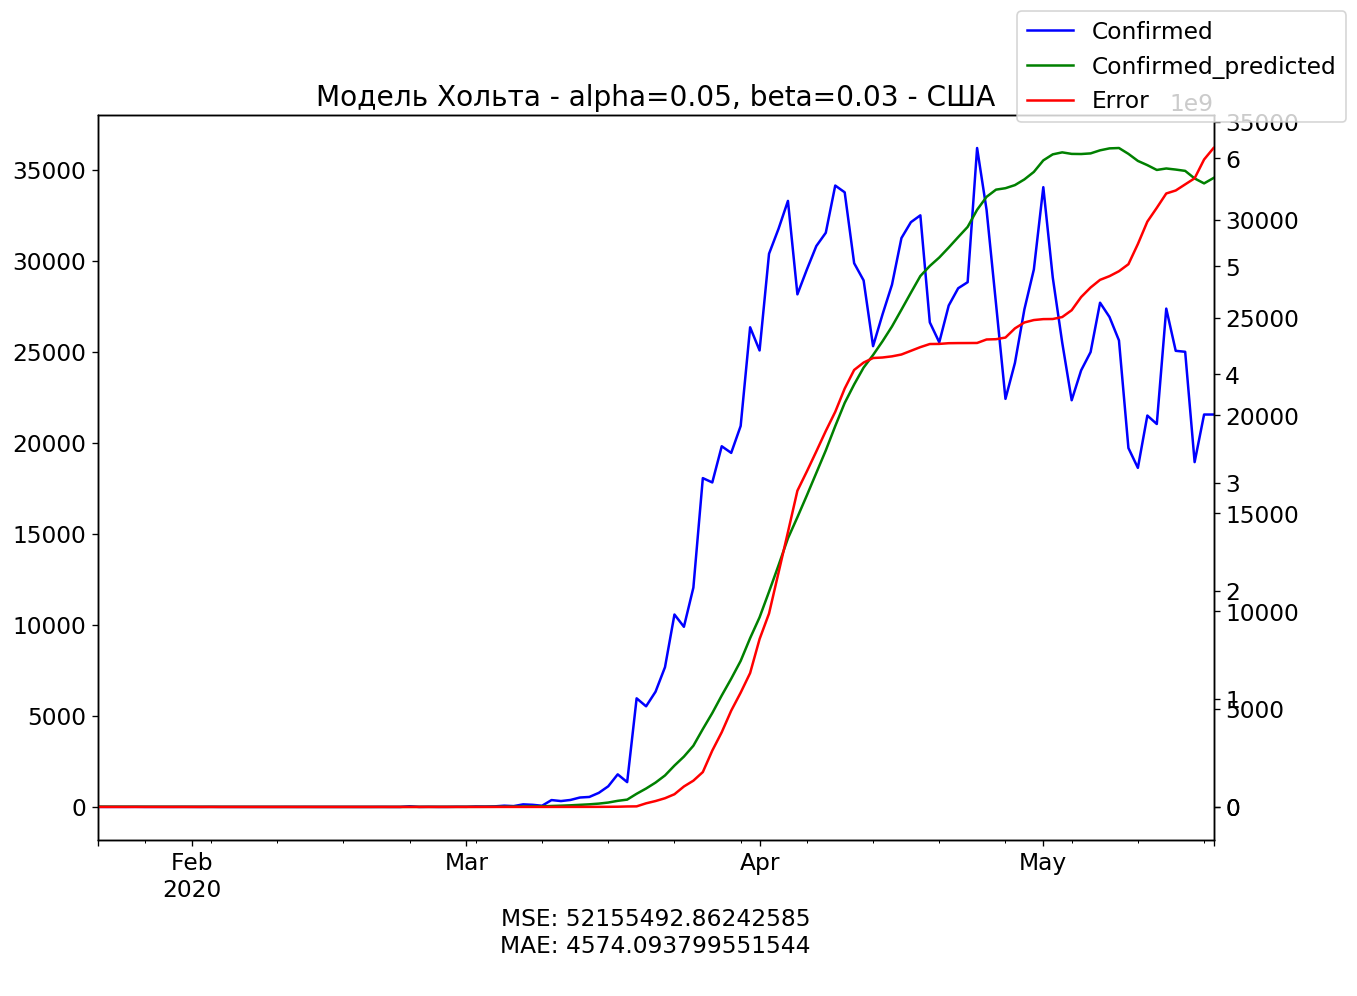

In [55]:
new_us_df = holt_df(us_increase, 0.05, 0.03)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.05, beta=0.03 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

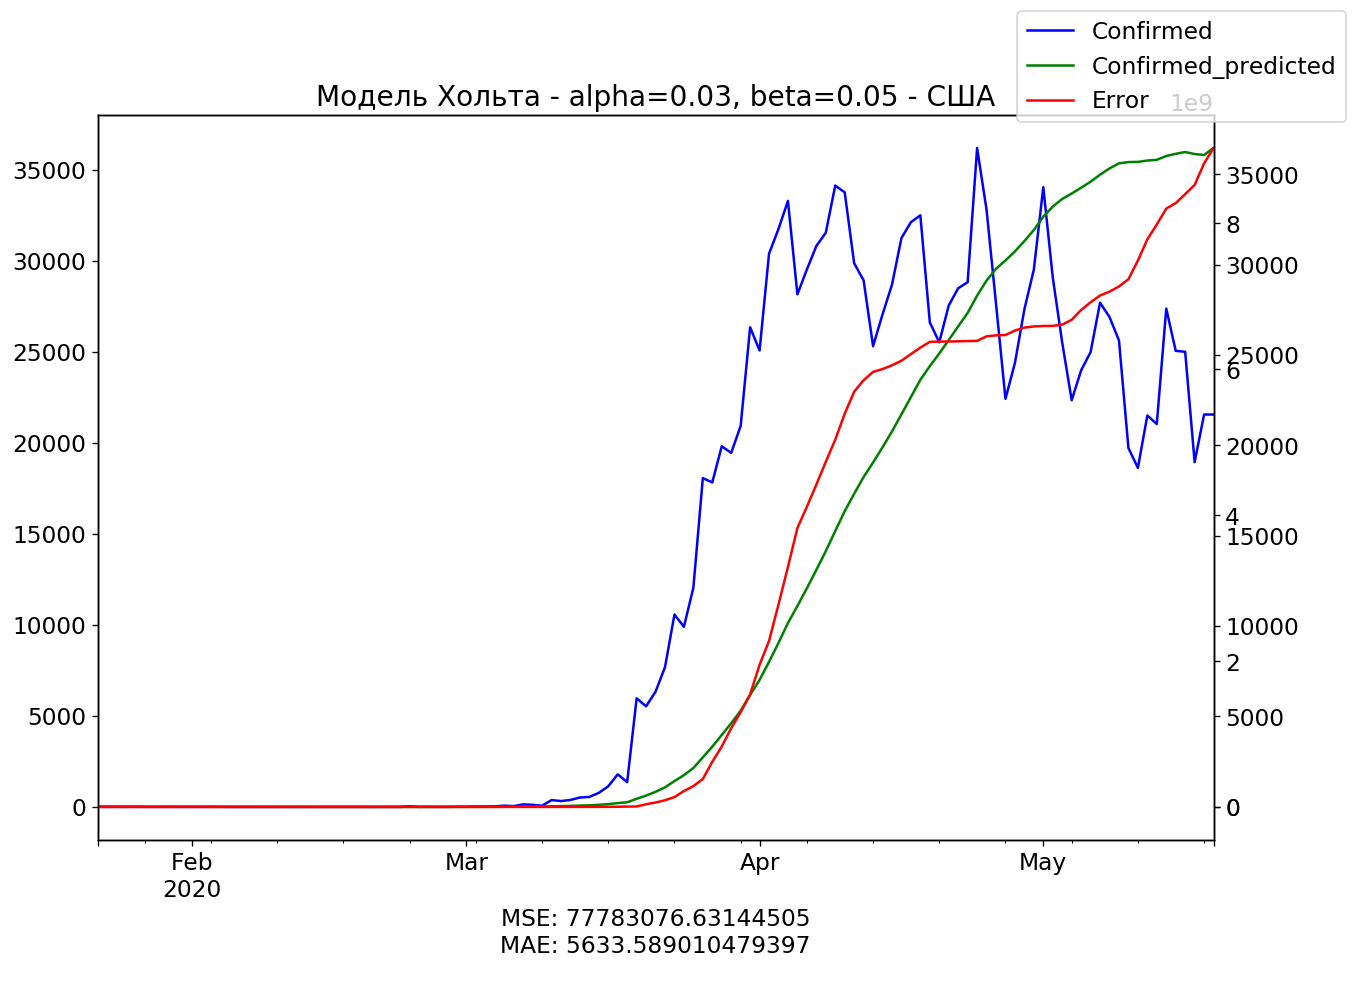

In [56]:
new_us_df = holt_df(us_increase, 0.03, 0.05)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.03, beta=0.05 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

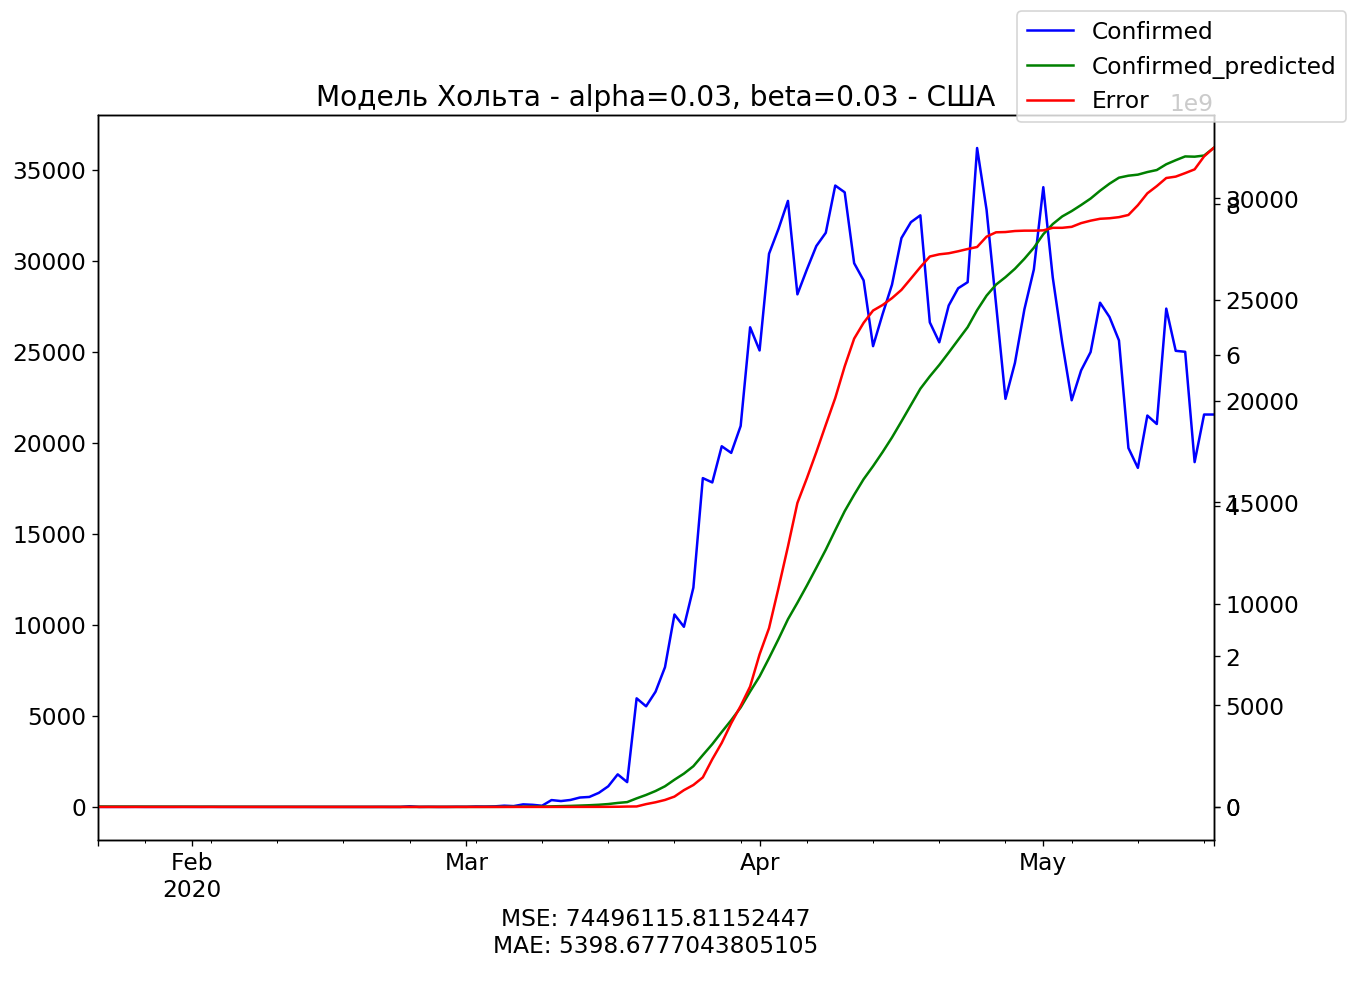

In [57]:
new_us_df = holt_df(us_increase, 0.03, 0.03)
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, "Модель Хольта - alpha=0.03, beta=0.03 - США", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

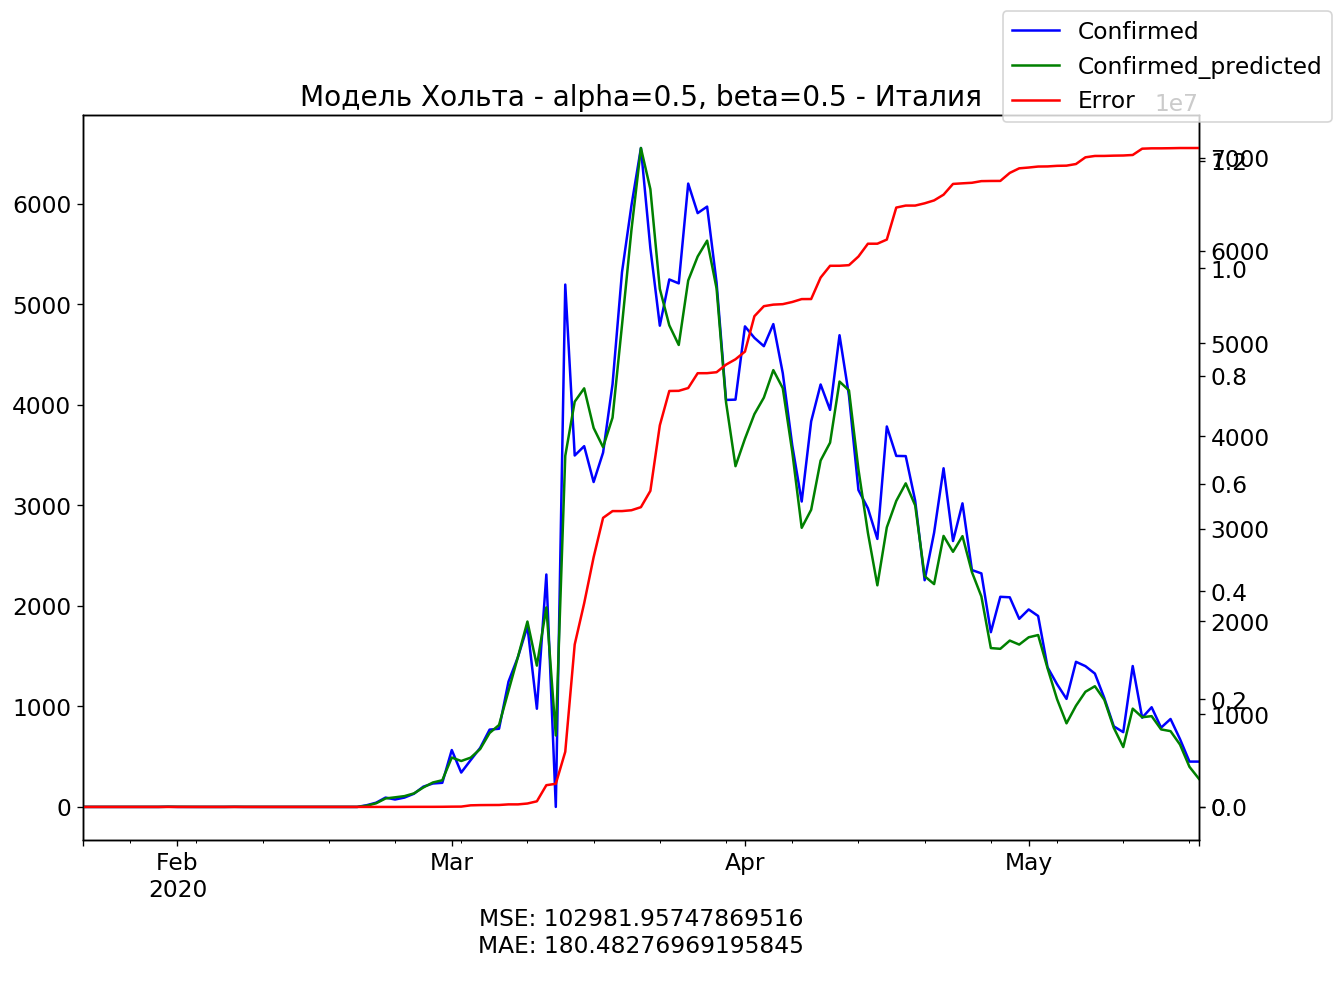

In [58]:
new_italy_df = holt_df(italy_increase, 0.5, 0.5)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.5, beta=0.5 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

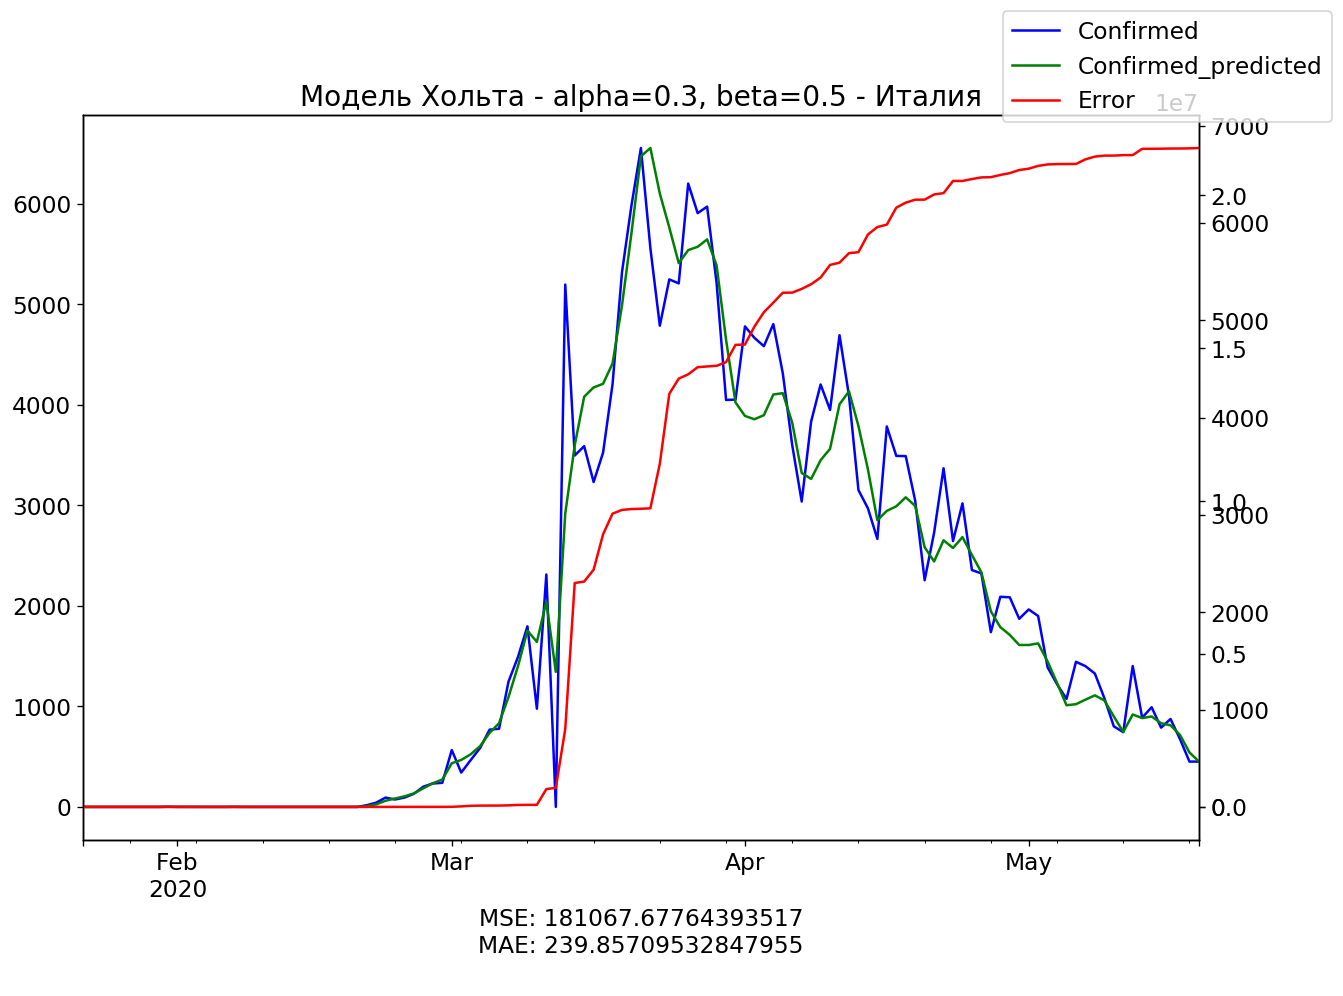

In [59]:
new_italy_df = holt_df(italy_increase, 0.3, 0.5)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.3, beta=0.5 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

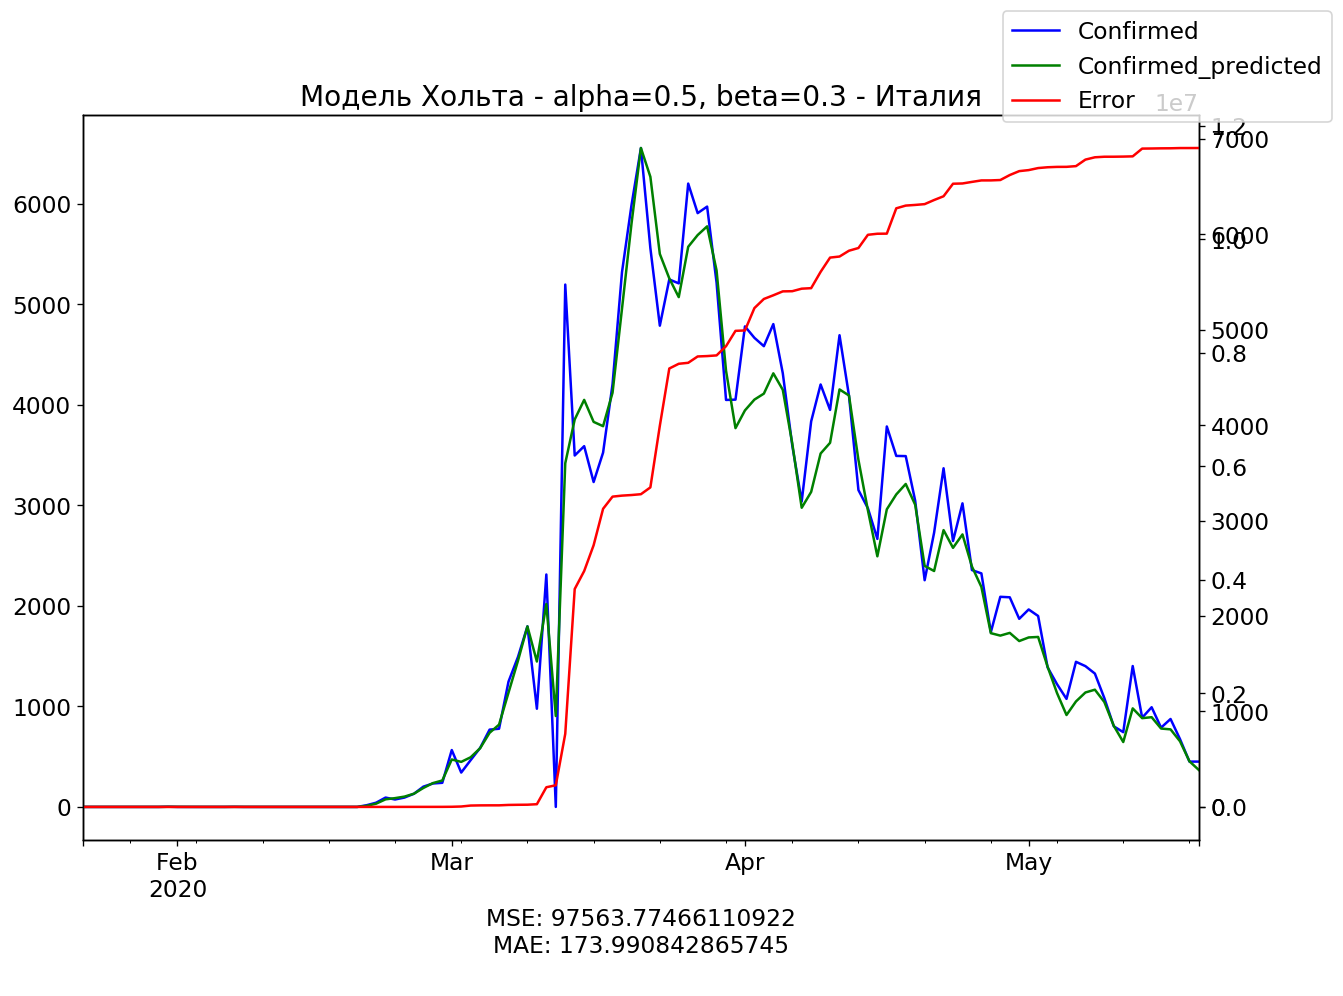

In [60]:
new_italy_df = holt_df(italy_increase, 0.5, 0.3)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.5, beta=0.3 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

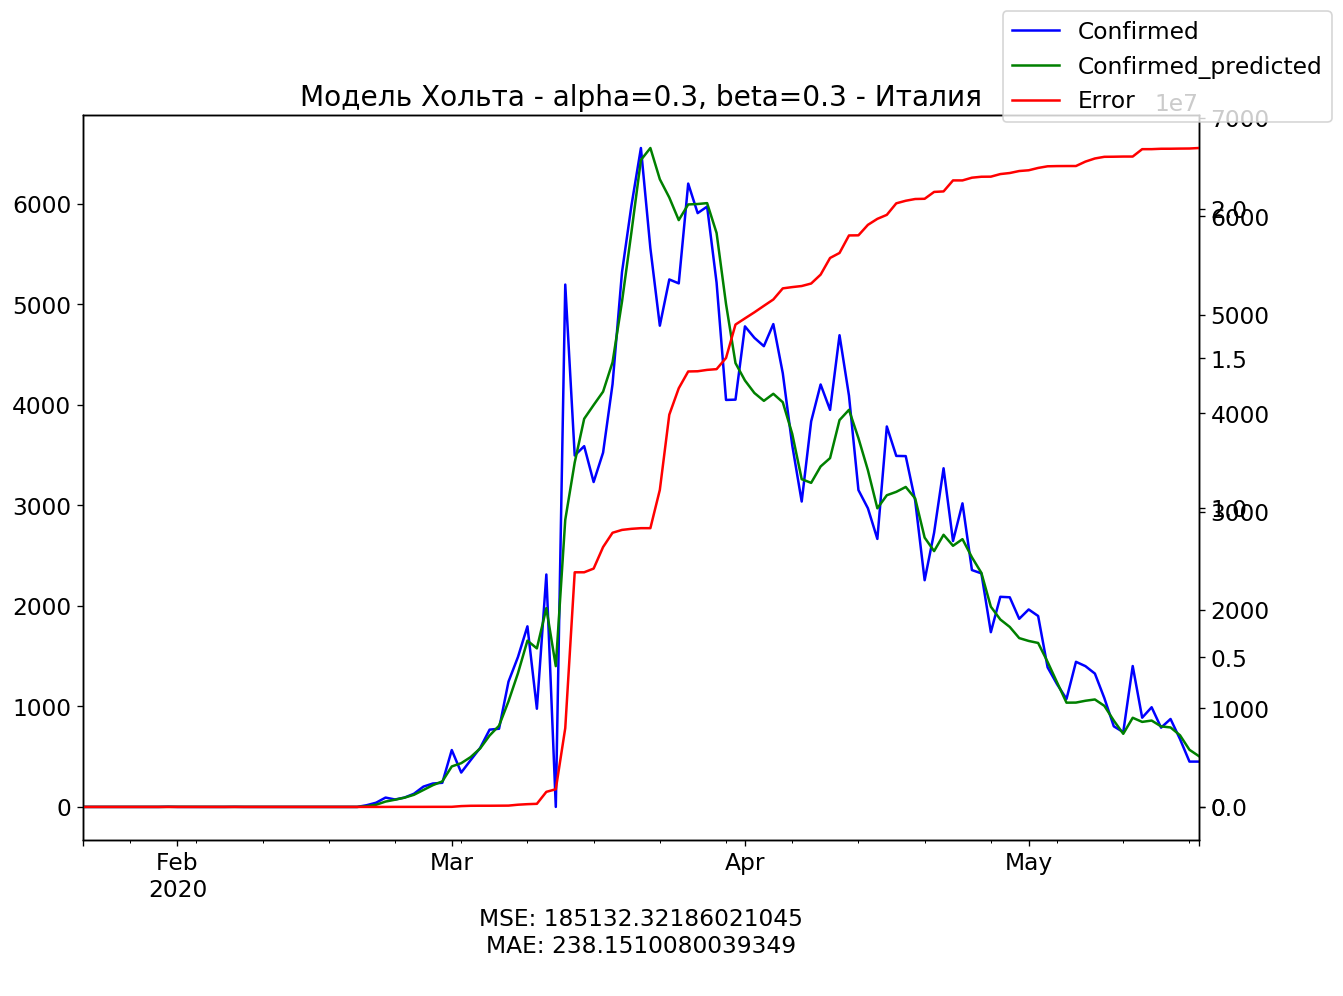

In [61]:
new_italy_df = holt_df(italy_increase, 0.3, 0.3)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.3, beta=0.3 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

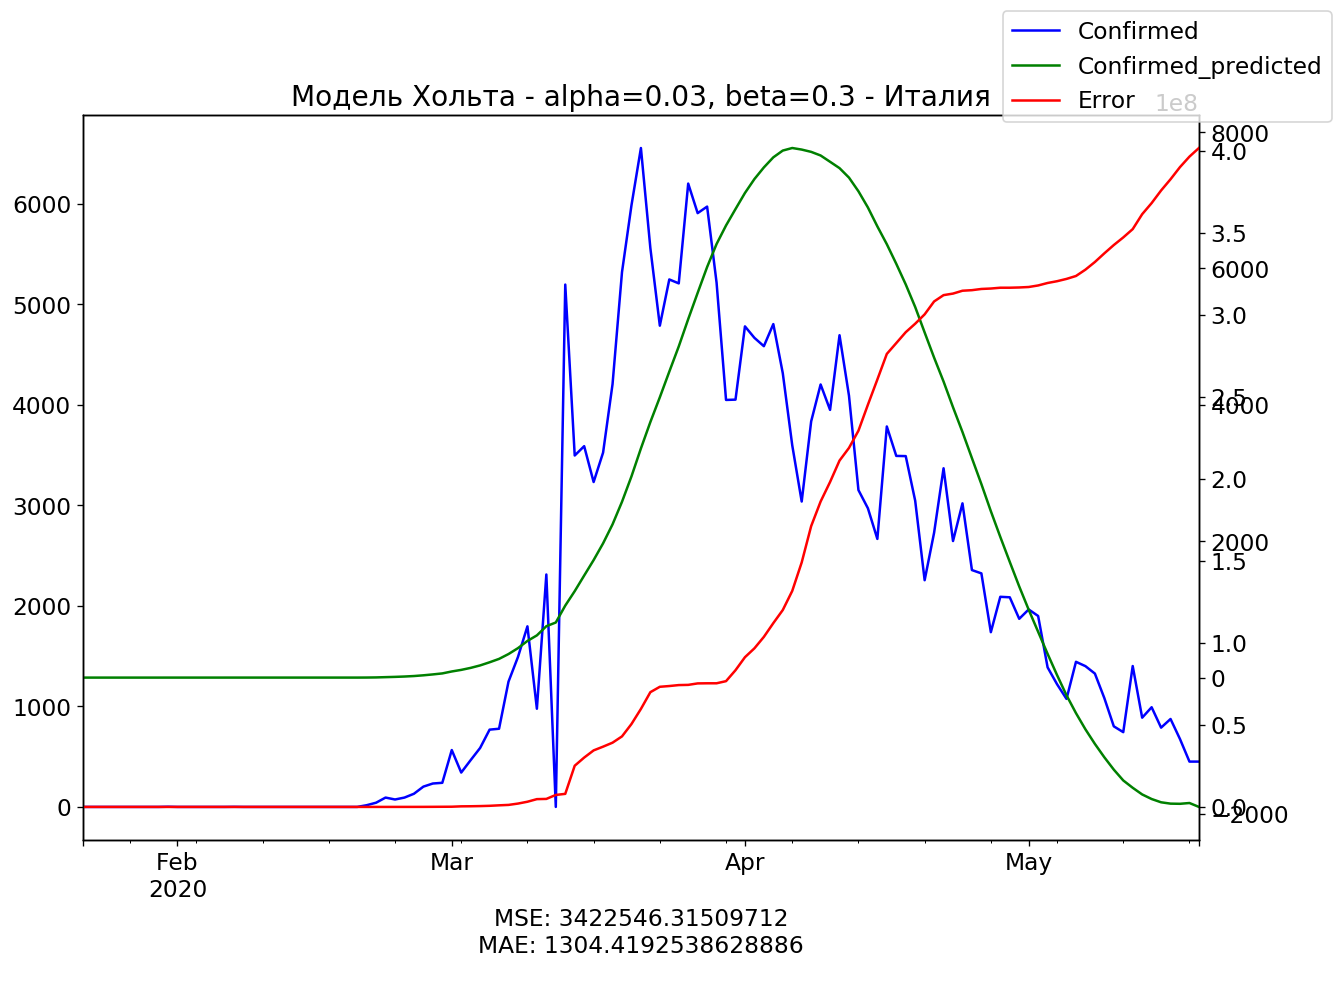

In [62]:
new_italy_df = holt_df(italy_increase, 0.03, 0.3)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.03, beta=0.3 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

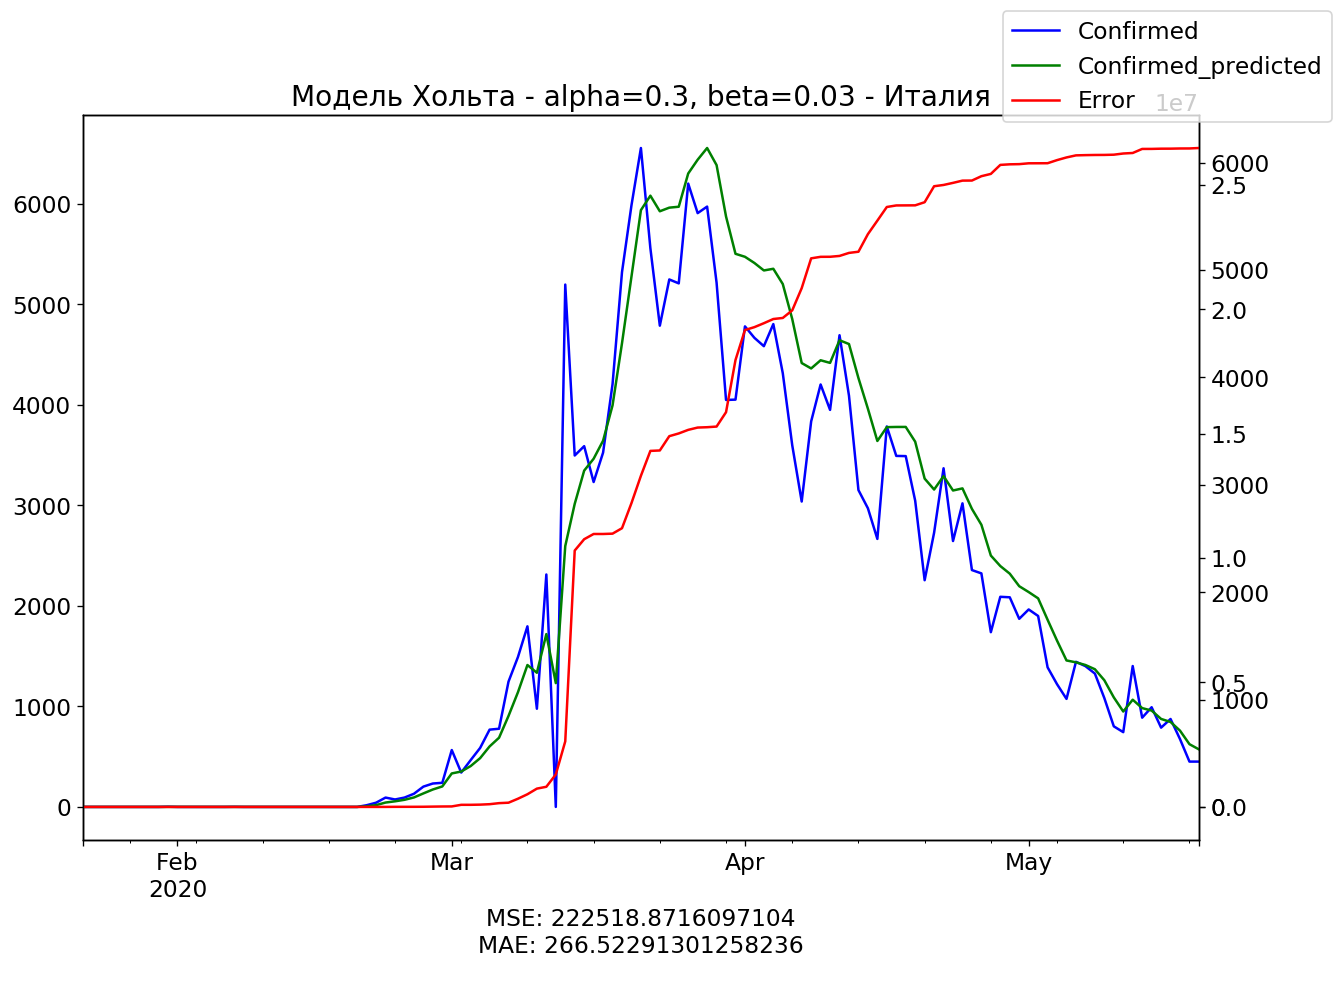

In [63]:
new_italy_df = holt_df(italy_increase, 0.3, 0.03)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.3, beta=0.03 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

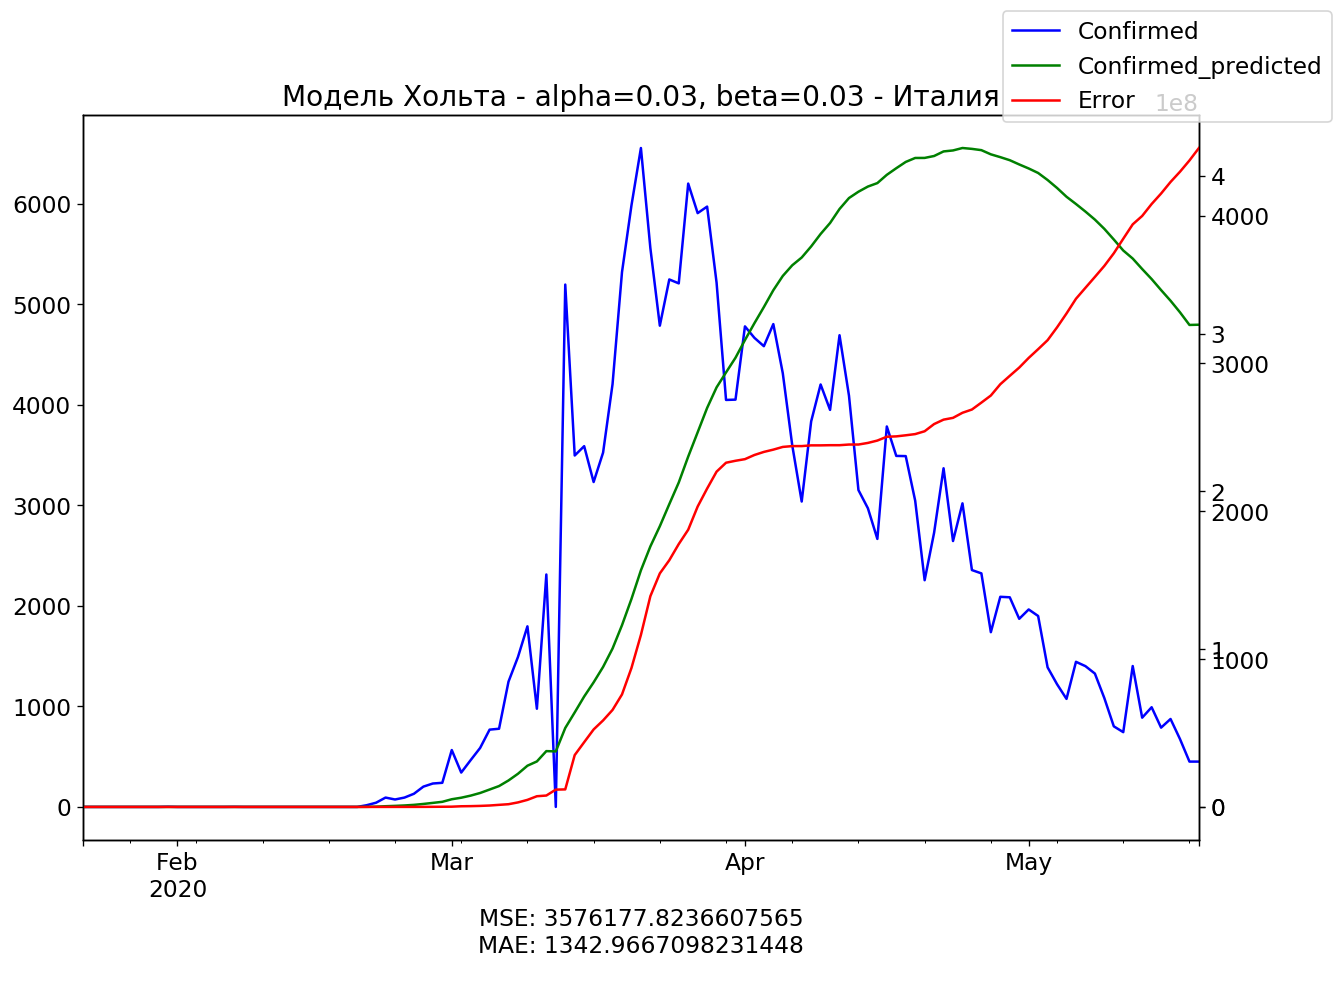

In [64]:
new_italy_df = holt_df(italy_increase, 0.03, 0.03)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.03, beta=0.03 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

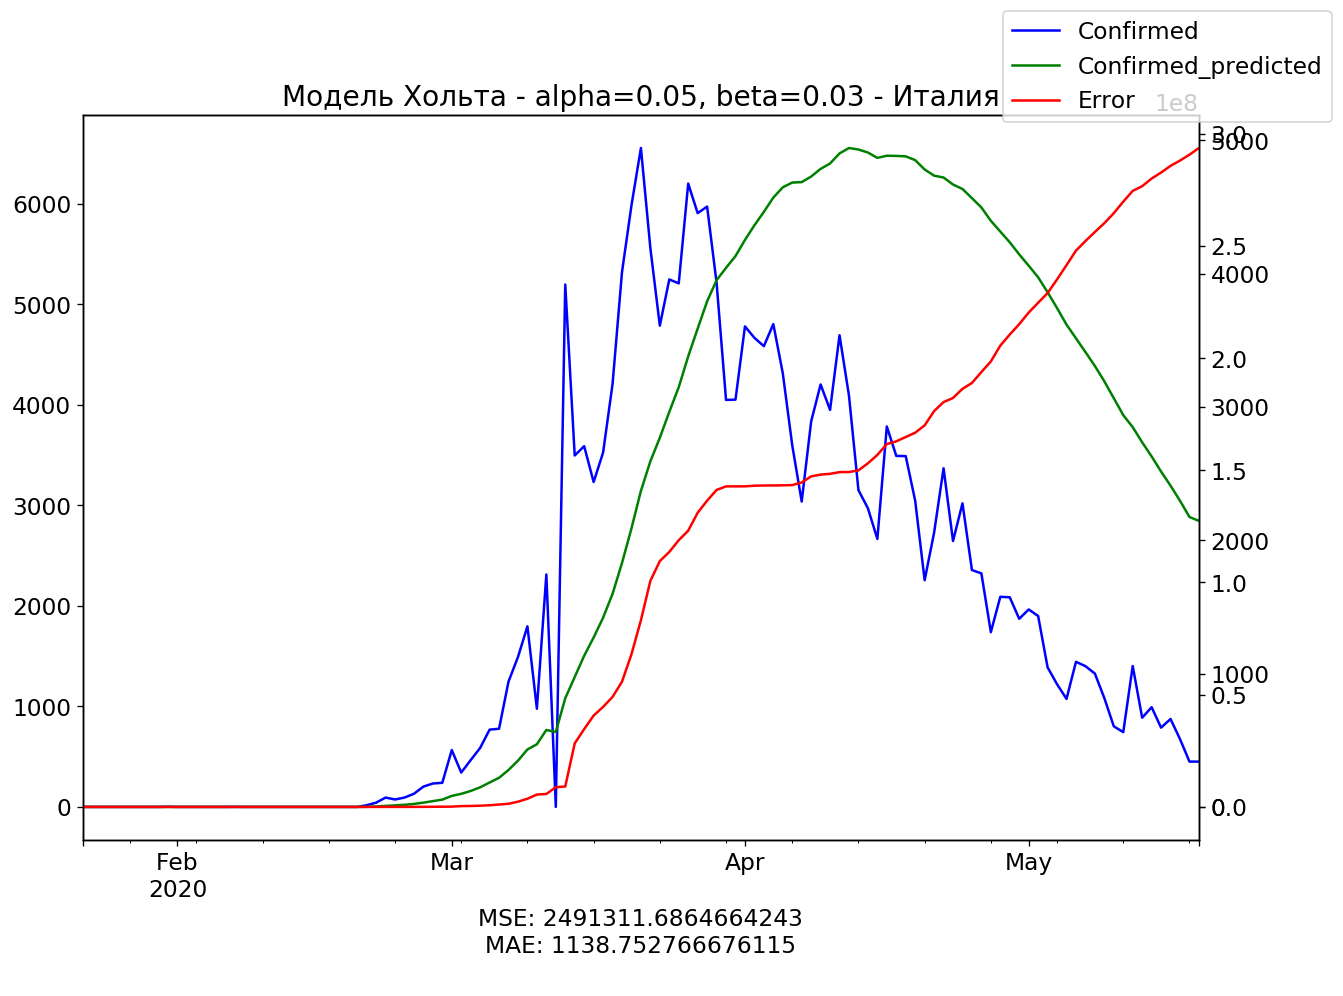

In [65]:
new_italy_df = holt_df(italy_increase, 0.05, 0.03)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.05, beta=0.03 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

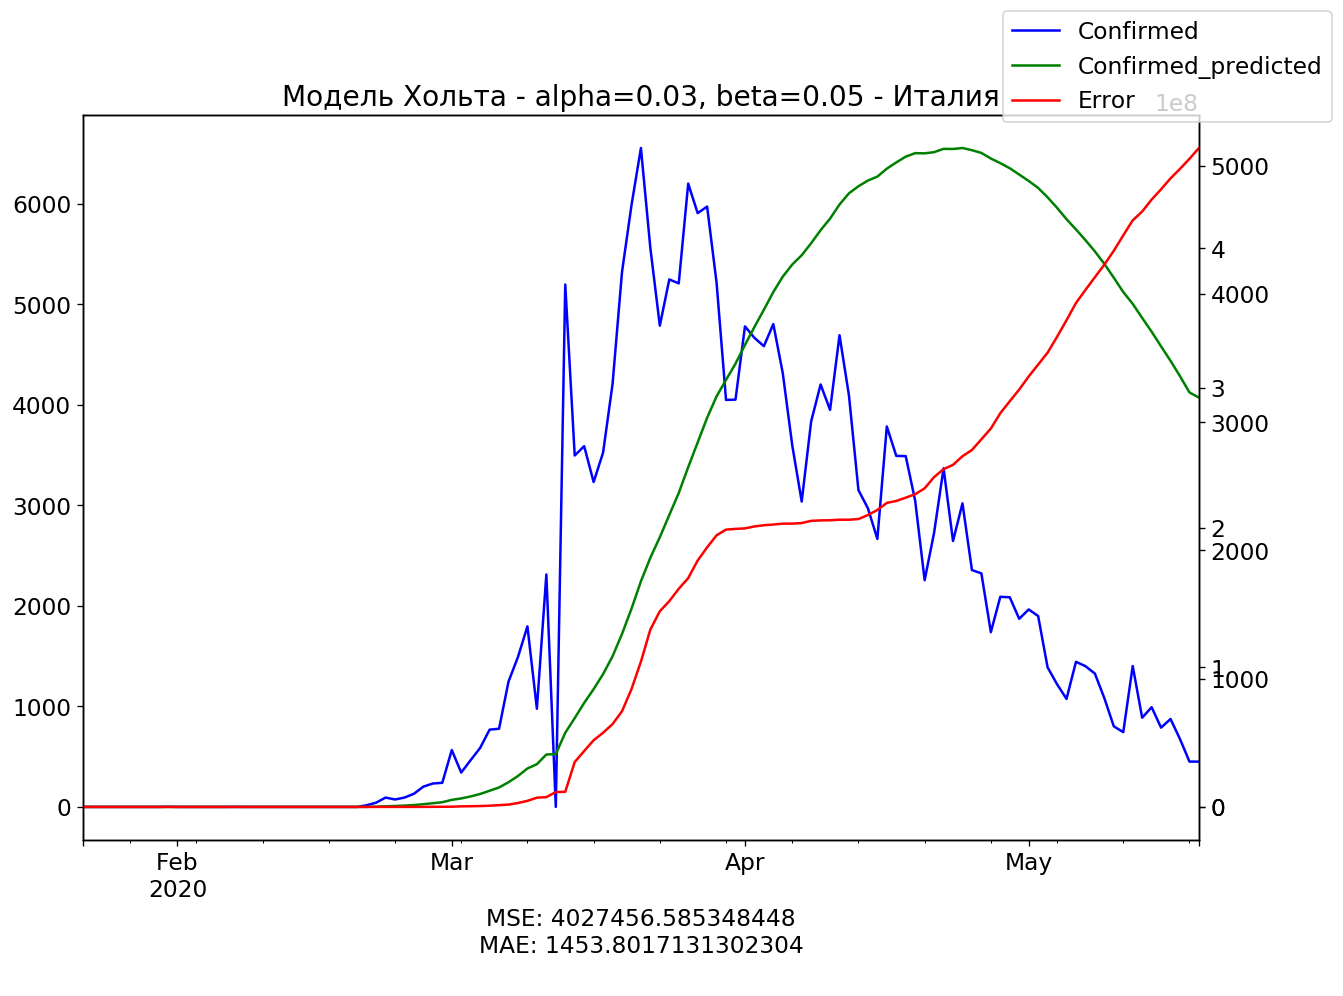

In [66]:
new_italy_df = holt_df(italy_increase, 0.03, 0.05)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.03, beta=0.05 - Италия", mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

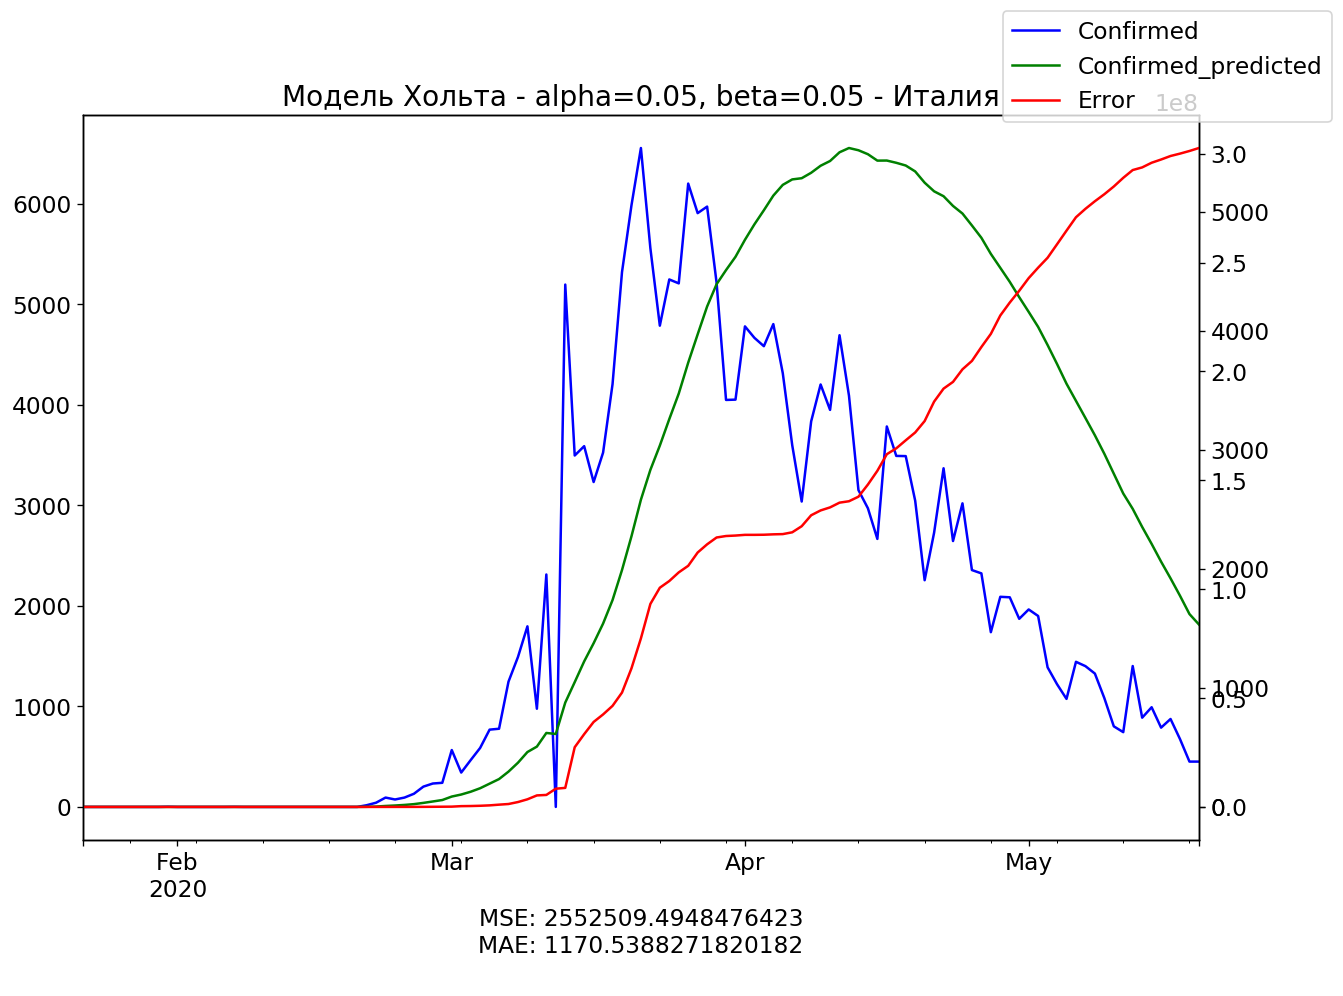

In [67]:
new_italy_df = holt_df(italy_increase, 0.05, 0.05)
mean_error = mean_squared_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_italy_df['Confirmed'], new_italy_df['Confirmed_predicted'])
vis_eq(new_italy_df, "Модель Хольта - alpha=0.05, beta=0.05 - Италия", mean_error, absolute_error)

Сравнивая все графики при разных показателях, можно заметить, что изменяя параметр $\beta$ сильно меняется тренд, но остается уровень запоминания прошлых значений и наоборот. Чем ниже значения, тем галдче график и более гладкий тренд. На малом количестве данных такой алгоритм себя показывает лучше, чем предыдущие, но все равно есть сильные погрешности и отклонения от изначальных данных.


#### Метод Хольта-Винтерса

Рассмотрим последний вид экспоненциального сглаживания, называемый методом Холта-Винтерса. Он основан на двойном экспоненциальном сглаживании с добавлением третьей компоненты - сезонности. В данном случае наш ряд обделен характеристикой сезонности, поэтому мы вряд ли получим хороший прогноз на основе этих данных, но стоит рассмотреть как алгоритм себя поведет на них. 

Теперь система будет выглядеть следующим образом:

$\iota_x = \alpha(y_x - s_{x-L}) + (1 - \alpha)(\iota_{x-1} + b_{x-1})$

$b_x = \beta(\iota_x-\iota_{x-1}) + (1 - \beta)b_{x-1}$

$s_x = \gamma(y_x - \iota_x) + (1 - \gamma)s_{x-L}$

$\hat{y}_{x+m} = \iota_x + mb_x + s_{x-L+1+(m-1)modL}$

In [68]:
class HoltWinters:
    def __init__(self, df, slen, alpha, beta, gamma, n_preds, column_name, scaling_factor=1.96):
        self.df = df
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.column_name = column_name
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.df[self.column_name][i+self.slen] - self.df[self.column_name][i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.df[self.column_name])/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.df[self.column_name][self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.df[self.column_name][self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.df[self.column_name])+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.df[self.column_name][0]
                trend = self.initial_trend()
                self.result.append(self.df[self.column_name][0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.df[self.column_name]): # прогнозируем
                m = i - len(self.df[self.column_name]) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.df[self.column_name][i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.df[self.column_name][i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

    def triple_smooth_df(self):
        new_df = self.df.copy()
        for i in range(1, self.n_preds + 1):
            dt = pd.to_datetime(self.df['Date'].to_numpy()[-1]) + timedelta(days=i)
            new_df = new_df.append({'Date': dt,'Confirmed': self.df['Confirmed'].to_numpy()[-1], 'Deaths': self.df['Deaths'].to_numpy()[-1]},ignore_index=True)
        self.triple_exponential_smoothing()
        new_df[self.column_name + '_predicted'] = self.result
        new_df['Error'] = SE(new_df[self.column_name], new_df[self.column_name + '_predicted'])
        return new_df


<Figure size 1440x960 with 0 Axes>

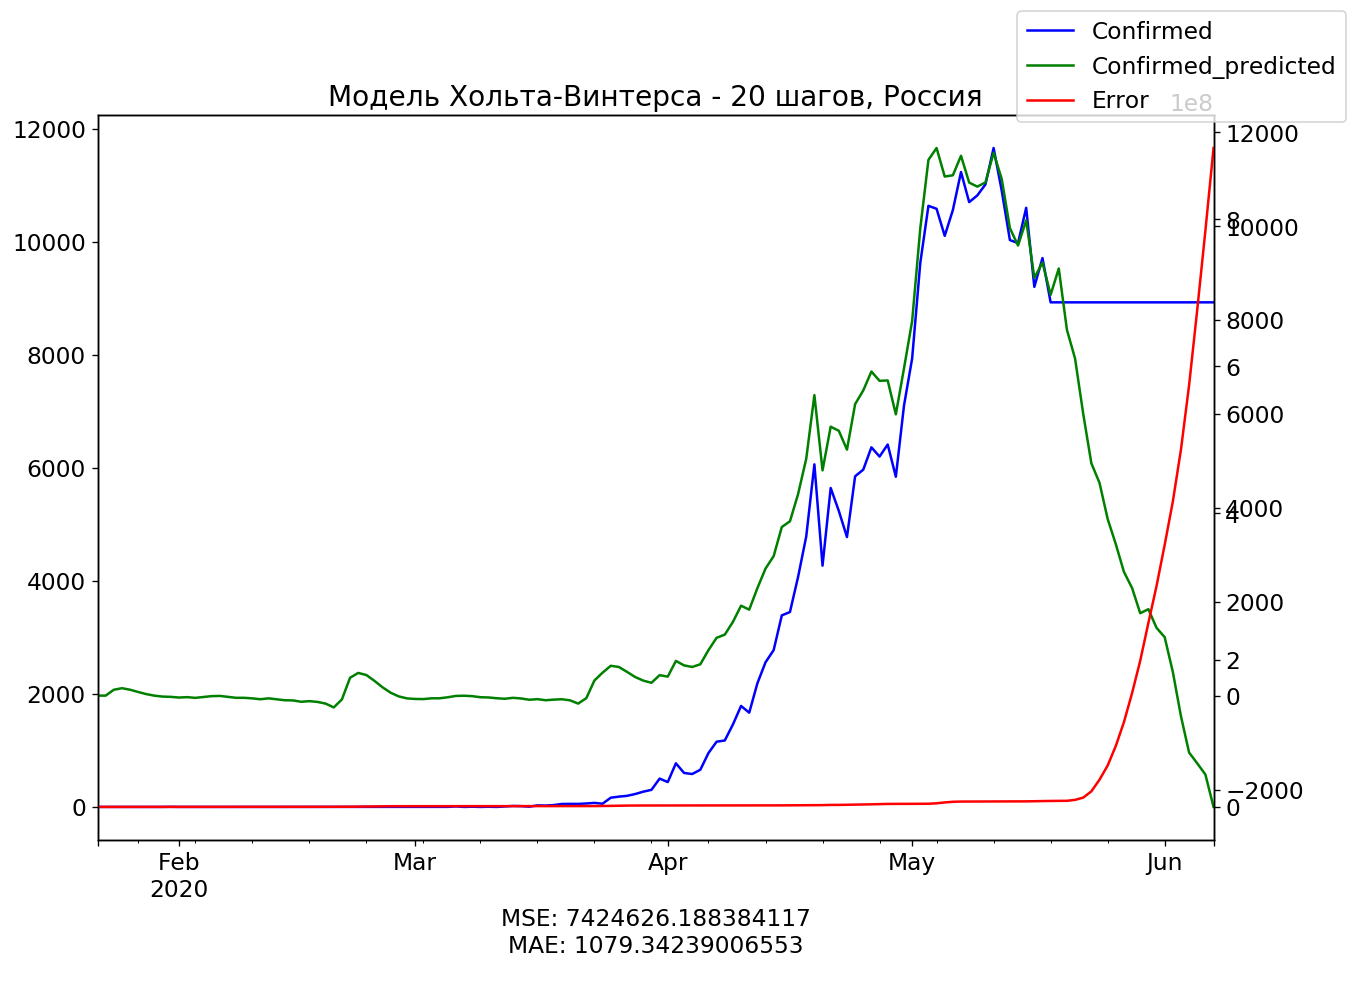

In [69]:
new_russia_df = HoltWinters(russia_increase, 30, 0.5, 0.5, 0.5, 20, 'Confirmed').triple_smooth_df()
mean_error = mean_squared_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_russia_df['Confirmed'], new_russia_df['Confirmed_predicted'])
vis_eq(new_russia_df, 'Модель Хольта-Винтерса - 20 шагов, Россия', mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

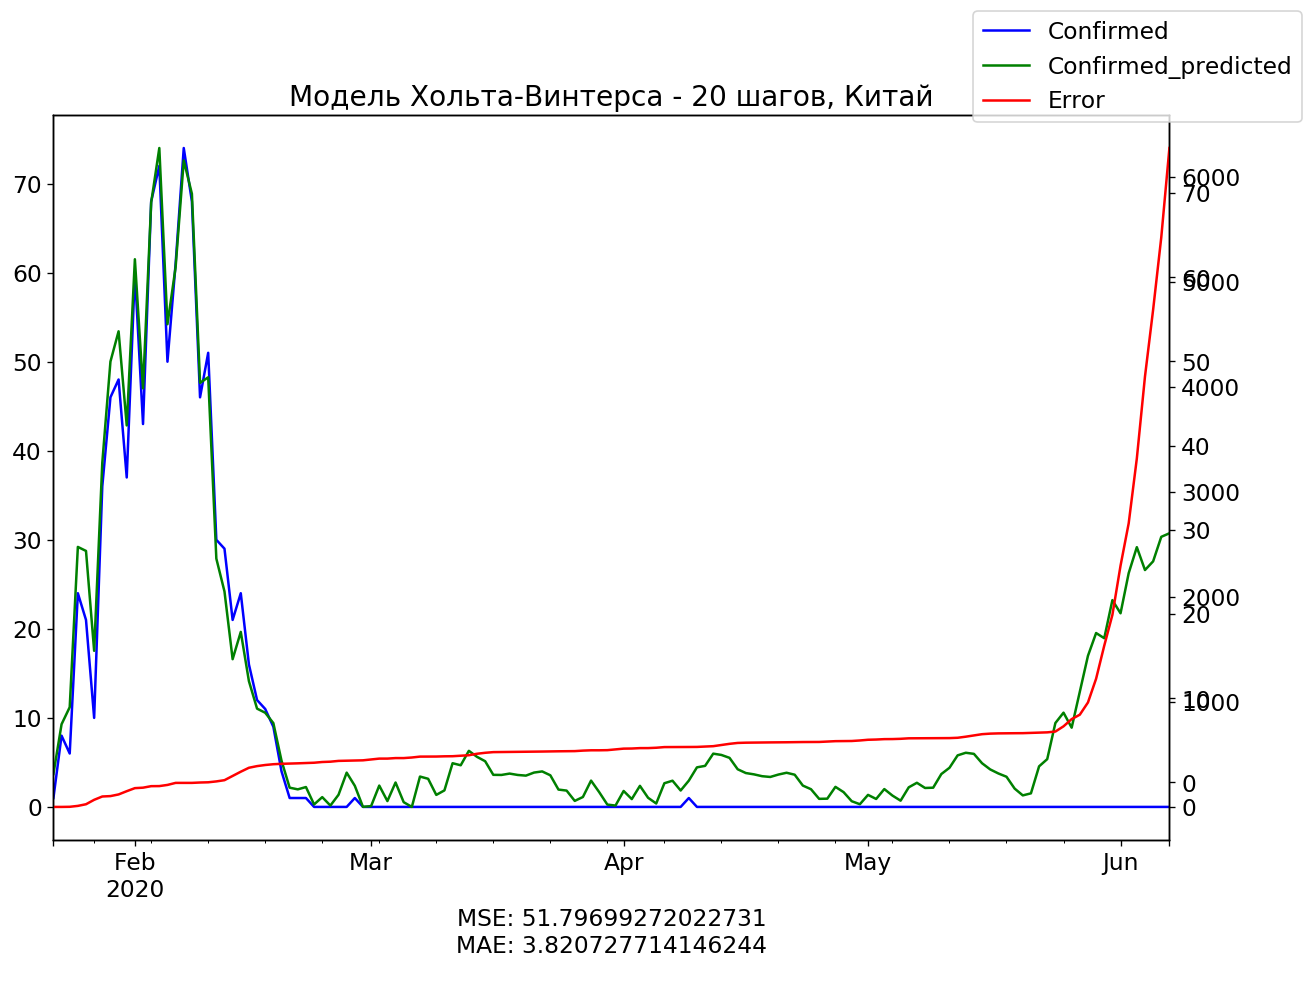

In [70]:
new_china_df = HoltWinters(china_increase, 30, 0.5, 0.5, 0.5, 20, 'Confirmed').triple_smooth_df()
mean_error = mean_squared_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_china_df['Confirmed'], new_china_df['Confirmed_predicted'])
vis_eq(new_china_df, 'Модель Хольта-Винтерса - 20 шагов, Китай', mean_error, absolute_error)

<Figure size 1440x960 with 0 Axes>

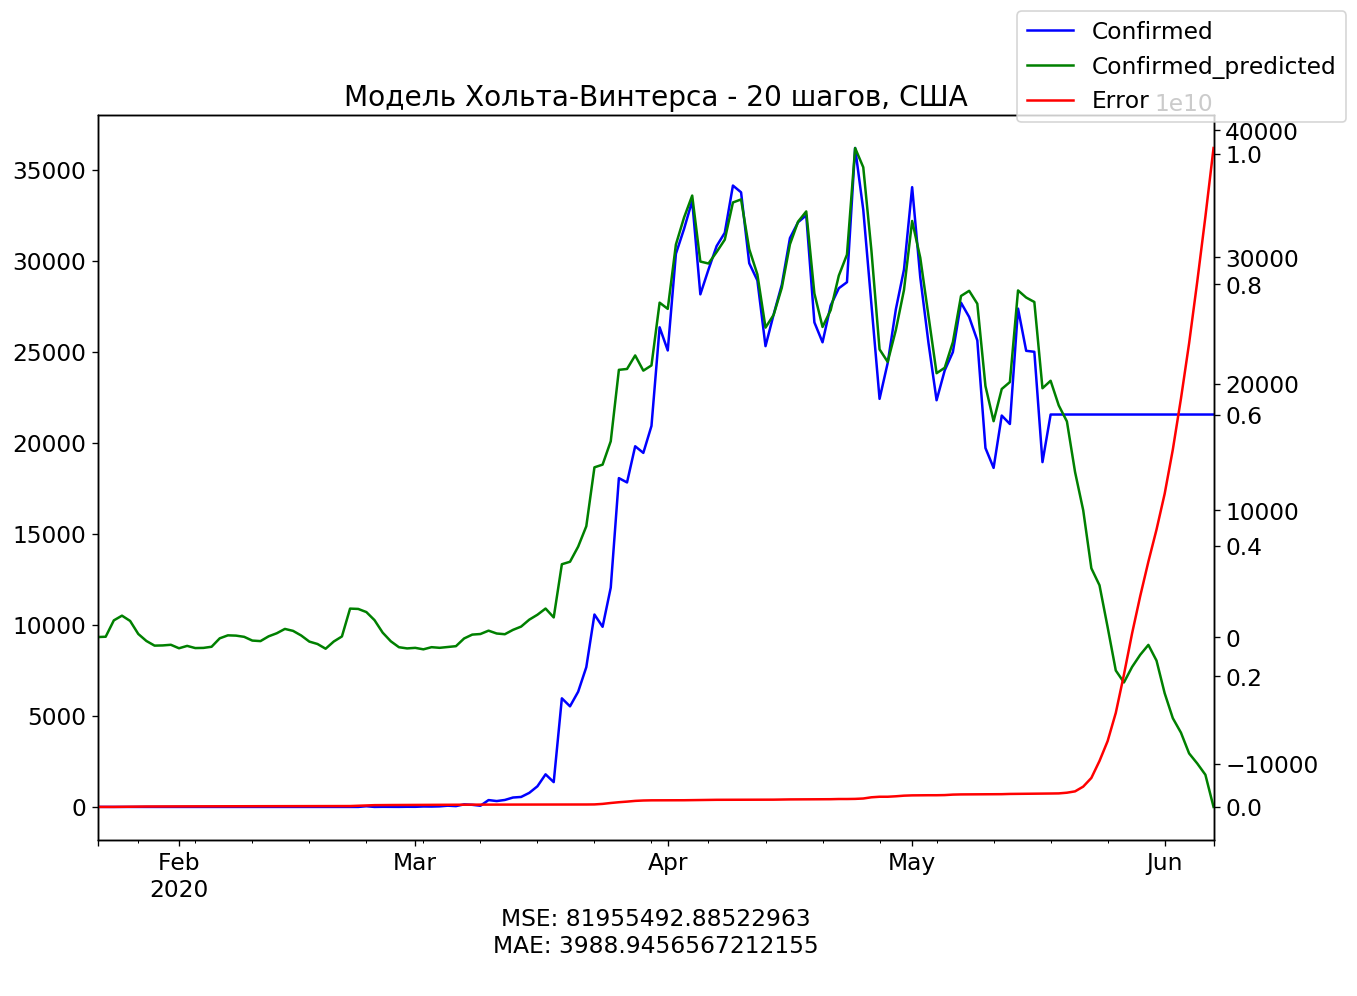

In [71]:
new_us_df = HoltWinters(us_increase, 30, 0.5, 0.5, 0.5, 20, 'Confirmed').triple_smooth_df()
mean_error = mean_squared_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
absolute_error = mean_absolute_error(new_us_df['Confirmed'], new_us_df['Confirmed_predicted'])
vis_eq(new_us_df, 'Модель Хольта-Винтерса - 20 шагов, США', mean_error, absolute_error)

#### Рекуррентные нейронные сети (LSTM)

Еще одним эффективным методом анализа временных рядов являются рекуррентные нейронные сети. Самая простая нейронная сеть – перцептрон (один слой нейронов, принимающих кусок данных, модифицирует его исходя из своего веса и передает дальше). Выдача нейронов объединяется тем или иным образом.

Функционал такой сети расширяется добавлением нейронов, слоев или добавлением операции свертки.
Ограничения – входные и выходные данные имеют фиксированный ранее обозначенный размер.

Рекуррентные нейронные сети – это сети с циклами, которые хорошо подходят для обработки последовательностей
Используется алгоритм обратного распространения ошибки с поправкой на предыдущие шаги. Называется «алгоритмом обратного распространения ошибки сквозь время» (Backpropagation Through Time).

Суть работы заключается в последовательном выполнении одной и той же задачи для каждого элемента последовательности с учетом вычисления предыдущей задачи.

Архитектура нейронной сети, основанная на рекуррентной нейронной сети, способная запоминать значения как на короткие, так и на длинные промежутки времени. 
LSTM-модуль не использует функцию активации внутри своих рекуррентных компонентов => хранимое значение не размывается во времени, градиент или штраф не исчезает при использовании обратного распространения ошибки.
Разработаны специально для решения проблемы долгосрочных связей.


Ключевое – состояние ячейки, напоминает конвейерную ленту
Кол-во информации уменьшается или увеличивается в зависимости от потребности (регулируются гейтами, состоящие из сигмовидного слоя и поточечного умножения).

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))
china_increase_lstm = china_increase.copy()
china_increase_lstm['Date'] = china_increase_lstm['Date'].astype(np.int64)
china_increase_lstm = china_increase_lstm.drop(['Deaths'], axis=1)
dataset_date = scaler.fit_transform(china_increase_lstm['Date'].to_numpy().reshape(-1, 1))
dataset_conf = scaler.fit_transform(china_increase_lstm['Confirmed'].to_numpy().reshape(-1, 1))
dataset = np.array([dataset_date, dataset_conf])
dataset = dataset.reshape(118, 2)

In [73]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

82 36


In [74]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [75]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [76]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Train on 80 samples
Epoch 1/100
80/80 - 5s - loss: 0.2641
Epoch 2/100
80/80 - 0s - loss: 0.1844
Epoch 3/100
80/80 - 1s - loss: 0.1253
Epoch 4/100
80/80 - 1s - loss: 0.0886
Epoch 5/100
80/80 - 0s - loss: 0.0697
Epoch 6/100
80/80 - 1s - loss: 0.0609
Epoch 7/100
80/80 - 1s - loss: 0.0560
Epoch 8/100
80/80 - 1s - loss: 0.0525
Epoch 9/100
80/80 - 0s - loss: 0.0488
Epoch 10/100
80/80 - 0s - loss: 0.0460
Epoch 11/100
80/80 - 0s - loss: 0.0422
Epoch 12/100
80/80 - 0s - loss: 0.0389
Epoch 13/100
80/80 - 0s - loss: 0.0360
Epoch 14/100
80/80 - 0s - loss: 0.0333
Epoch 15/100
80/80 - 0s - loss: 0.0312
Epoch 16/100
80/80 - 1s - loss: 0.0288
Epoch 17/100
80/80 - 1s - loss: 0.0267
Epoch 18/100
80/80 - 1s - loss: 0.0251
Epoch 19/100
80/80 - 1s - loss: 0.0235
Epoch 20/100
80/80 - 0s - loss: 0.0224
Epoch 21/100
80/80 - 0s - loss: 0.0213
Epoch 22/100
80/80 - 1s - loss: 0.0206
Epoch 23/100
80/80 - 0s - loss: 0.0200
Epoch 24/100
80/80 - 0s - loss: 0.0192
Epoch 25/100
80/80 - 0s - loss: 0.0188
Epoch 26/100
8

In [78]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict).reshape(-1,1)
trainY = scaler.inverse_transform([trainY]).reshape(-1,1)
testPredict = scaler.inverse_transform(testPredict).reshape(-1,1)
testY = scaler.inverse_transform([testY]).reshape(-1,1)

trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.47 RMSE
Test Score: 2.39 RMSE


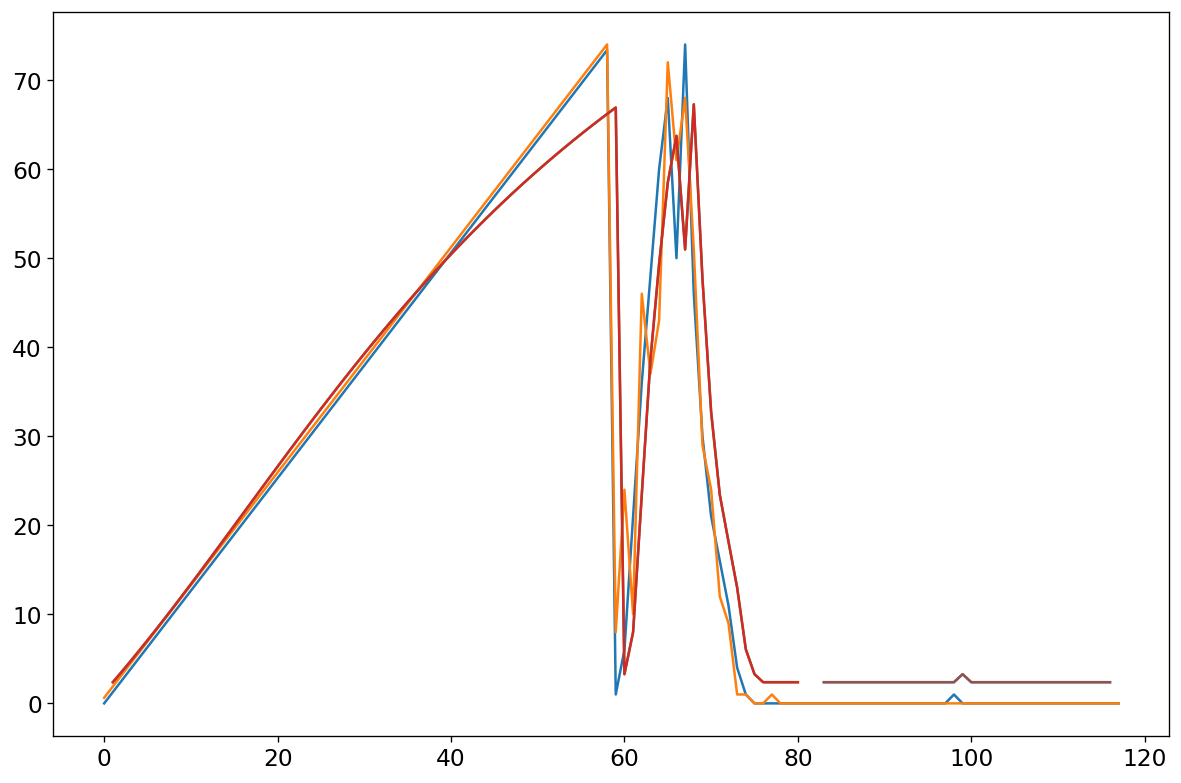

In [79]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### Заключение

С помощью вышеприведенных методов можно анализировать различные последовательности замеров, называемых временным рядом. Более точно себя показывают нейронные сети и методы, которые основываются на определенных весах (метод взвешенного среднего) и экспоненциальное сглаживание, которые можно динамично изменять и перестраивать с целью улучшения показателей метода и более точного прогноза. Анализ временных рядов используется в основном для задач экономики, медицины и статистики, где само понятие временного ряда крайне часто используемо в практике и теории.

На используемом датасете по COVID-19 получилось наиболее точно предсказать с помощью двойного экспоненциального сглаживания и нейронных сетей, поскольку сам ряд собой представляет очень короткий промежуток замеров без наличия какой-либо сезонности. Сам ряд замеров можно назвать волнообразным, поскольку на примере с данными из Китая точно видно две волны заболеваний вирусом, но при этом зависимость этих волн напрямую не коррелируется с другими странами, поскольку в разных странах принимались различные меры по сдерживанию вируса и практически ни одна из них не делала это в точности как Китай или Россия, например, Республика Беларусь и Швеция. Поэтому о каких-то прямых зависимостях на таком коротком промежутке времени говорить сложно. Также стоит добавить, что самосознательность граждан разных стран может влиять сильнее на выборсы и волны заболеваний, судя по статистике в странах Китая и России, сравнивая с Италией и США. 

#### Источники

1. К.В. Воронцов, Прогнозирование временных рядов [Ссылка](http://www.machinelearning.ru/wiki/images/c/cb/Voron-ML-forecasting-slides.pdf)

2. К.В. Воронцов, Экспоненциальное скользящее среднее [Ссылка](http://www.machinelearning.ru/wiki/index.php?title=%D0%AD%D0%BA%D1%81%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%81%D0%B3%D0%BB%D0%B0%D0%B6%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

3. Hastie T., Tibshirani R., Friedman J. The Elements of Statistical Learning. Springer, 2014 [Ссылка](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

4. Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика 2003 [Ссылка](https://institutiones.com/download/books/1226-adaptivnye-metody-kratkosrochnogo-prognozirovaniya-vremennyh-ryadov.html)

5. Дмитрий Сергеев, Открытый курс машинного обучения. Тема 9. Анализ временных рядов с помощью Python [Ссылка](https://habr.com/ru/company/ods/blog/327242/)